# **Valores missing, outlier y correlaciones**

En este notebook se realiza el estudio y preprocesamiento de las variables numéricas y categoricas. Se realizarán los siguientes pasos:

1. Cambio de tipos de variables
2. Separación en train y test
3. Análisis de cada variable con gráficos descriptivos
4. Para variables numericas: correlaciones de pearnson, estudio de outliers y estudio de valores missing
5. Para variables categoricas: relleno de valores missing, estudio de correlaciones con vCramer


## **Importo librerías**




In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as ss
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

## **Funciones**

Voy guardando las funciones que están automatizadas y pienso que me van a servir en otros proyectos en un funciones_auxiliares.py y lo importo:

# **IMPROTARLAS AQUI NO EN CADA LINEA DE CODIGO**

In [147]:
def plot_continuous_variable(df, col_name, target=None):
    """
    Graficar variables continuas, con y sin la variable objetivo.

    Parámetros:
    - df: pd.DataFrame
        DataFrame que contiene los datos.
    - col_name: str
        Nombre de la columna a visualizar.
    - target: str, opcional
        Variable objetivo para facetas (por defecto es None).
    """
    count_null = df[col_name].isnull().sum()  # Contar los valores nulos en la columna.

    fig, axes = plt.subplots(1, 2 if target else 1, figsize=(14, 5), dpi=90)  # Crear subgráficos

    # Graficar un histograma con KDE (Kernel Density Estimation) para la variable continua
    sns.histplot(df[col_name].dropna(), kde=True, ax=axes[0] if target else axes, color="skyblue")
    axes[0 if target else 0].set_title(f"{col_name} (nulos: {count_null})")
    axes[0 if target else 0].set_xlabel(col_name)
    axes[0 if target else 0].set_ylabel("Count")

    if target:  # Si se pasa una variable objetivo, graficamos un boxplot
        sns.boxplot(x=target, y=col_name, data=df, ax=axes[1], palette="Set2")
        axes[1].set_title(f"{col_name} por {target}")
        axes[1].set_ylabel(col_name)
        axes[1].set_xlabel(target)

    plt.tight_layout()  # Ajustar el espaciado
    plt.show()  # Mostrar la gráfica


def plot_categorical_variable(df, col_name, target=None):
    """
    Graficar variables categóricas, con y sin la variable objetivo.

    Parámetros:
    - df: pd.DataFrame
        DataFrame que contiene los datos.
    - col_name: str
        Nombre de la columna a visualizar.
    - target: str, opcional
        Variable objetivo para facetas (por defecto es None).
    """
    count_null = df[col_name].isnull().sum()  # Contar los valores nulos en la columna.

    # Manejar demasiadas categorías (limitar a las 10 más frecuentes)
    unique_vals = df[col_name].astype(str).value_counts()  # Contar los valores únicos
    if len(unique_vals) > 10:  # Si hay más de 10 categorías, limitamos a las 10 principales
        top_vals = unique_vals.head(10).index
        df = df[df[col_name].astype(str).isin(top_vals)]

    fig, axes = plt.subplots(1, 2 if target else 1, figsize=(14, 5), dpi=90)  # Crear subgráficos

    # Graficar un countplot para la variable categórica
    sns.countplot(
        x=df[col_name].astype(str),
        order=sorted(df[col_name].astype(str).unique()),
        ax=axes[0] if target else axes,
        color="skyblue"
    )
    axes[0 if target else 0].set_title(f"{col_name} (nulos: {count_null})")
    axes[0 if target else 0].set_xlabel(col_name)
    axes[0 if target else 0].set_ylabel("Count")
    axes[0 if target else 0].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje x

    if target:  # Si se pasa una variable objetivo, graficamos las proporciones de cada clase
        proportions = (
            df.groupby(col_name)[target]  # Agrupar por la variable categórica
            .value_counts(normalize=True)  # Calcular las proporciones de la variable objetivo
            .rename("proportion")
            .reset_index()
        )
        sns.barplot(
            x=col_name,
            y="proportion",
            hue=target,
            data=proportions,
            ax=axes[1],
            palette="Set2"
        )
        axes[1].set_title(f"Proporciones de {target} por {col_name}")
        axes[1].set_xlabel(col_name)
        axes[1].set_ylabel("Proporción")
        axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()  # Ajustar el espaciado
    plt.show()  # Mostrar la gráfica


def plot_feature_variable(df, col_name, isContinuous, target=None):
    """
    Decidir qué función de graficado llamar según el tipo de variable (continua o categórica).

    Parámetros:
    - df: pd.DataFrame
        DataFrame que contiene los datos.
    - col_name: str
        Nombre de la columna a visualizar.
    - isContinuous: bool
        Si la variable es continua o categórica.
    - target: str, opcional
        Variable objetivo para facetas (por defecto es None).
    """
    if isContinuous:
        plot_continuous_variable(df, col_name, target=target)  # Si es continua, llamar a la función para variables continuas
    else:
        plot_categorical_variable(df, col_name, target=target)  # Si es categórica, llamar a la función para variables categóricas


def analyze_outliers(credit_procesado, list_var_num, target, multiplier=3):
    """
    Analiza los outliers para las variables numéricas y devuelve los resultados.
    - df: DataFrame
    - list_var_num: lista de las variables numéricas a analizar
    - target: variable objetivo para análisis
    - multiplier: factor para detectar los outliers (por defecto 3 veces el IQR)
    """
    outliers = []
    for col in list_var_num:
        q1 = credit_procesado[col].quantile(0.25)
        q3 = credit_procesado[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr

        # Identifica los outliers en la columna
        outliers_in_col = credit_procesado[(credit_procesado[col] < lower_bound) | (credit_procesado[col] > upper_bound)]
        outliers.append((col, len(outliers_in_col)))

    # Crear un DataFrame con los resultados de los outliers
    outlier_df = pd.DataFrame(outliers, columns=["Variable", "Outlier Count"])
    return outlier_df

def treat_outliers(credit_procesado, list_var_num, multiplier=3, method="median"):
    """
    Trata los outliers en las variables numéricas reemplazándolos por la media o la mediana.

    - df: DataFrame
    - list_var_num: lista de las variables numéricas a tratar
    - multiplier: factor para detectar los outliers (por defecto 3 veces el IQR)
    - method: 'median' o 'mean' para indicar qué método utilizar para reemplazar los outliers
    """
    for col in list_var_num:
        q1 = credit_procesado[col].quantile(0.25)
        q3 = credit_procesado[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr

        outliers_in_col = (credit_procesado[col] < lower_bound) | (credit_procesado[col] > upper_bound)

        if method == "median":
            median_value = credit_procesado[col].median()
            credit_procesado[col] = credit_procesado[col].where(~outliers_in_col, median_value)

        elif method == "mean":
            mean_value = credit_procesado[col].mean()
            credit_procesado[col] = credit_procesado[col].where(~outliers_in_col, mean_value)

    return credit_procesado


def analizar_nulos(df):
    """
    Analiza los valores nulos en un DataFrame, tanto por columnas como por filas.

    - df: DataFrame a analizar.
    """

    nulos_columnas = df.isnull().sum()
    porcentaje_nulos_columnas = (nulos_columnas / len(df) * 100).round(2)

    pd_null_columnas = pd.DataFrame({
        'nulos_columnas': nulos_columnas,
        'porcentaje (%)': porcentaje_nulos_columnas
    }).sort_values(by='nulos_columnas', ascending=False)

    nulos_filas = df.isnull().sum(axis=1)
    porcentaje_nulos_filas = (nulos_filas / df.shape[1] * 100).round(2)

    pd_null_filas = pd.DataFrame({
        'nulos_filas': nulos_filas,
        'porcentaje (%)': porcentaje_nulos_filas
    }).sort_values(by='nulos_filas', ascending=False)

    return pd_null_columnas, pd_null_filas




def calcular_nulos_por_objetivo(df, target_col, tipo_variable):
    """
    Calcula el porcentaje de valores nulos por columna, agrupado por la variable objetivo (TARGET).

    - df: DataFrame que contiene los datos.
    - target_col: Nombre de la columna objetivo (TARGET).
    - tipo_variable: 'categoricas' o 'continuas' para seleccionar el tipo de variables a analizar.
    """

    if tipo_variable == 'categoricas':
        columnas = list_var_cat
    elif tipo_variable == 'continuas':
        columnas = list_var_continuous
    else:
        raise ValueError("El tipo_variable debe ser 'categoricas' o 'continuas'.")

    columnas = [col for col in columnas if col in df.columns]

    nulos_por_objetivo = pd.DataFrame(index=columnas)

    grouped = df.groupby(target_col)
    for target_value, group in grouped:
        nulos_por_objetivo[f"Target_{int(target_value)}"] = (
            group[columnas].isnull().sum() / len(group) * 100
        ).round(2)

    nulos_por_objetivo["Total_Porcentaje (%)"] = nulos_por_objetivo.mean(axis=1).round(2)

    if "Target_1" in nulos_por_objetivo.columns and "Target_0" in nulos_por_objetivo.columns:
        nulos_por_objetivo["Diferencia_0_1 (%)"] = (
            nulos_por_objetivo["Target_1"] - nulos_por_objetivo["Target_0"]
        ).round(2)

    return nulos_por_objetivo.sort_values(by="Total_Porcentaje (%)", ascending=False)



def get_corr_matrix(dataset, metodo='pearson', size_figure=[10, 8]):

    """
    Crea una matriz de correlación para las variables numéricas del dataset y la visualiza.

    - dataset: DataFrame que contiene los datos.
    - metodo: El método de correlación, por defecto 'pearson'.
    - size_figure: Tamaño de la figura, por defecto [10, 8].
    """

    if dataset is None:
        print('Hace falta pasar argumentos a la función')
        return None
    corr = dataset.corr(method=metodo)
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    plt.figure(figsize=size_figure)
    sns.heatmap(corr, center=0, square=True, linewidths=.5, cmap='viridis')
    plt.show()
    return corr

def cramers_v(confusion_matrix):

    """
    Calcula el valor de Cramér's V, una medida de la asociación entre dos variables categóricas.

    - confusion_matrix: matriz de contingencia (tabla de frecuencias) entre dos variables categóricas.
   """

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))



## **Lectura de datos del preprocesado incial**

Lectura de los datos y cambio de tipos de variables



In [148]:
credit_procesado = pd.read_csv(r'..\data\Processed\archivo_procesado.csv')
credit_procesado

sk_id_curr  target name_contract_type code_gender flag_own_car  \
0       100002.0       1         Cash loans           M            N   
1       100003.0       0         Cash loans           F            N   
2       100004.0       0    Revolving loans           M            Y   
3       100006.0       0         Cash loans           F            N   
4       100007.0       0         Cash loans           M            N   
...          ...     ...                ...         ...          ...   
5784    106764.0       0         Cash loans           F            N   
5785    106765.0       0         Cash loans           F            N   
5786    106766.0       0         Cash loans           M            Y   
5787    106767.0       0         Cash loans           F            N   
5788    106768.0       0         Cash loans           M            Y   

     flag_own_realty  cnt_children  amt_income_total  amt_credit  amt_annuity  \
0                  Y           0.0          202500.0    406597.5      24700.5   
1                  N           0.0          270000.0   1293502.5      35698.5   
2                  Y           0.0           67500.0    135000.0       6750.0   
3                  Y           0.0          135000.0    312682.5      29686.5   
4                  Y           0.0          121500.0    513000.0      21865.5   
...              ...           ...               ...         ...          ...   
5784               Y           0.0          112050.0    450000.0      22977.0   
5785               Y           2.0           63000.0    112068.0      12199.5   
5786               N           0.0          270000.0   1350000.0      35743.5   
5787               N           0.0           67500.0    153504.0      15084.0   
5788               Y           0.0          180000.0    534204.0      41472.0   

      amt_goods_price name_type_suite      name_income_type  \
0            351000.0   Unaccompanied               Working   
1           1129500.0          Family         State servant   
2            135000.0   Unaccompanied               Working   
3            297000.0   Unaccompanied               Working   
4            513000.0   Unaccompanied               Working   
...               ...             ...                   ...   
5784         450000.0   Unaccompanied               Working   
5785          99000.0          Family  Commercial associate   
5786        1350000.0             NaN               Working   
5787         144000.0   Unaccompanied             Pensioner   
5788         495000.0   Unaccompanied  Commercial associate   

                name_education_type    name_family_status  name_housing_type  \
0     Secondary / secondary special  Single / not married  House / apartment   
1                  Higher education               Married  House / apartment   
2     Secondary / secondary special  Single / not married  House / apartment   
3     Secondary / secondary special        Civil marriage  House / apartment   
4     Secondary / secondary special  Single / not married  House / apartment   
...                             ...                   ...                ...   
5784  Secondary / secondary special               Married  House / apartment   
5785  Secondary / secondary special               Married  House / apartment   
5786               Higher education        Civil marriage       With parents   
5787                Lower secondary  Single / not married  House / apartment   
5788  Secondary / secondary special             Separated  House / apartment   

      region_population_relative  days_birth  days_employed  \
0                       0.018801     -9461.0         -637.0   
1                       0.003541    -16765.0        -1188.0   
2                       0.010032    -19046.0         -225.0   
3                       0.008019    -19005.0        -3039.0   
4                       0.028663    -19932.0        -3038.0   
...                          ...         ...            ...   
5784     

In [149]:
credit_procesado.shape

(5789, 122)

In [150]:
credit_procesado.columns

Index(['sk_id_curr', 'target', 'name_contract_type', 'code_gender',
       'flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total',
       'amt_credit', 'amt_annuity',
       ...
       'flag_document_18', 'flag_document_19', 'flag_document_20',
       'flag_document_21', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object', length=122)

Procederemos a reestructurar las variables clasificándolas nuevamente según su tipo de datos y la información que contienen, dividiéndolas en variables categóricas y continuas, de manera similar a como lo hicimos en el análisis previo.

Para esto, vamos a calcular la cantidad de valores únicos para cada variable en el conjunto de datos. Este procedimiento nos permitirá obtener una idea general de cuáles variables podrían ser categóricas y cuáles numéricas. Una vez realizados los cálculos, hemos establecido un umbral de 50 valores únicos, ya que el conjunto de datos contiene un número considerable de filas, y consideramos que este valor es adecuado para la distinción inicial. Este umbral puede ajustarse posteriormente a medida que avanzamos en el análisis.

En términos prácticos, aquellas variables cuyo número de valores únicos sea inferior a 50 serán consideradas como variables categóricas, mientras que aquellas que superen los 50 valores únicos se clasificarán como numéricas. Esto se basa en la premisa de que, generalmente, las variables categóricas tienden a tener un número limitado de valores distintos, mientras que las variables numéricas suelen tener una mayor diversidad de valores.

Al revisar las variables que hemos clasificado inicialmente como categóricas, nos hemos percatado de que algunas de ellas, a pesar de tener menos de 50 valores únicos, en realidad son variables numéricas. Un ejemplo de esto es la variable `obs_30_cnt_social_circle`, que contiene solo 33 valores únicos, pero representa el número de observaciones del entorno social del cliente con mora observable de 30 días (DPD, por sus siglas en inglés), lo cual claramente indica que se trata de una variable numérica.

En base a este análisis, hemos decidido reconsiderar la clasificación de esta y otras variables similares, cambiándolas a numéricas, ya que su naturaleza y contexto sugieren que deben ser tratadas como tales, independientemente de la cantidad de valores únicos que tengan.

In [151]:
dict_nunique = {col: credit_procesado[col].nunique() for col in credit_procesado.columns}
filtrado_dict = {key: value for key, value in dict_nunique.items() if value < 50}

list_var_cat = list(filtrado_dict.keys())
list_var_continuous = [col for col in credit_procesado.select_dtypes(include='number').columns if col not in list_var_cat]

manual_numeric_vars = [
    'amt_req_credit_bureau_hour',
    'amt_req_credit_bureau_day',
    'amt_req_credit_bureau_week',
    'amt_req_credit_bureau_mon',
    'amt_req_credit_bureau_qrt',
    'amt_req_credit_bureau_year',
    'obs_30_cnt_social_circle',
    'def_30_cnt_social_circle',
    'obs_60_cnt_social_circle',
    'def_60_cnt_social_circle',
    'elevators_mode',
    'entrances_mode',
    'floorsmax_mode',
    'floorsmin_mode',
    'elevators_medi',
    'entrances_medi',
    'floorsmax_medi',
    'floorsmin_medi',
    'hour_appr_process_start',
    'cnt_fam_members',
    'cnt_children',
    'nonlivingapartments_mode',
    'own_car_age',

]

list_var_cat = [col for col in list_var_cat if col not in manual_numeric_vars]
list_var_continuous += manual_numeric_vars


print("Variables categóricas:", list_var_cat)
print("Variables numéricas:", list_var_continuous)

Variables categóricas: ['target', 'name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'occupation_type', 'region_rating_client', 'region_rating_client_w_city', 'weekday_appr_process_start', 'reg_region_not_live_region', 'reg_region_not_work_region', 'live_region_not_work_region', 'reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city', 'fondkapremont_mode', 'housetype_mode', 'wallsmaterial_mode', 'emergencystate_mode', 'flag_document_2', 'flag_document_3', 'flag_document_4', 'flag_document_5', 'flag_document_6', 'flag_document_7', 'flag_document_8', 'flag_document_9', 'flag_document_10', 'flag_document_11', 'flag_document_12', 'flag_document_13', 'flag_document_14', 'flag_document_15', 'flag_document_16', 'flag_document_17', 'flag_document_18',

In [152]:
credit_procesado[list_var_cat] = credit_procesado[list_var_cat].astype("category")
credit_procesado[list_var_continuous] = credit_procesado[list_var_continuous].astype(float)
credit_procesado.dtypes

sk_id_curr                       float64
target                          category
name_contract_type              category
code_gender                     category
flag_own_car                    category
flag_own_realty                 category
cnt_children                     float64
amt_income_total                 float64
amt_credit                       float64
amt_annuity                      float64
amt_goods_price                  float64
name_type_suite                 category
name_income_type                category
name_education_type             category
name_family_status              category
name_housing_type               category
region_population_relative       float64
days_birth                       float64
days_employed                    float64
days_registration                float64
days_id_publish                  float64
own_car_age                      float64
flag_mobil                      category
flag_emp_phone                  category
flag_work_phone                 category
flag_cont_mobile                category
flag_phone                      category
flag_email                      category
occupation_type                 category
cnt_fam_members                  float64
region_rating_client            category
region_rating_client_w_city     category
weekday_appr_process_start      category
hour_appr_process_start          float64
reg_region_not_live_region      category
reg_region_not_work_region      category
live_region_not_work_region     category
reg_city_not_live_city          category
reg_city_not_work_city          category
live_city_not_work_city         category
organization_type                 object
ext_source_1                     float64
ext_source_2                     float64
ext_source_3                     float64
apartments_avg                   float64
basementarea_avg                 float64
years_beginexpluatation_avg      float64
years_build_avg                  float64
commonarea_avg                   float64
elevators_avg                    float64
entrances_avg                    float64
floorsmax_avg                    float64
floorsmin_avg                    float64
landarea_avg                     float64
livingapartments_avg             float64
livingarea_avg                   float64
nonlivingapartments_avg          float64
nonlivingarea_avg                float64
apartments_mode                  float64
basementarea_mode                float64
years_beginexpluatation_mode     float64
years_build_mode                 float64
commonarea_mode                  float64
elevators_mode                   float64
entrances_mode                   float64
floorsmax_mode                   float64
floorsmin_mode                   float64
landarea_mode                    float64
livingapartments_mode            float64
livingarea_mode                  float64
nonlivingapartments_mode         float64
nonlivingarea_mode               float64
apartments_medi                  float64
basementarea_medi                float64
years_beginexpluatation_medi     float64
years_build_medi                 float64
commonarea_medi                  float64
elevators_medi                   float64
entrances_medi                   float64
floorsmax_medi                   float64
floorsmin_medi                   float64
landarea_medi                    float64
livingapartments_medi            float64
livingarea_medi                  float64
nonlivingapartments_medi         float64
nonlivingarea_medi               float64
fondkapremont_mode              category
housetype_mode                  category
totalarea_mode                   float64
wallsmaterial_mode              category
emergencystate_mode             category
obs_30_cnt_social_circle         float64
def_30_cnt_social_circle         float64
obs_60_cnt_social_circle         float64
def_60_cnt_social_circle         float64
days_last_phone_change           float64
flag_document_2                 category
flag_document_3        

## **Separación en train y test estratificado**

Antes de proceder con la separación en conjuntos de entrenamiento y prueba, vamos a visualizar un gráfico de barras que muestre la distribución porcentual y el conteo de la variable `target` en los datos. Para ello, primero calcularemos el porcentaje y el conteo de cada valor en la variable `target`, los combinaremos en un solo DataFrame y luego utilizaremos Plotly para generar un histograma que visualice estos valores de manera clara.

In [153]:
pd_plot_target = credit_procesado['target'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
pd_plot_target.rename(columns={'index': 'target'}, inplace=True)

pd_plot_target_conteo = credit_procesado['target'].value_counts().rename('count').reset_index()
pd_plot_target_conteo.rename(columns={'index': 'target'}, inplace=True)

pd_plot_target_pc = pd.merge(pd_plot_target, pd_plot_target_conteo, on=['target'], how='inner')

fig = px.histogram(pd_plot_target_pc, x="target", y="percent")

fig.update_layout(
    bargap=0.2)

fig.show()

A continuación, vamos a preparar los datos para entrenar el modelo, dividiéndolos en dos conjuntos: uno de entrenamiento (80%) y uno de prueba (20%). La división se hace de forma estratificada, asegurando que la distribución de la variable objetivo (`target`) sea similar en ambos conjuntos. Esto es importante para que el modelo entrene y se evalúe con representaciones equilibradas de las clases. Finalmente, se combinan las características con la variable objetivo en ambos conjuntos y se imprime la distribución de las clases en cada uno para verificar la correcta representación.

In [154]:
X = credit_procesado.drop('target', axis=1)
y = credit_procesado['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [155]:
credit_procesado_train = pd.concat([X_train, y_train], axis=1)
credit_procesado_test = pd.concat([X_test, y_test], axis=1)

print('== Distribución en el conjunto de entrenamiento ==')
print(credit_procesado_train['target'].value_counts(normalize=True))

print('== Distribución en el conjunto de prueba ==')
print(credit_procesado_test['target'].value_counts(normalize=True))

== Distribución en el conjunto de entrenamiento ==
target
0    0.922695
1    0.077305
Name: proportion, dtype: float64
== Distribución en el conjunto de prueba ==
target
0    0.92228
1    0.07772
Name: proportion, dtype: float64


## **Visualización descriptiva de los datos**

Visualizamos el número de valores nulos por filas y por columnas

In [156]:
pd_null_columnas, pd_null_filas = analizar_nulos(credit_procesado_train)

In [157]:
print(pd_null_columnas['nulos_columnas'].shape, pd_null_filas['nulos_filas'].shape)

(122,) (4631,)


In [158]:
pd_null_columnas

nulos_columnas  porcentaje (%)
commonarea_mode                         3180           68.67
commonarea_avg                          3180           68.67
commonarea_medi                         3180           68.67
nonlivingapartments_mode                3168           68.41
nonlivingapartments_avg                 3168           68.41
nonlivingapartments_medi                3168           68.41
livingapartments_medi                   3119           67.35
livingapartments_avg                    3119           67.35
livingapartments_mode                   3119           67.35
fondkapremont_mode                      3100           66.94
floorsmin_medi                          3081           66.53
floorsmin_mode                          3081           66.53
floorsmin_avg                           3081           66.53
own_car_age                             3044           65.73
years_build_avg                         3014           65.08
years_build_medi                        3014           65.08
years_build_mode                        3014           65.08
landarea_avg                            2694           58.17
landarea_medi                           2694           58.17
landarea_mode                           2694           58.17
basementarea_avg                        2658           57.40
basementarea_medi                       2658           57.40
basementarea_mode                       2658           57.40
ext_source_1                            2606           56.27
nonlivingarea_medi                      2481           53.57
nonlivingarea_mode                      2480           53.55
nonlivingarea_avg                       2480           53.55
elevators_mode                          2407           51.98
elevators_medi                          2407           51.98
elevators_avg                           2407           51.98
apartments_avg                          2303           49.73
apartments_medi                         2303           49.73
apartments_mode                         2303           49.73
wallsmaterial_mode                      2299           49.64
livingarea_medi                         2268           48.97
livingarea_avg                          2267           48.95
livingarea_mode                         2267           48.95
entrances_avg                           2259           48.78
entrances_mode                          2259           48.78
entrances_medi                          2259           48.78
housetype_mode                          2257           48.74
floorsmax_avg                           2234           48.24
floorsmax_mode                          2234           48.24
floorsmax_medi                          2234           48.24
years_beginexpluatation_mode            2208           47.68
years_beginexpluatation_medi            2208           47.68
years_beginexpluatation_avg             2208           47.68
totalarea_mode                          2177           47.01
emergencystate_mode                     2133           46.06
occupation_type                         1436           31.01
ext_source_3                             895           19.33
amt_req_credit_bureau_week               616           13.30
amt_req_credit_bureau_hour               616           13.30
amt_req_credit_bureau_year               616           13.30
amt_req_credit_bureau_qrt                616           13.30
amt_req_credit_bureau_day                616           13.30
amt_req_credit_bureau_mon                616           13.30
def_30_cnt_social_circle                  21            0.45
def_60_cnt_social_circle                  21            0.45
obs_30_cnt_social_circle                  21            0.45
obs_60_cnt_social_circle                  21            0.45
name_type_suite                           20            0.43
ext_source_2                              14            0.30
flag_document_13                           1            0.02
flag_document_21                           1            0.02
flag

In [159]:
pd_null_filas.head()

nulos_filas  porcentaje (%)
3498           59           48.36
3718           58           47.54
3525           58           47.54
1095           57           46.72
2036           57           46.72

## **Distribución del resto de variables**


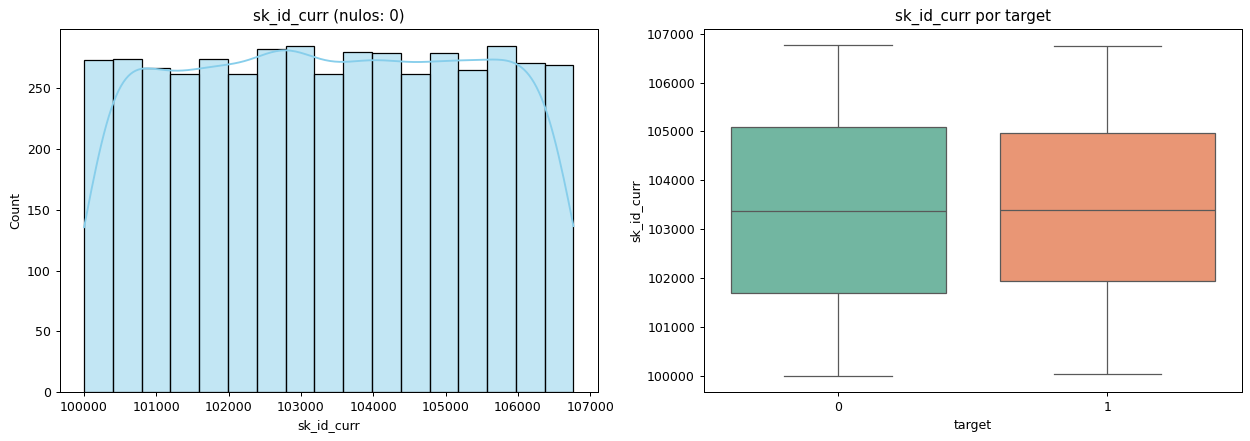

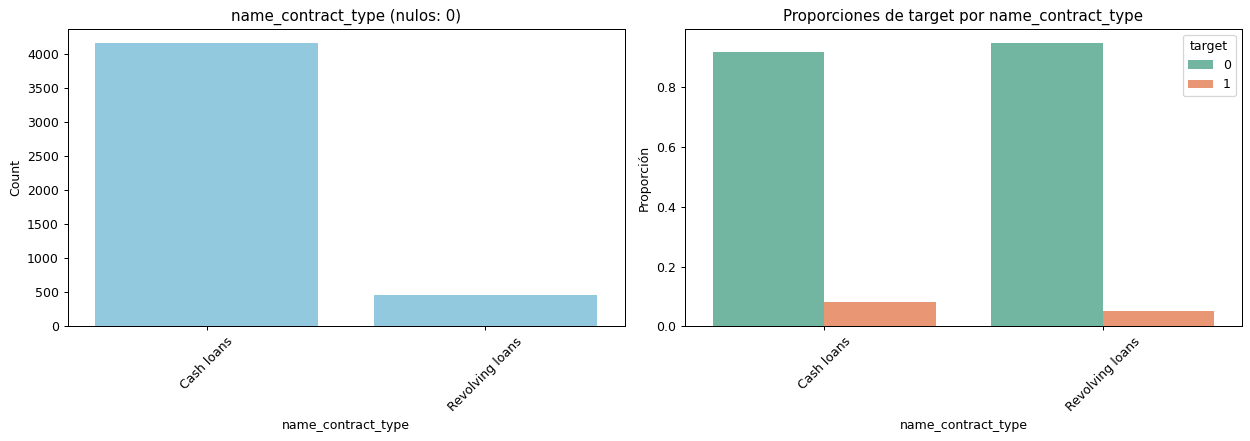

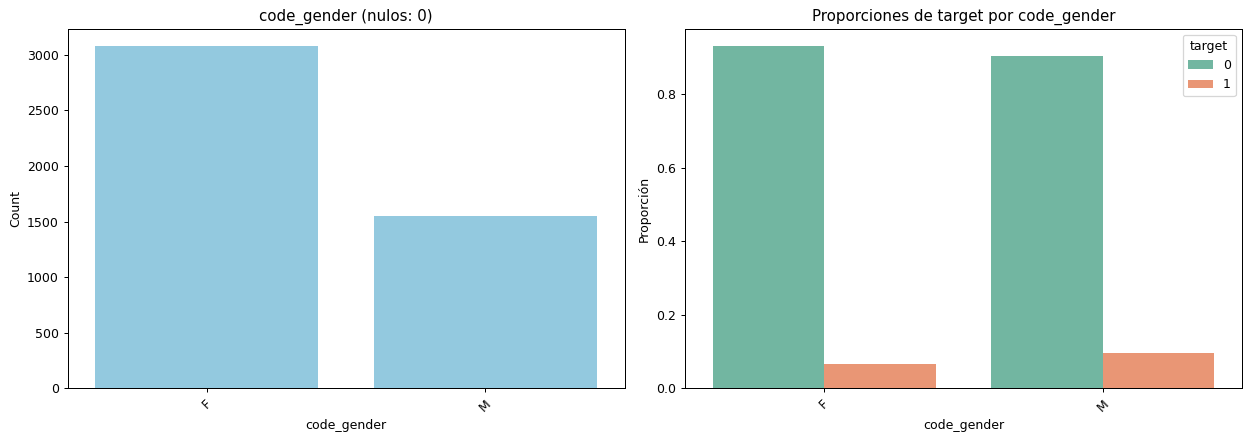

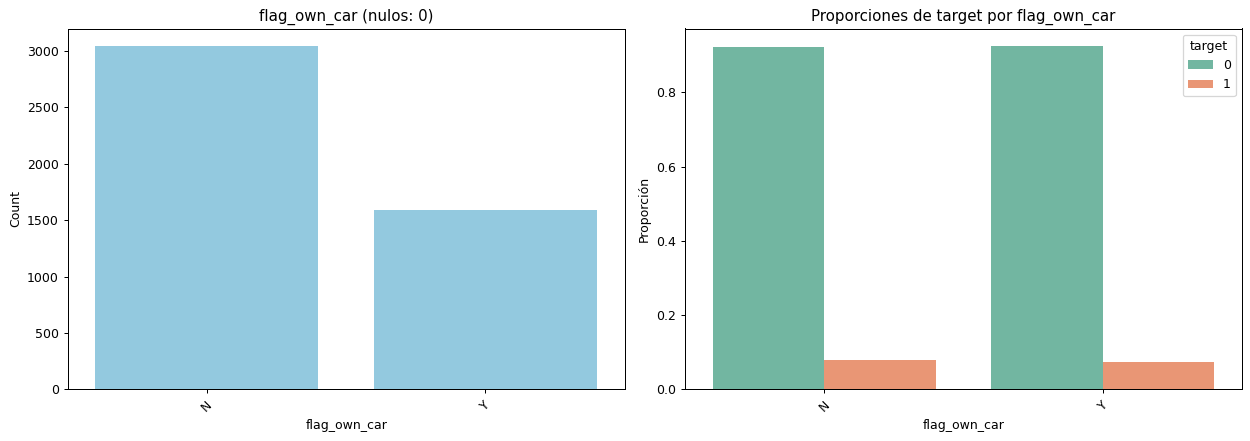

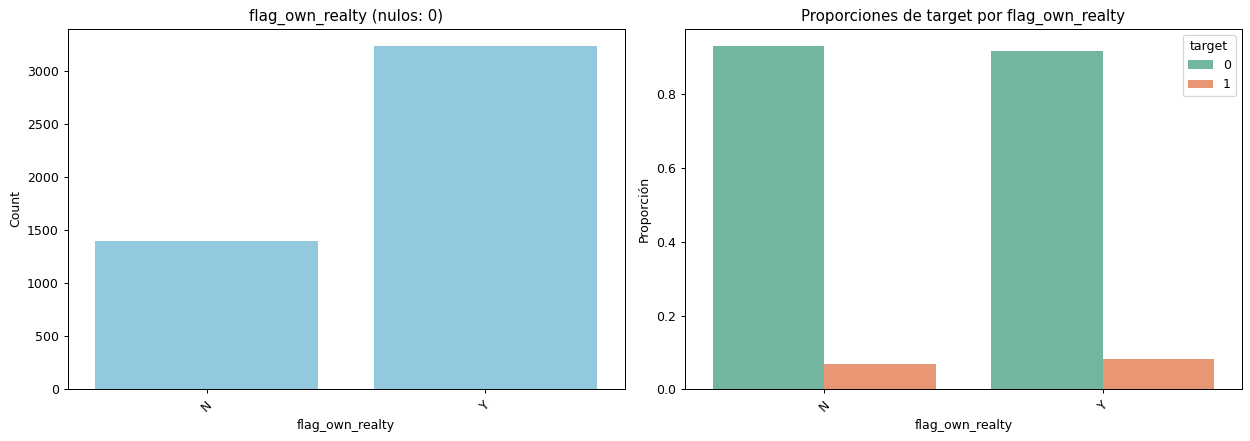

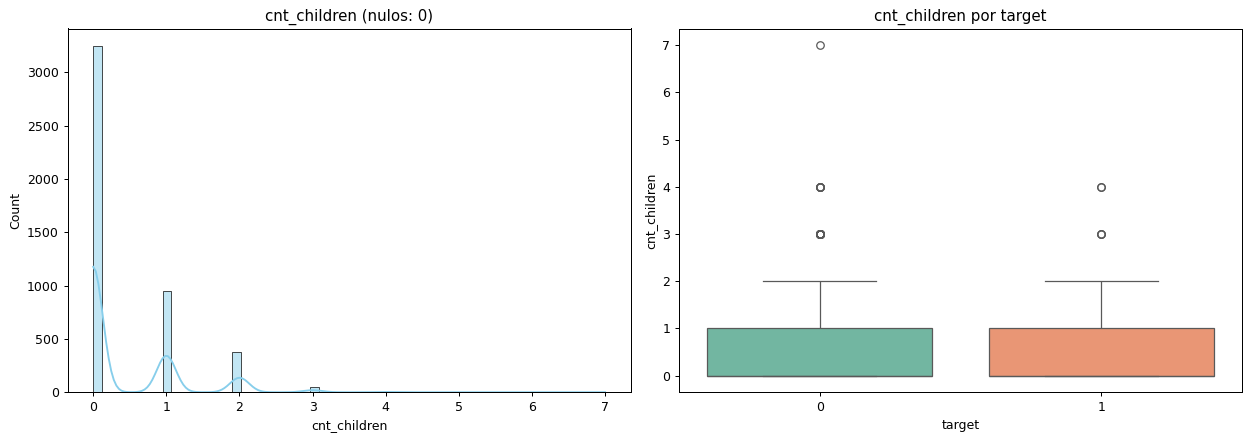

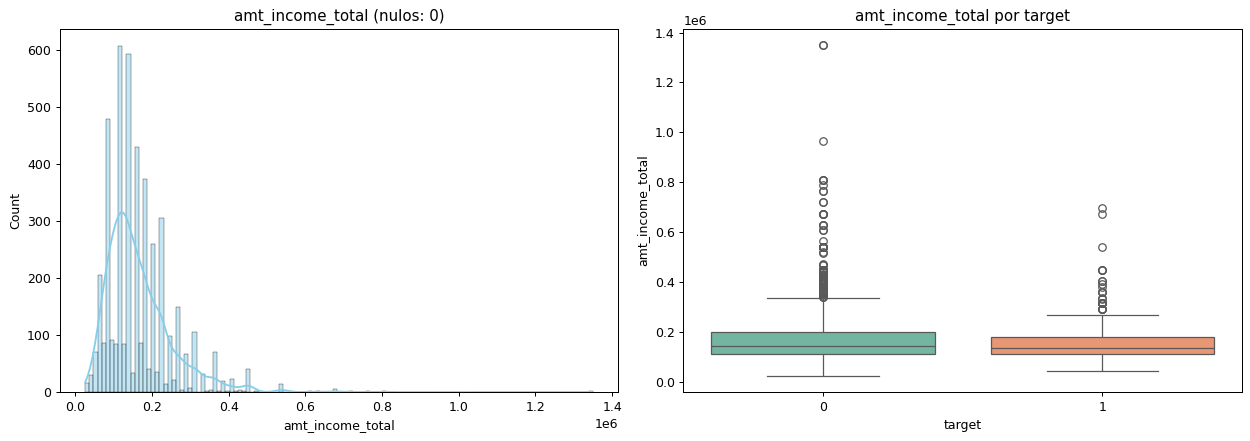

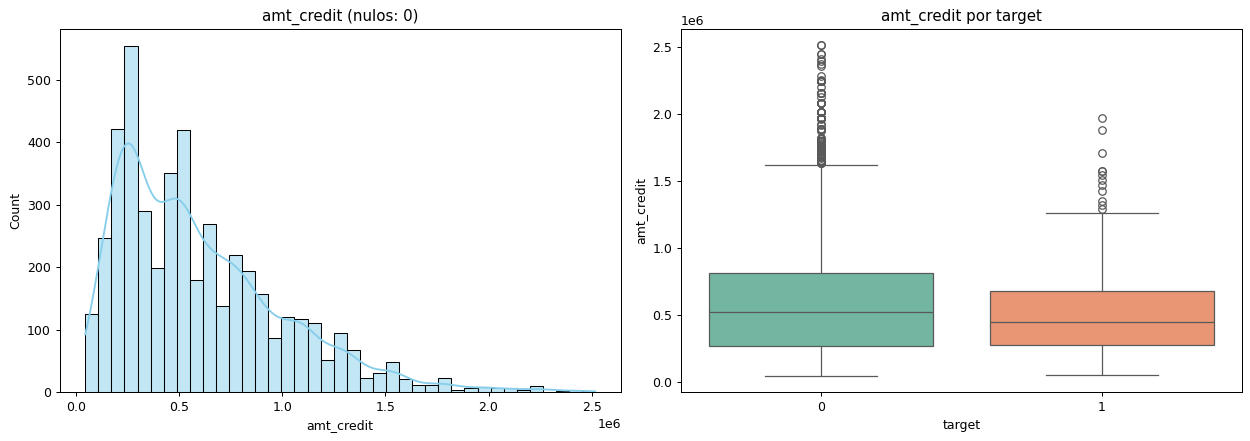

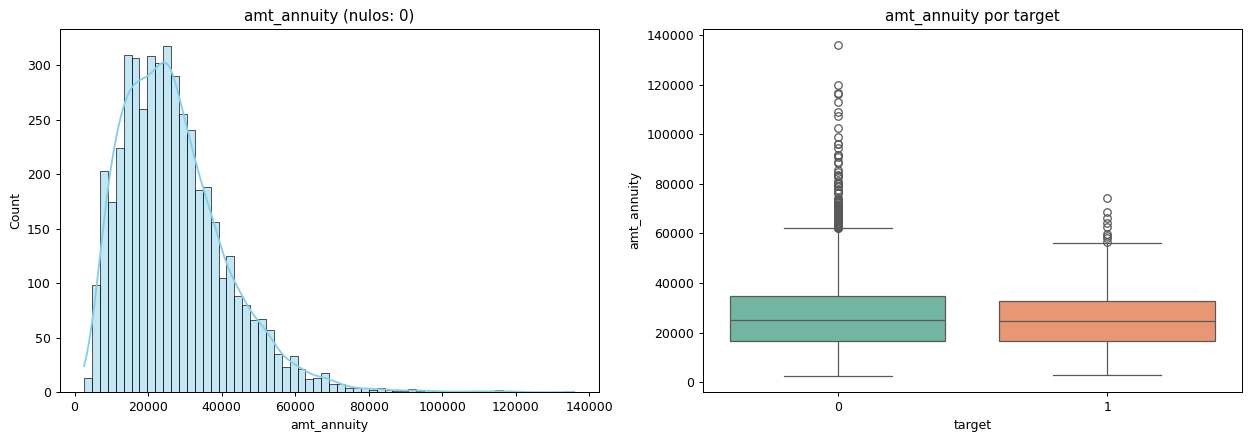

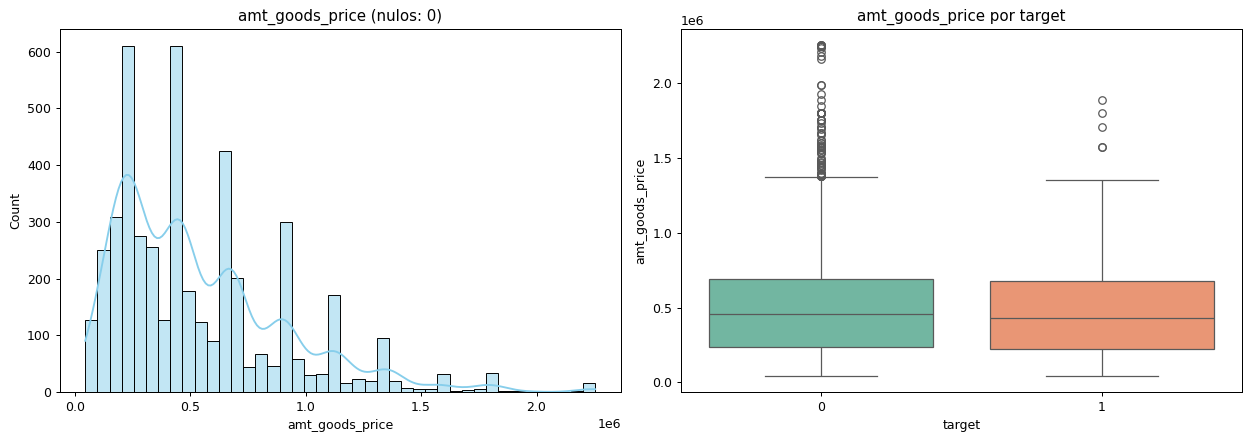

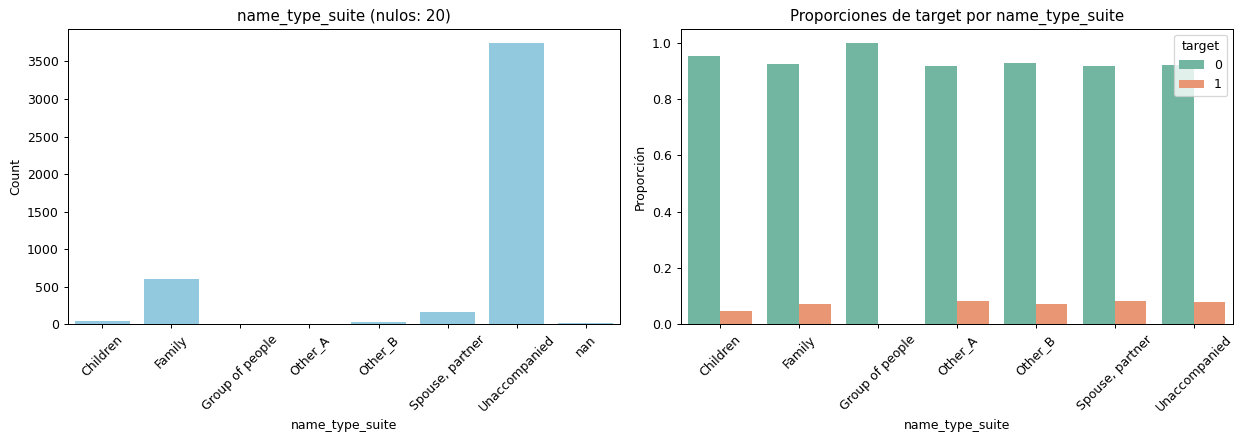

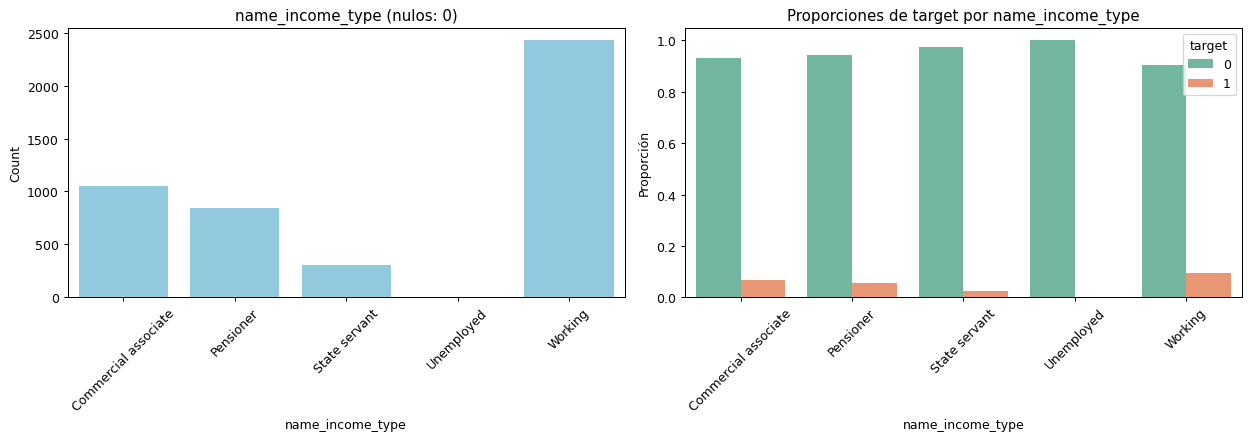

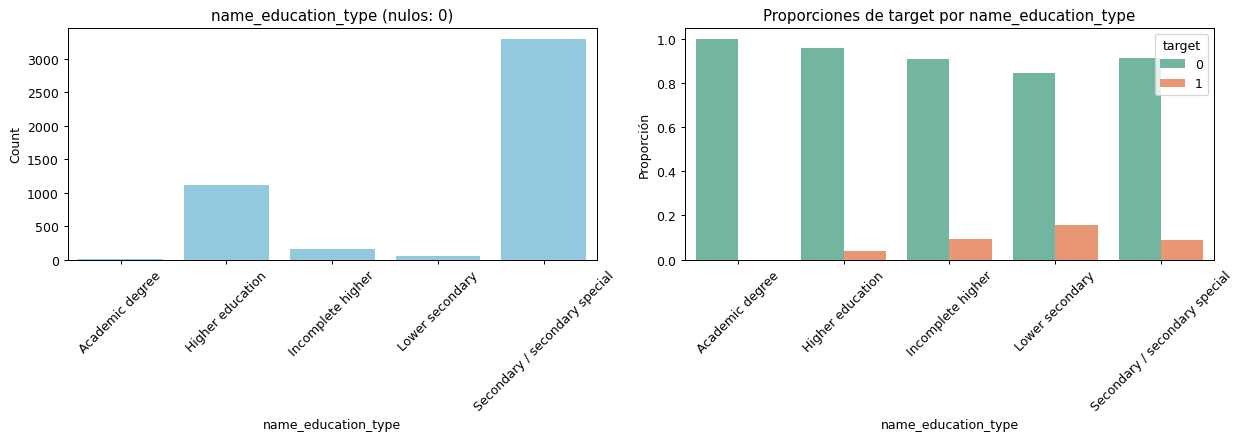

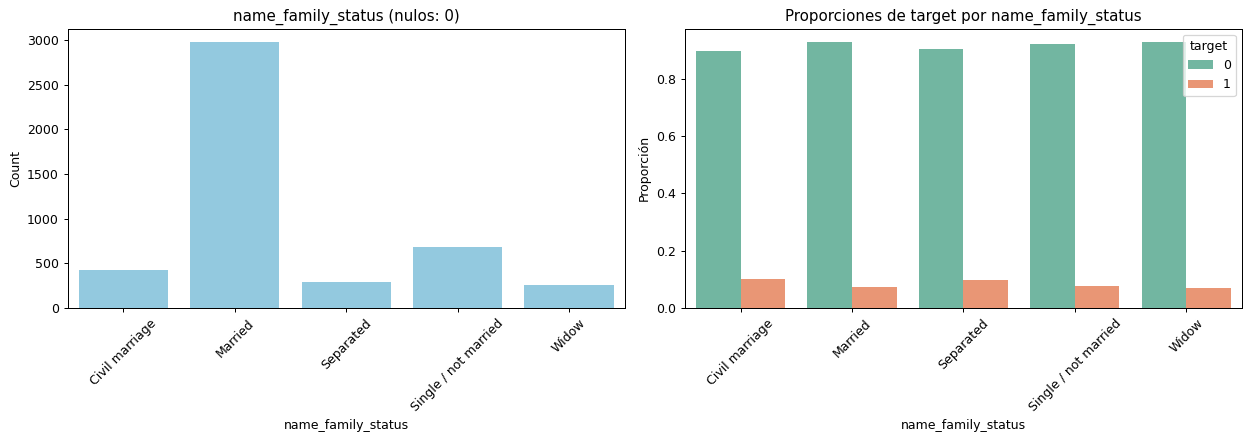

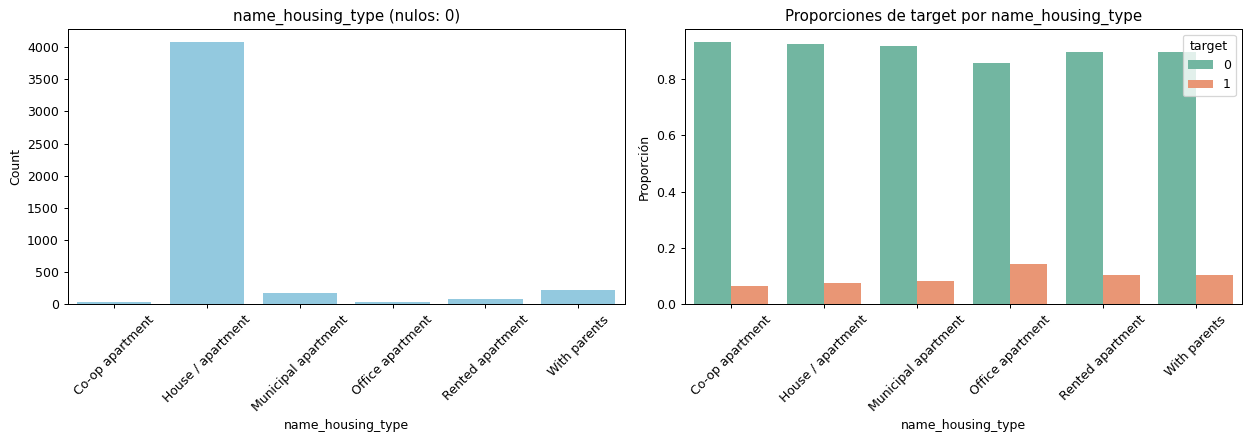

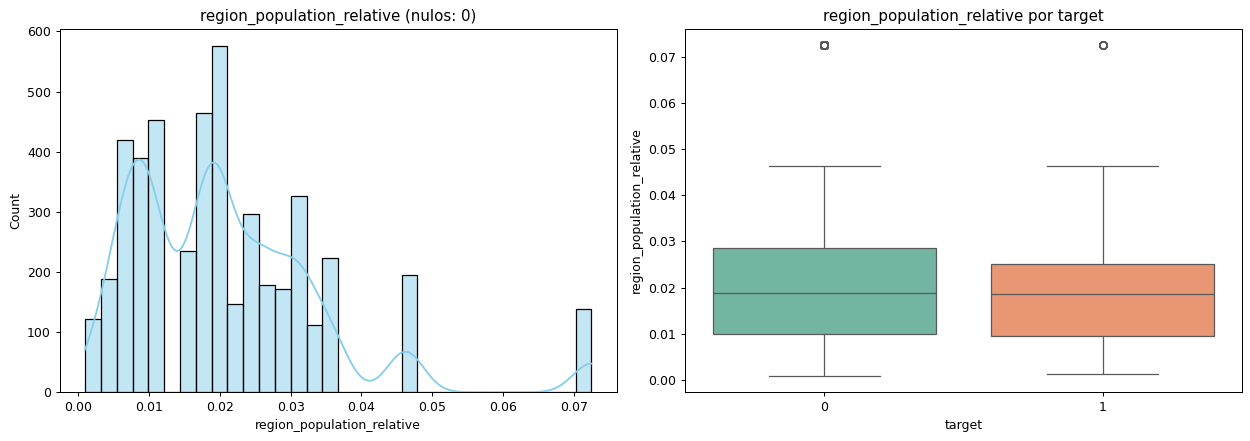

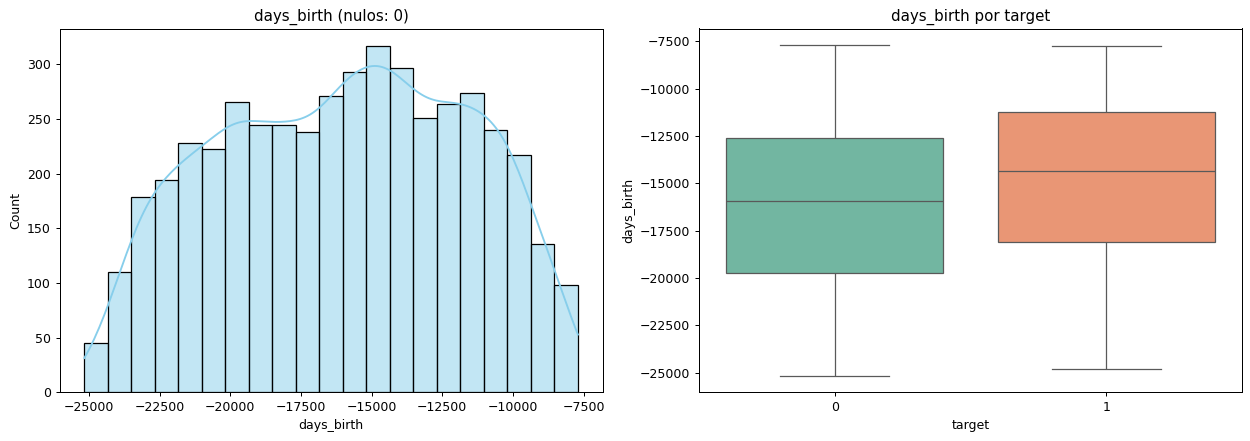

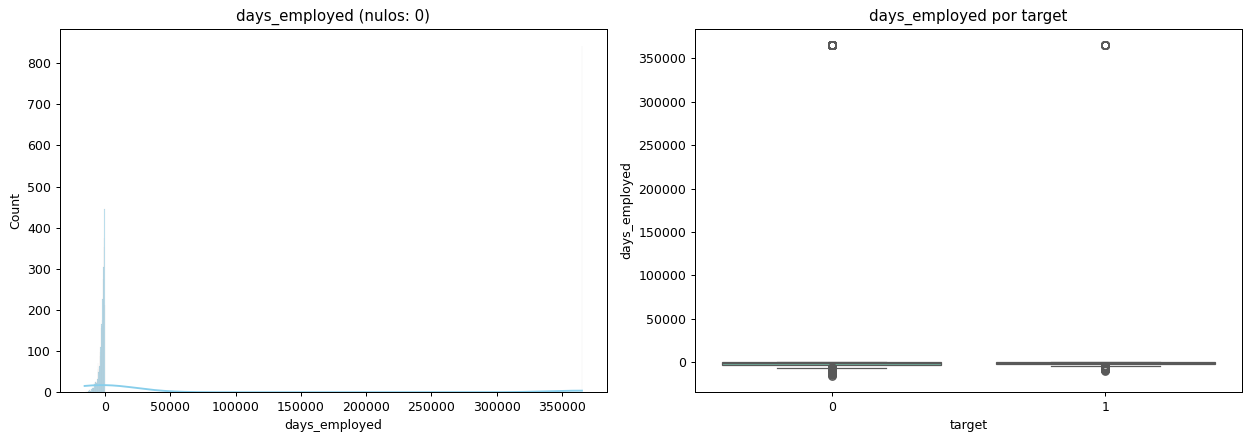

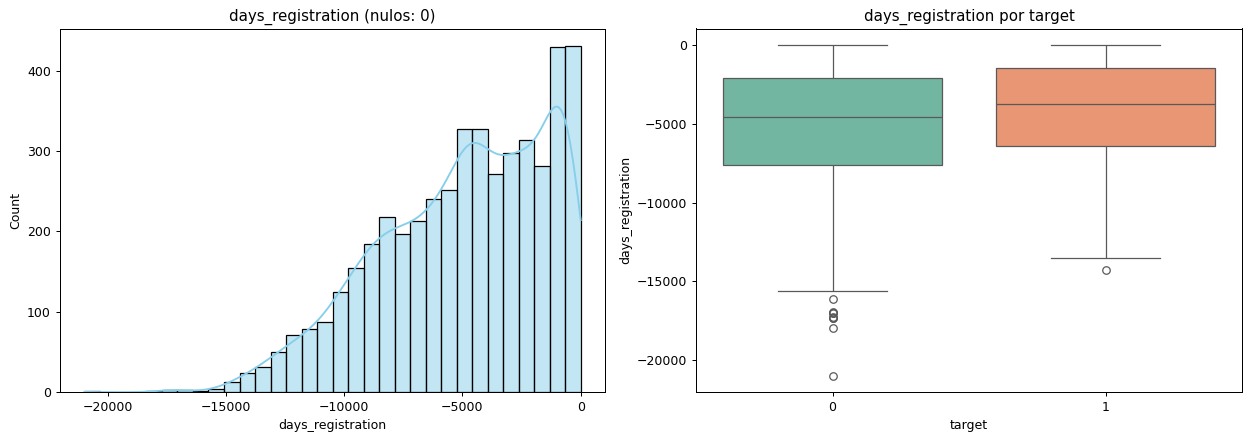

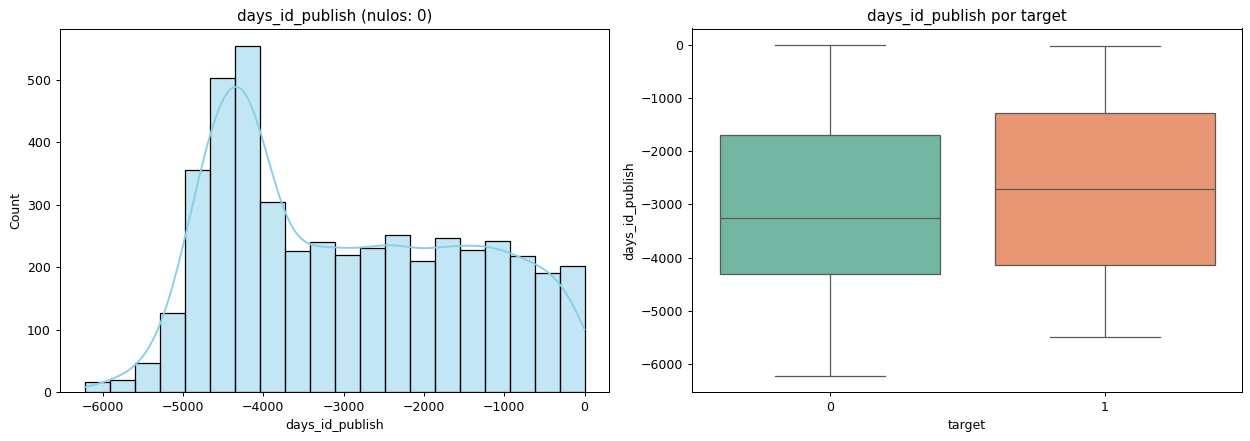

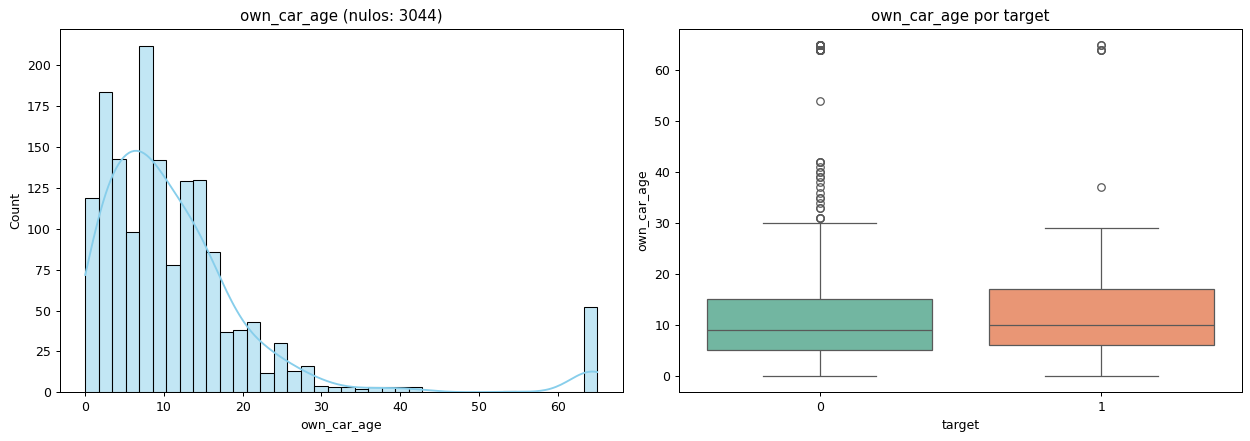

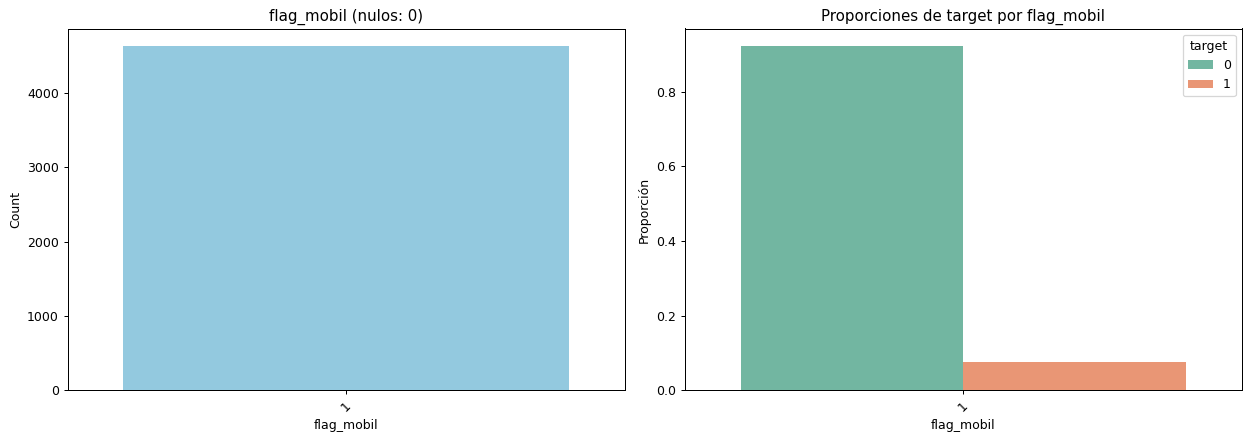

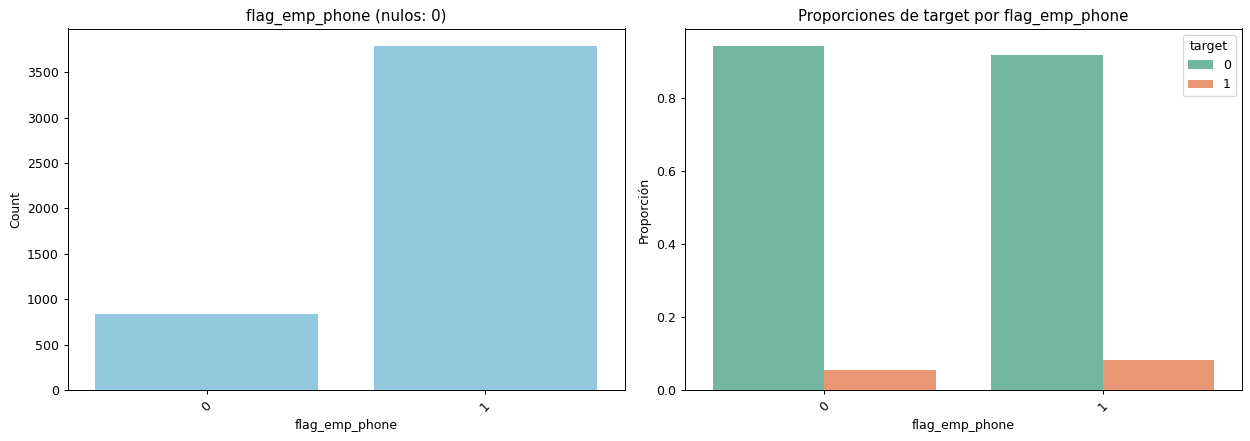

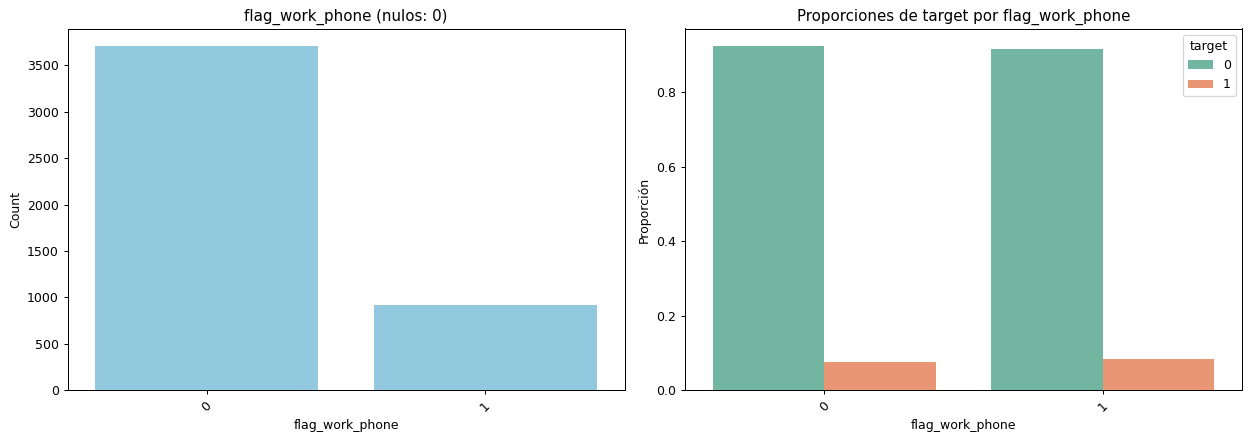

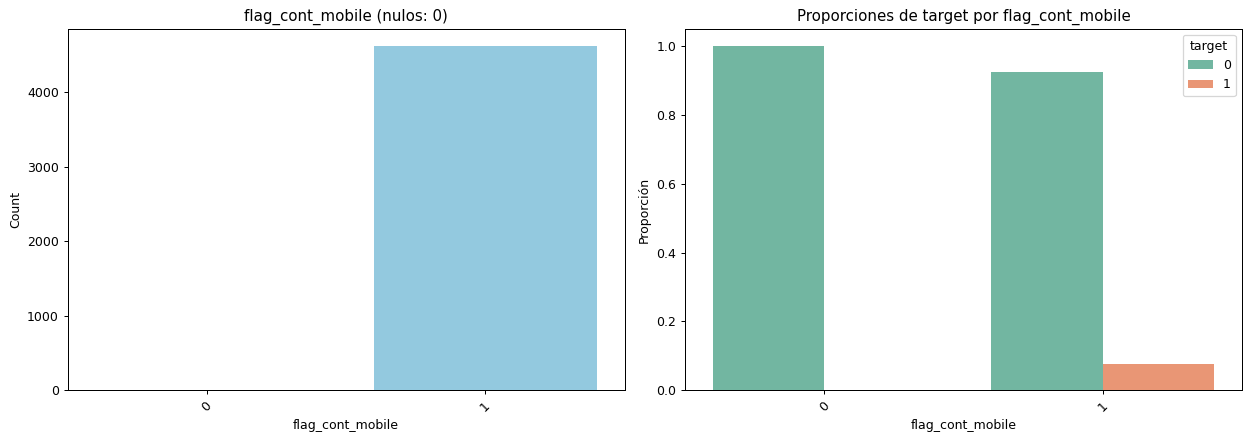

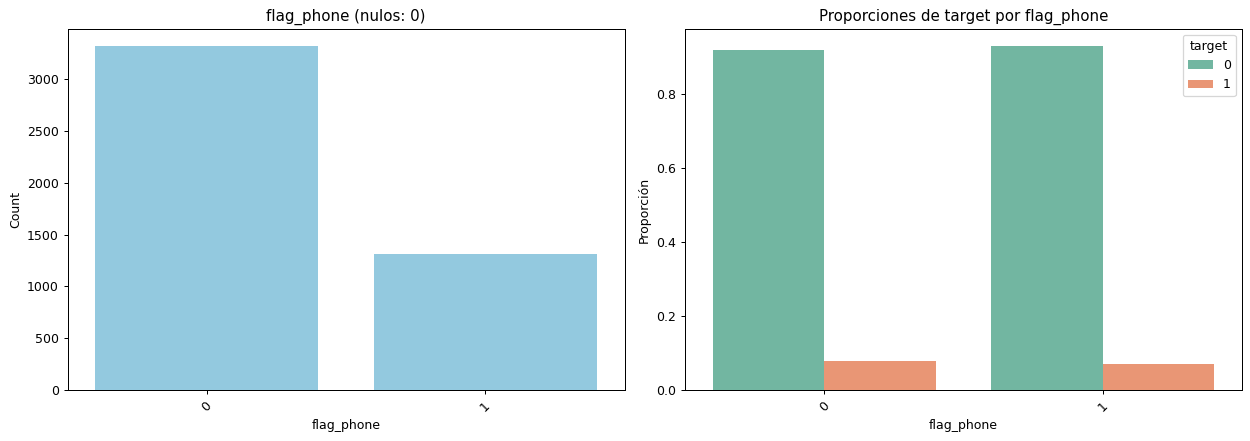

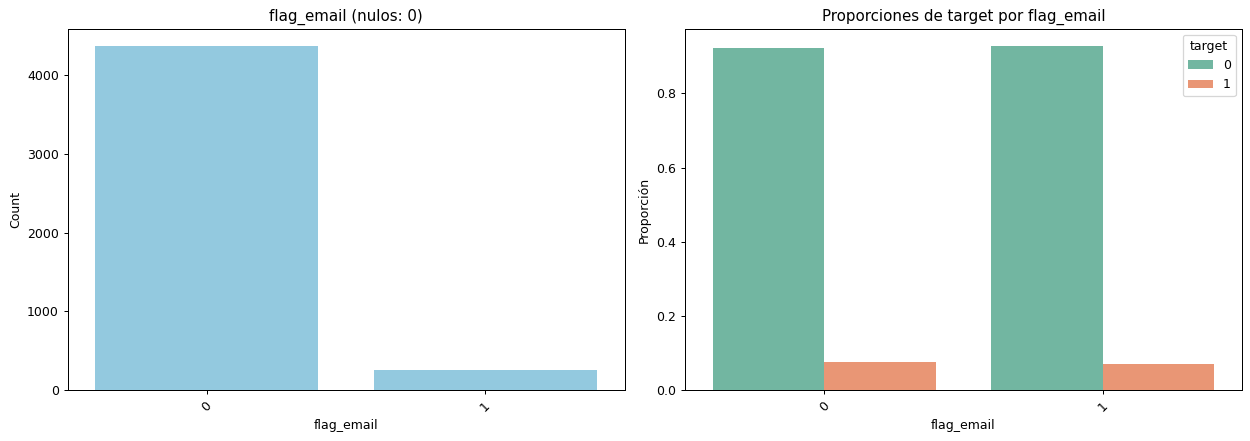

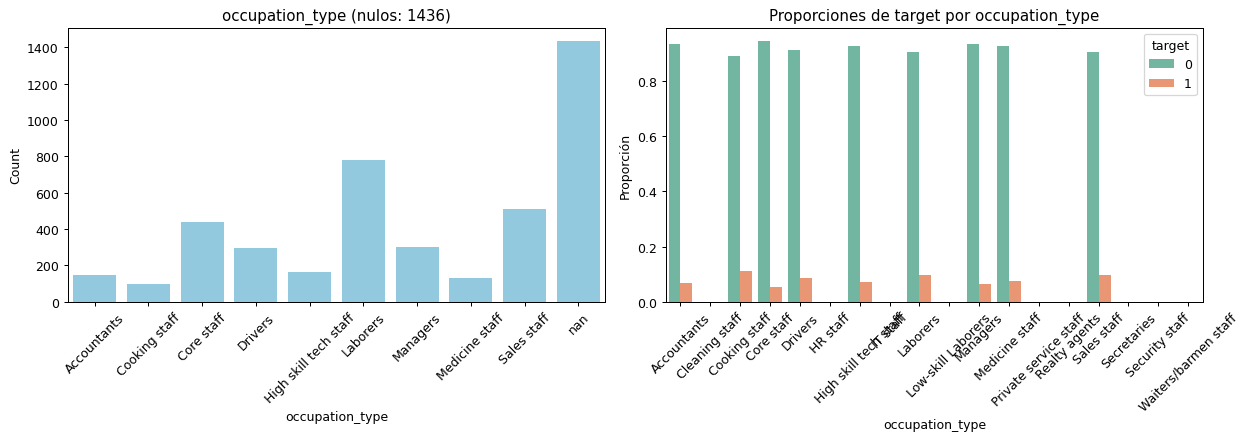

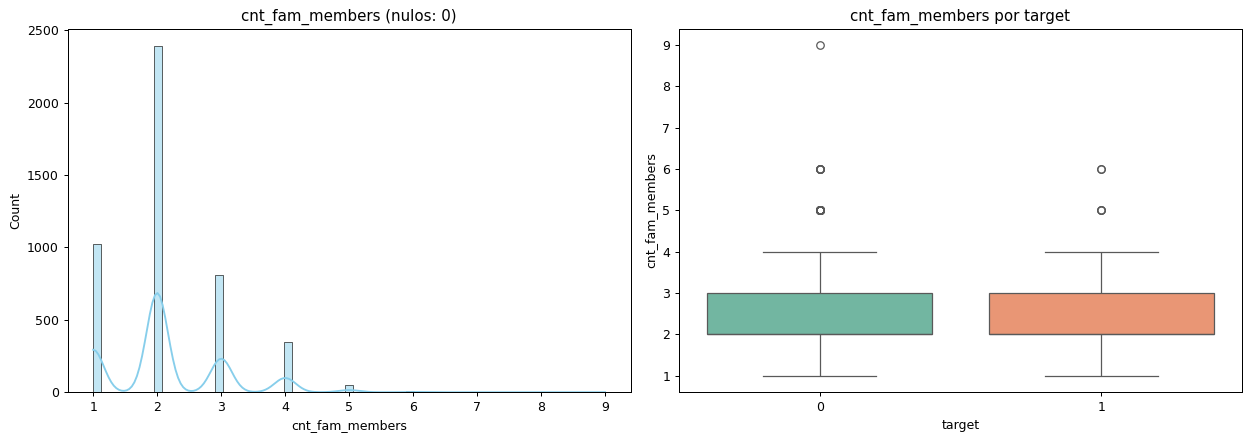

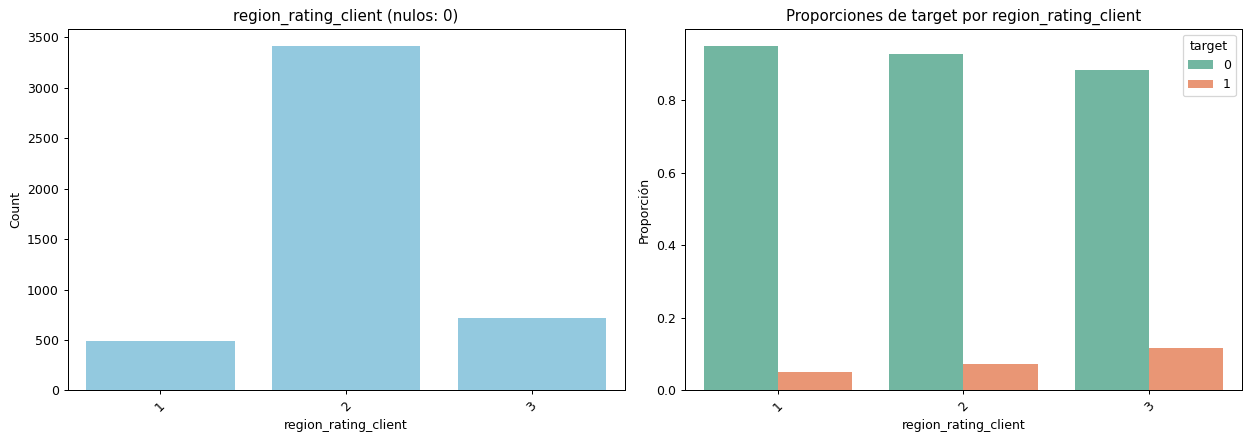

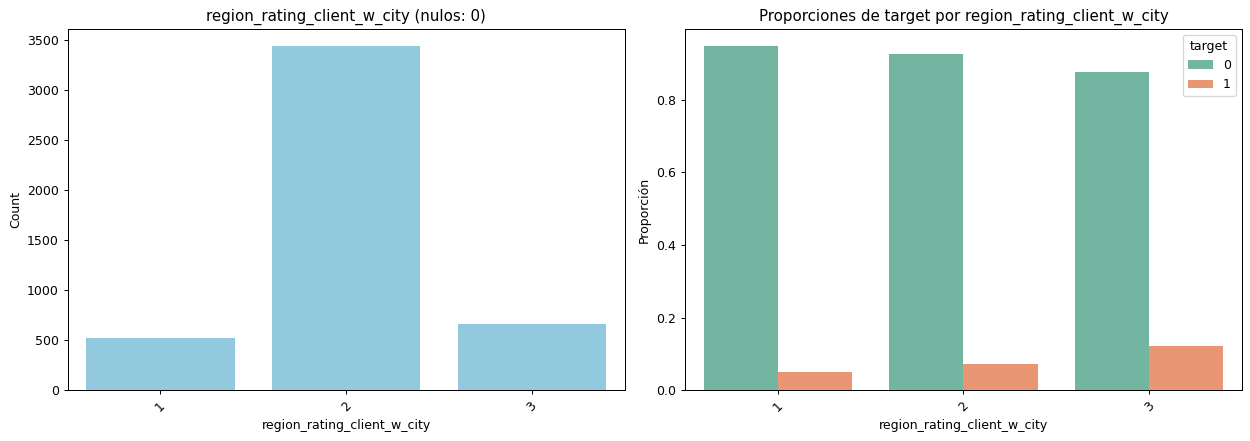

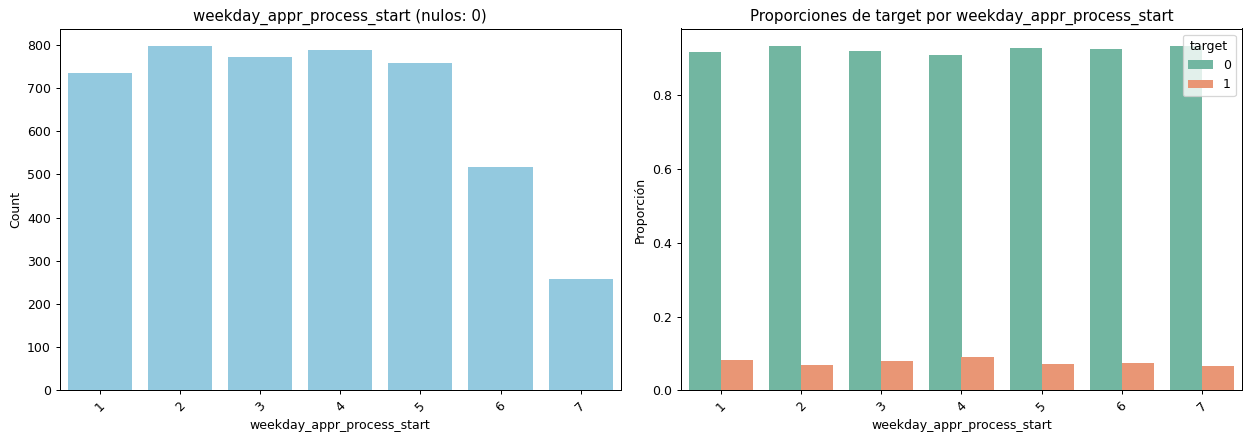

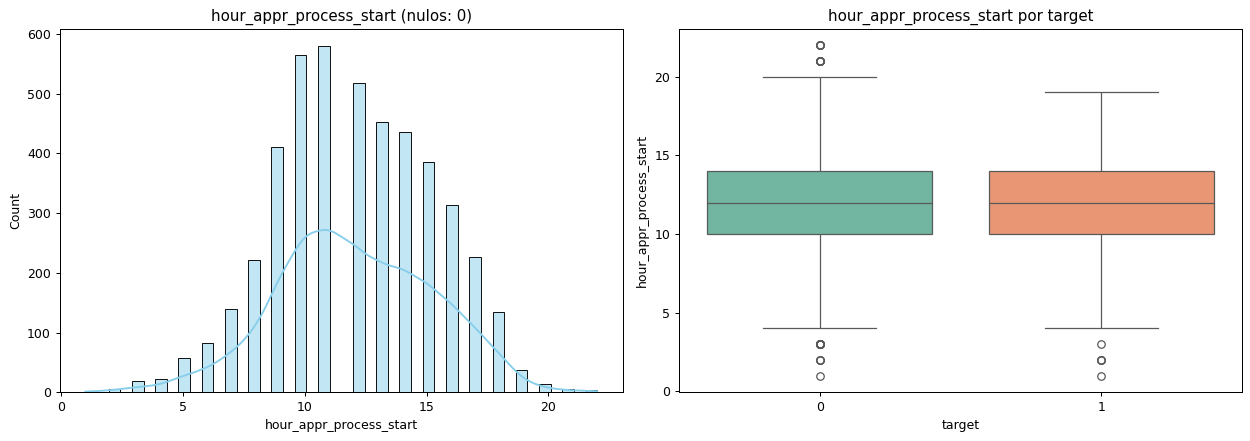

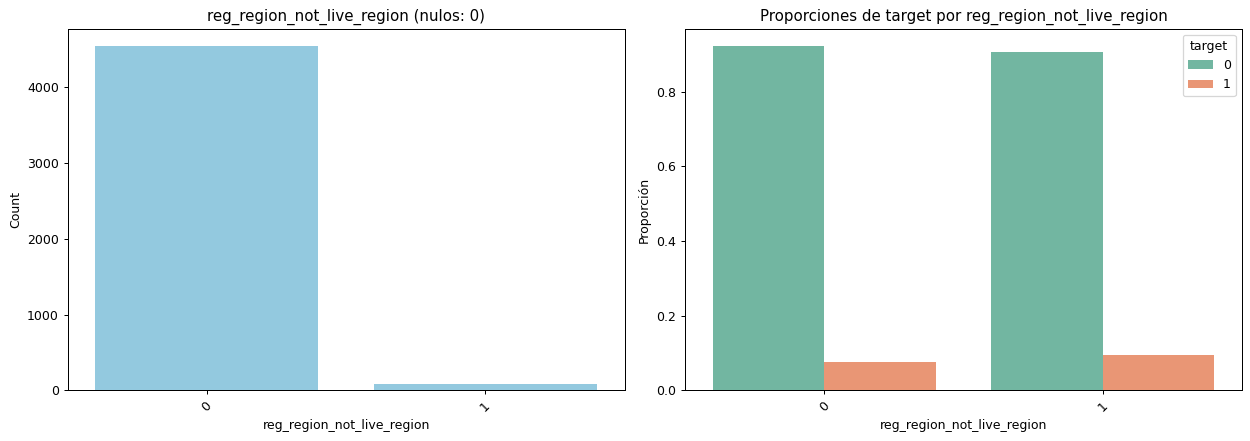

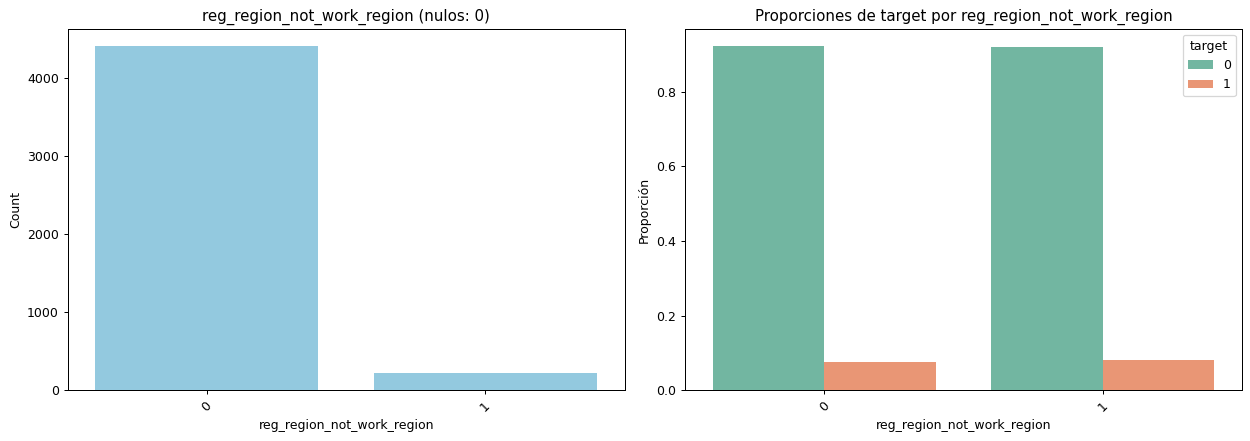

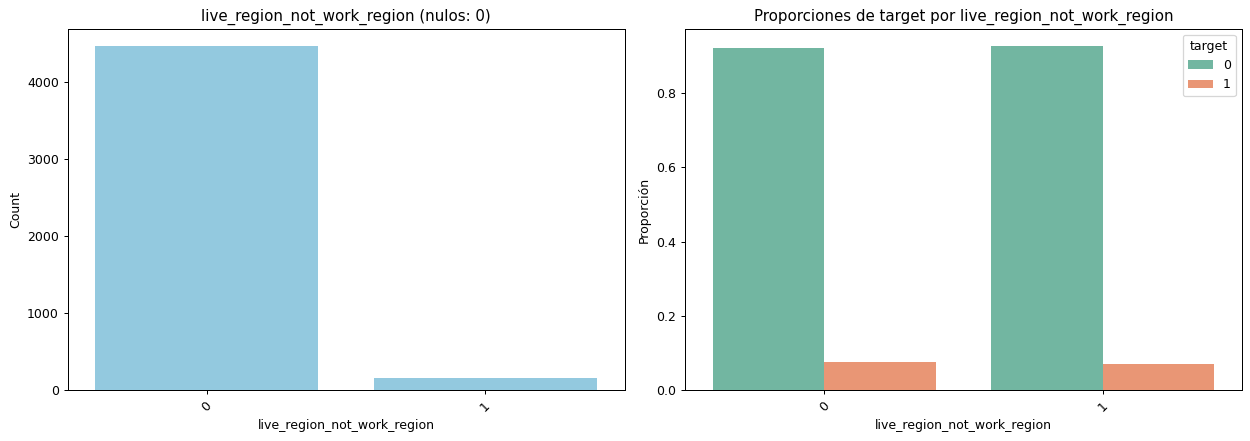

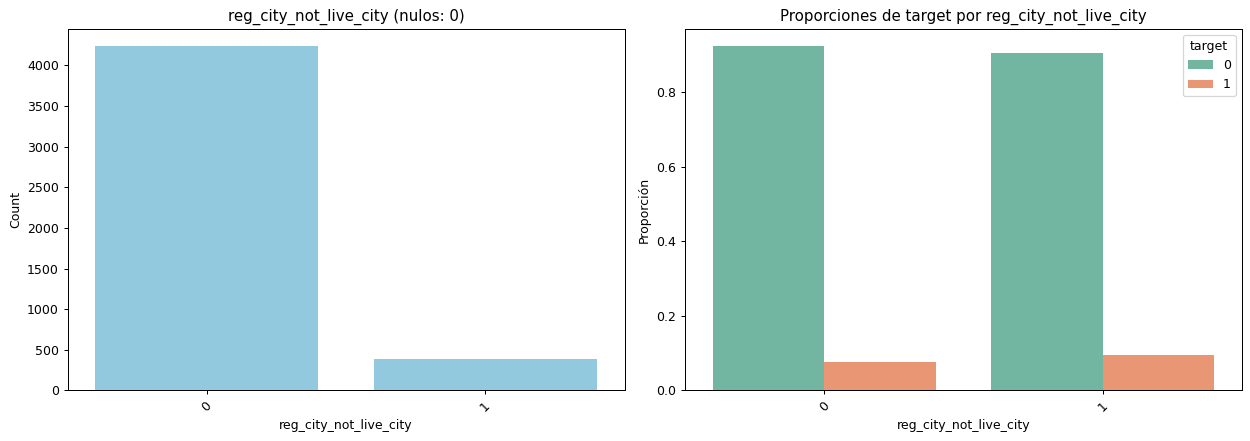

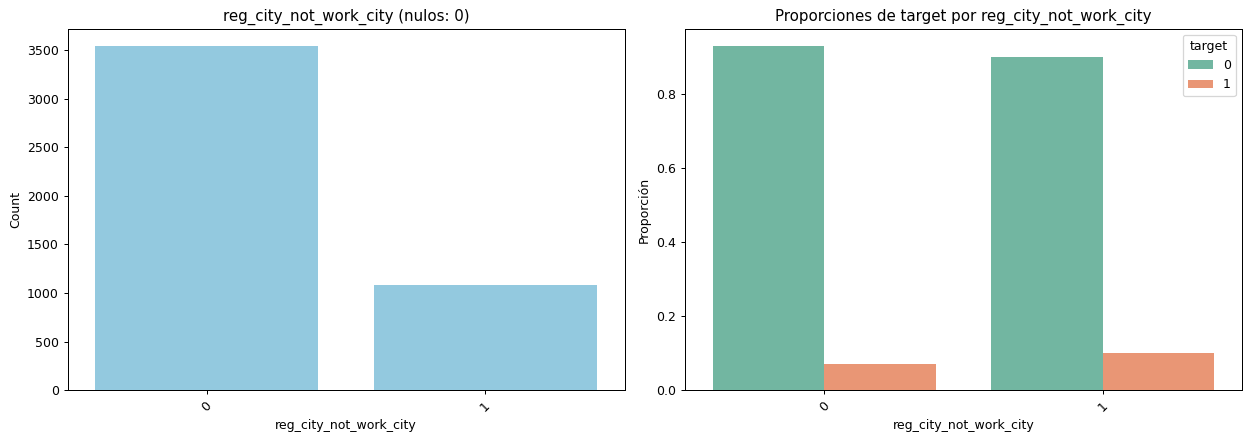

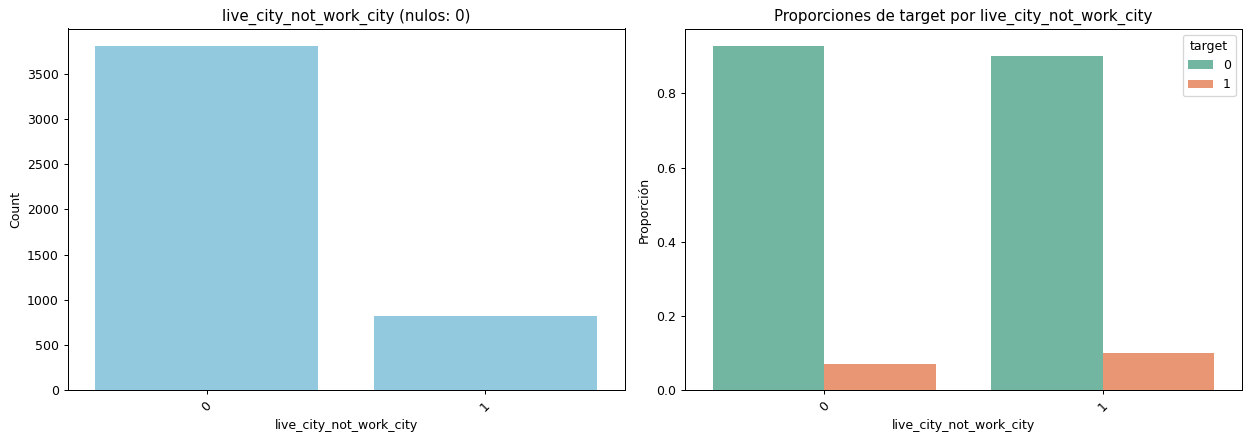

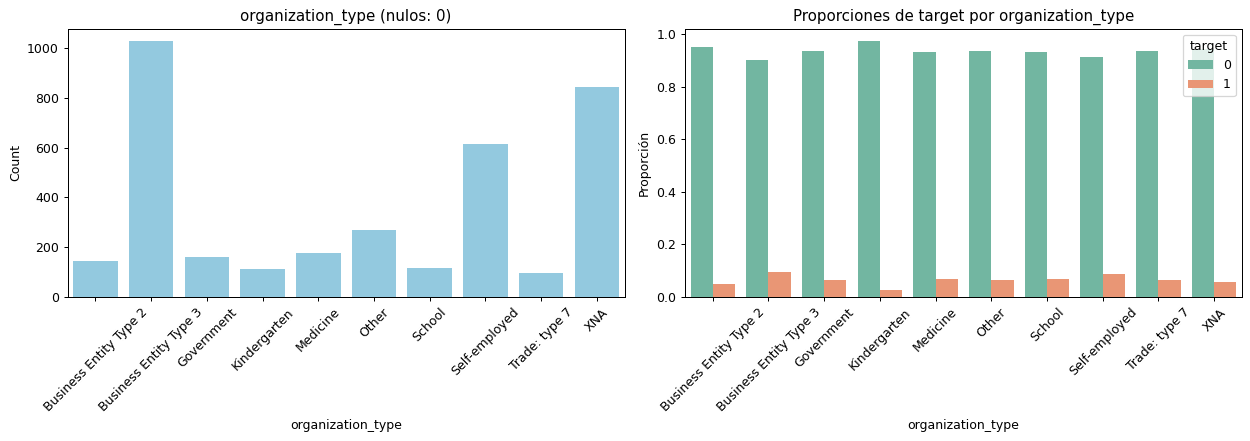

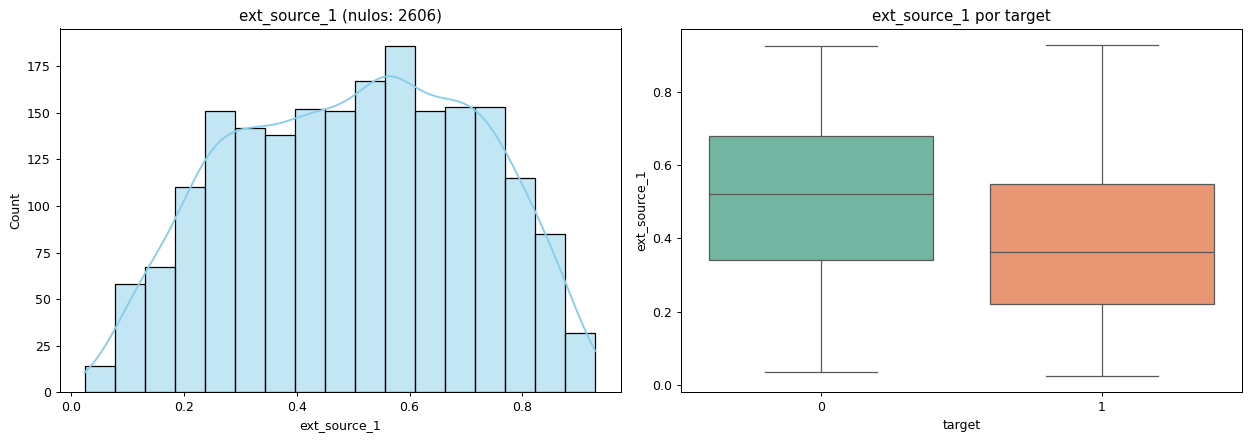

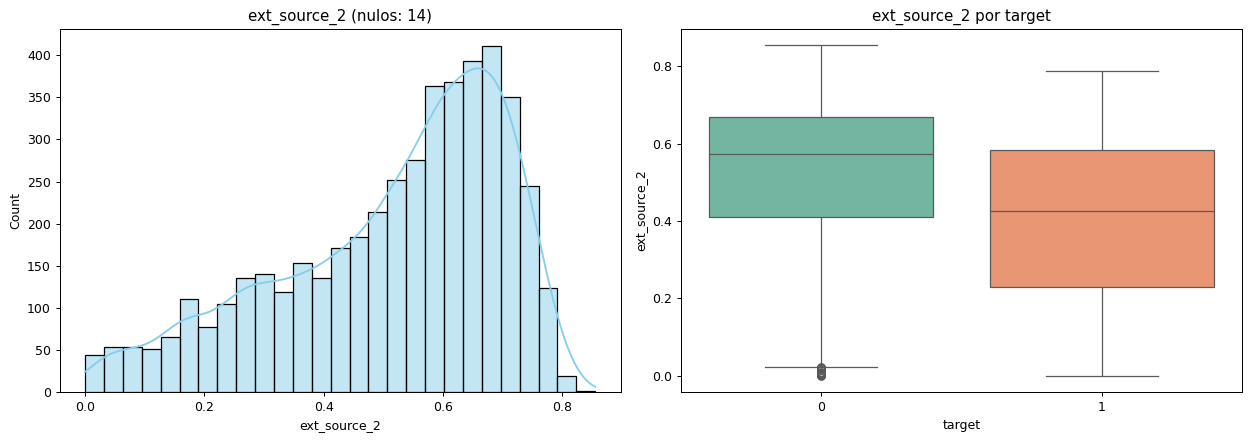

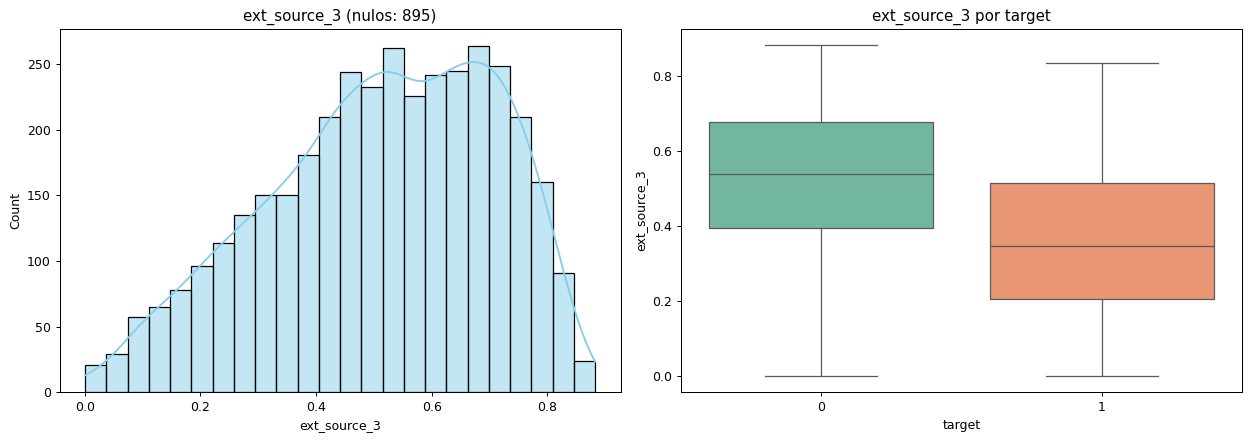

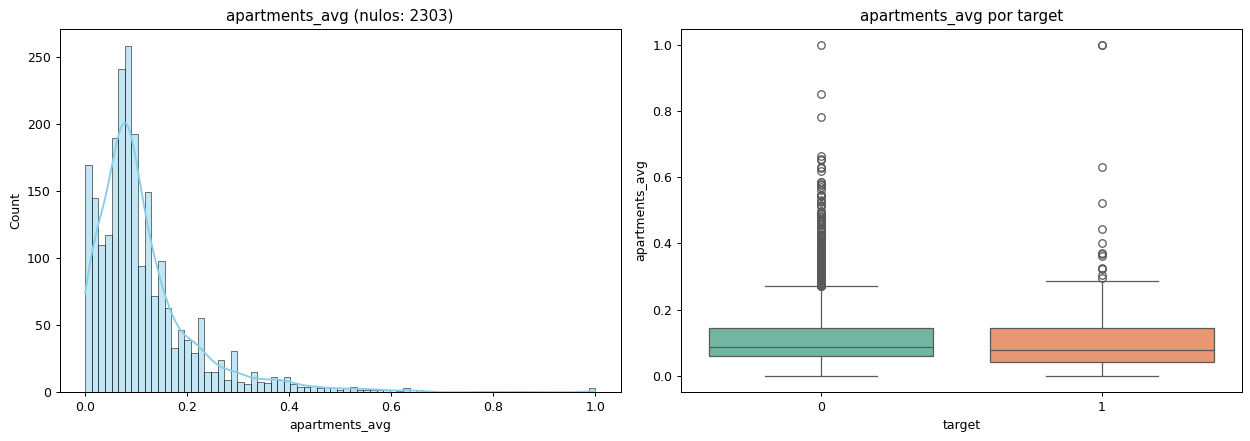

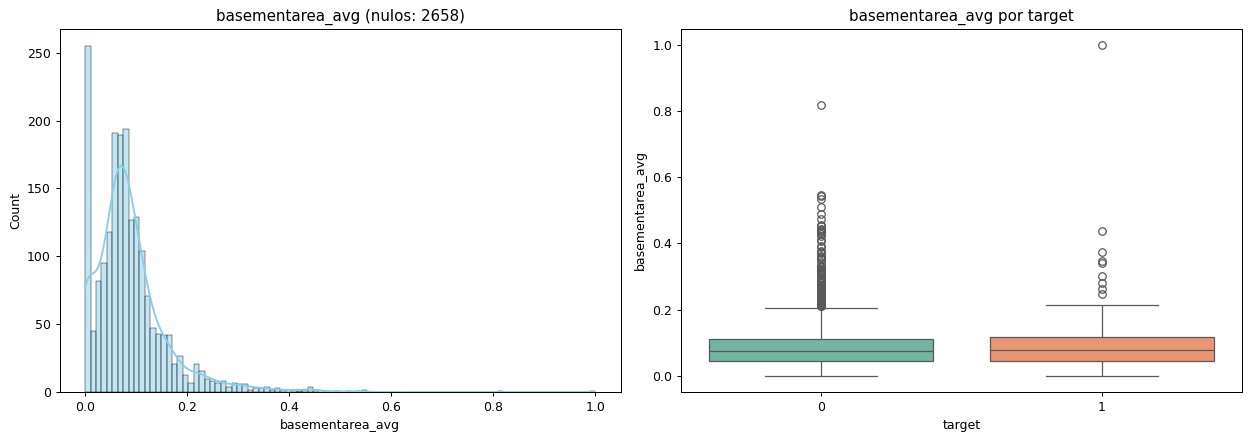

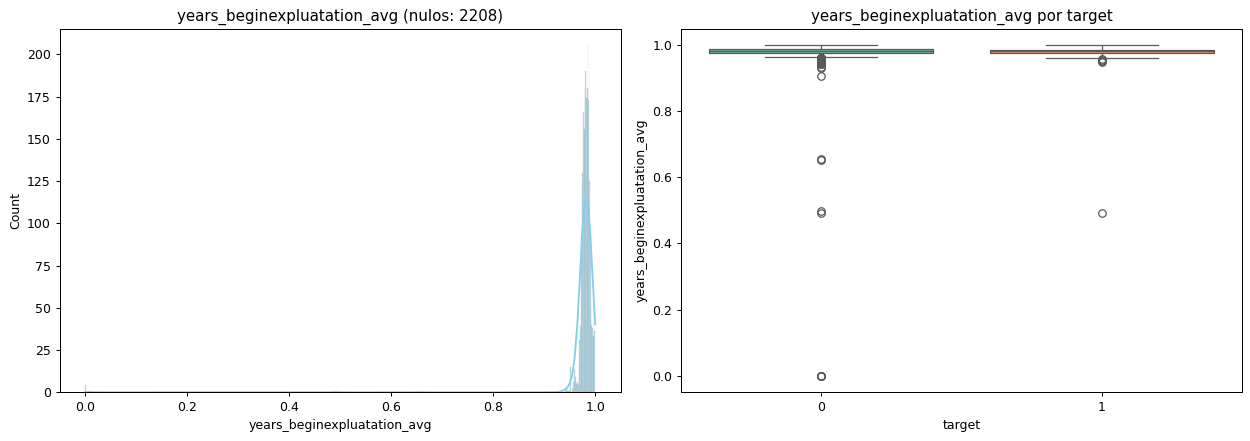

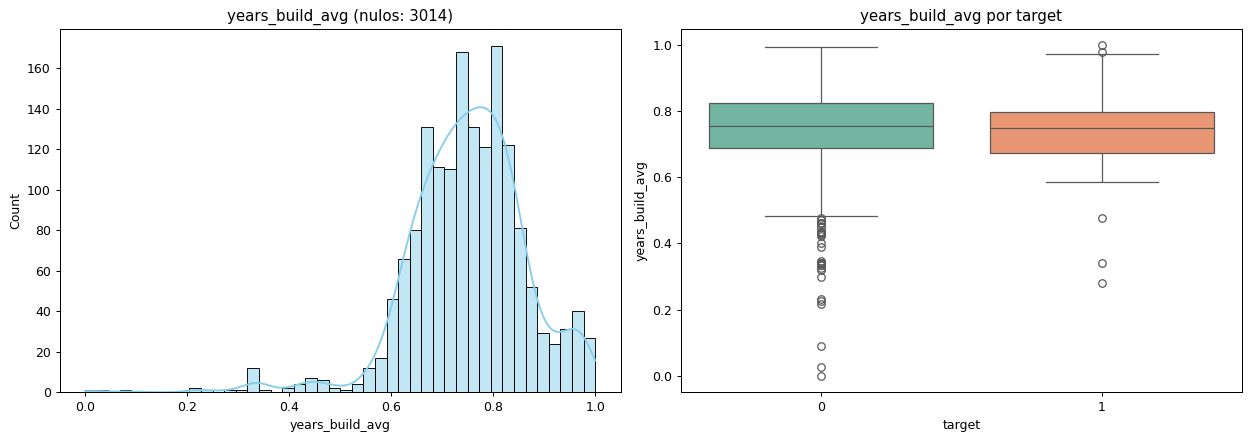

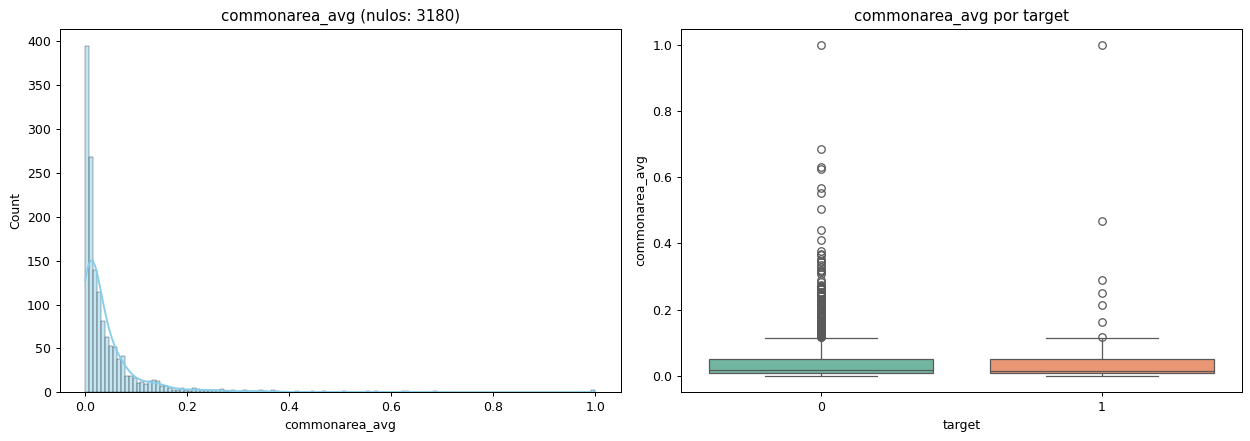

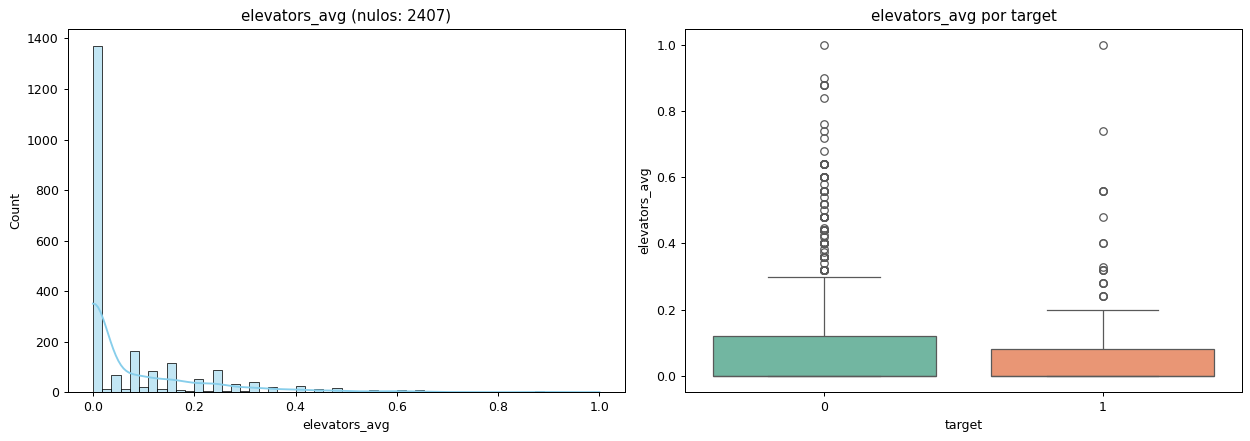

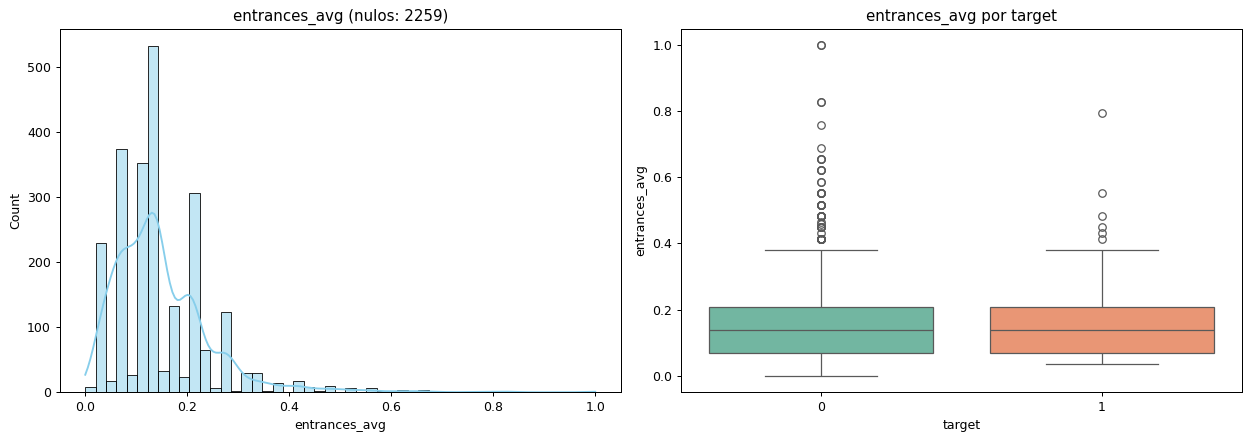

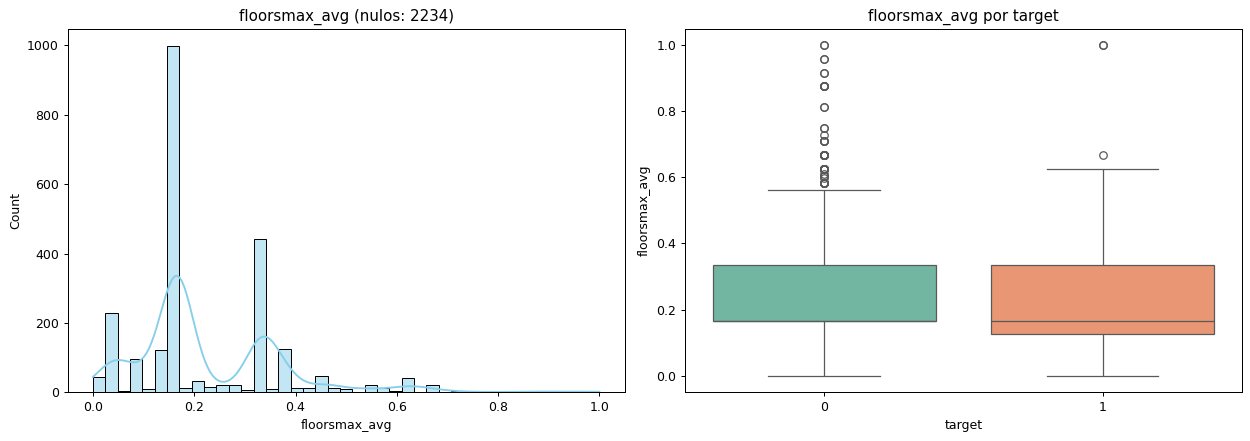

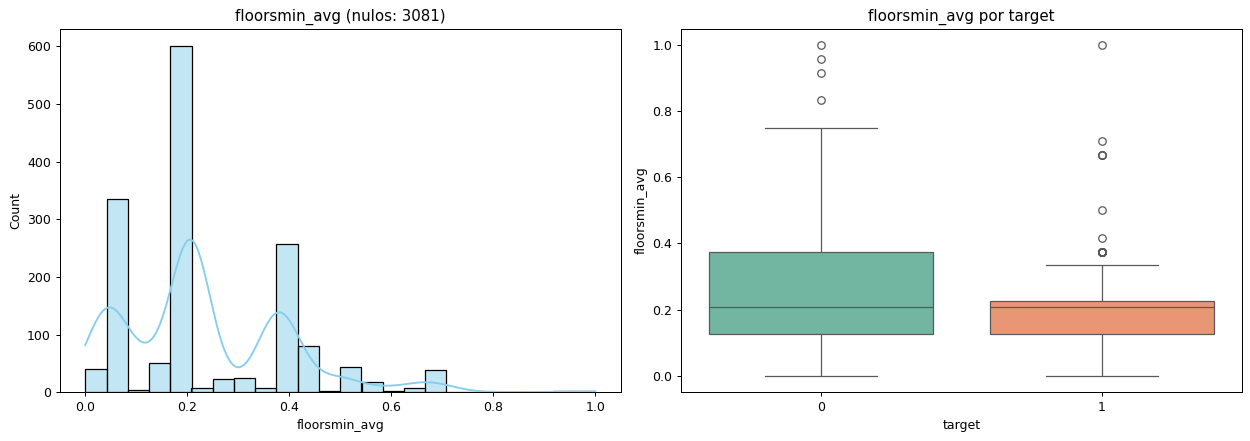

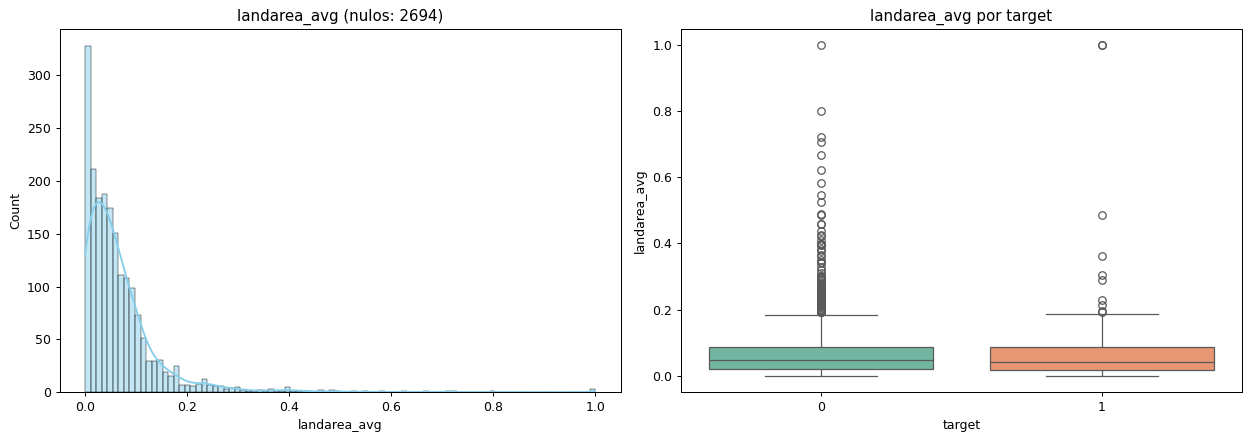

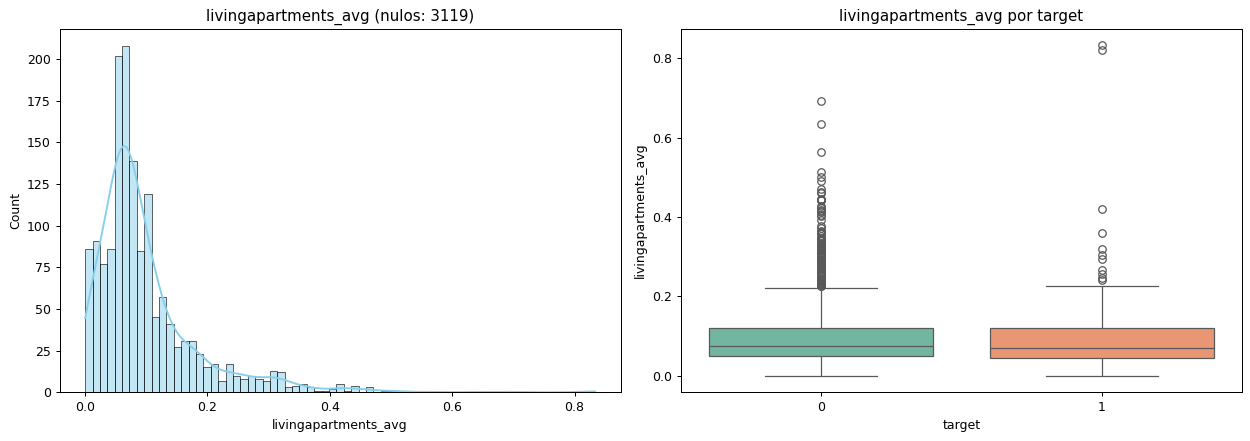

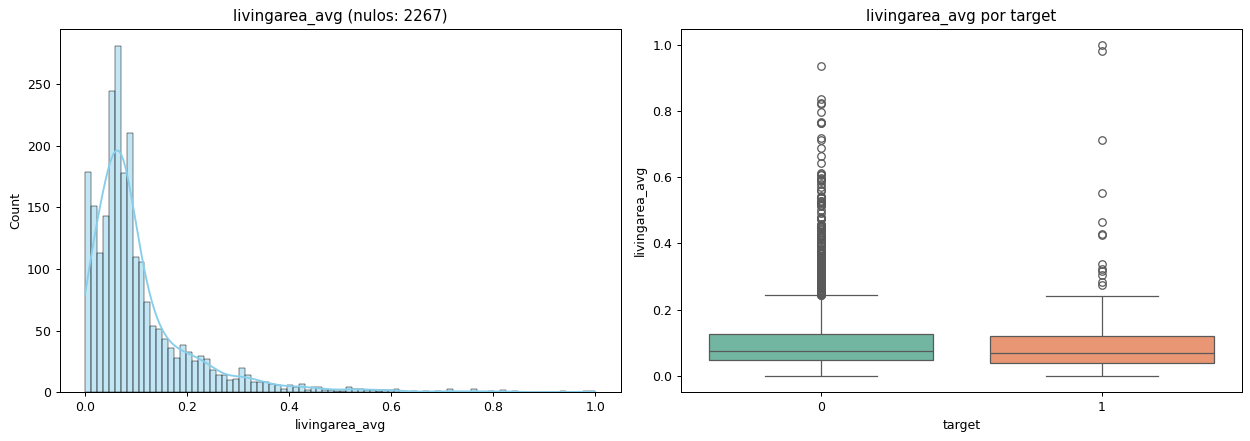

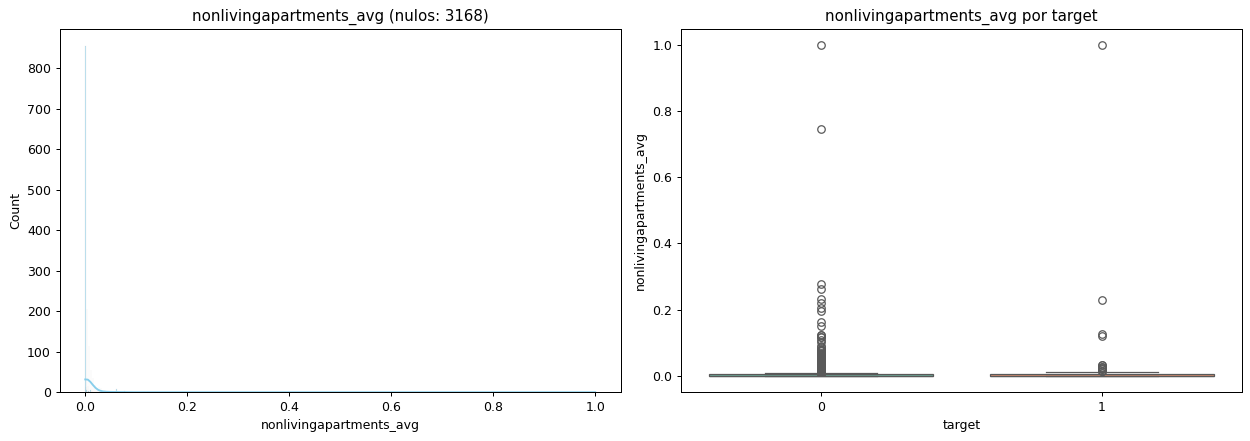

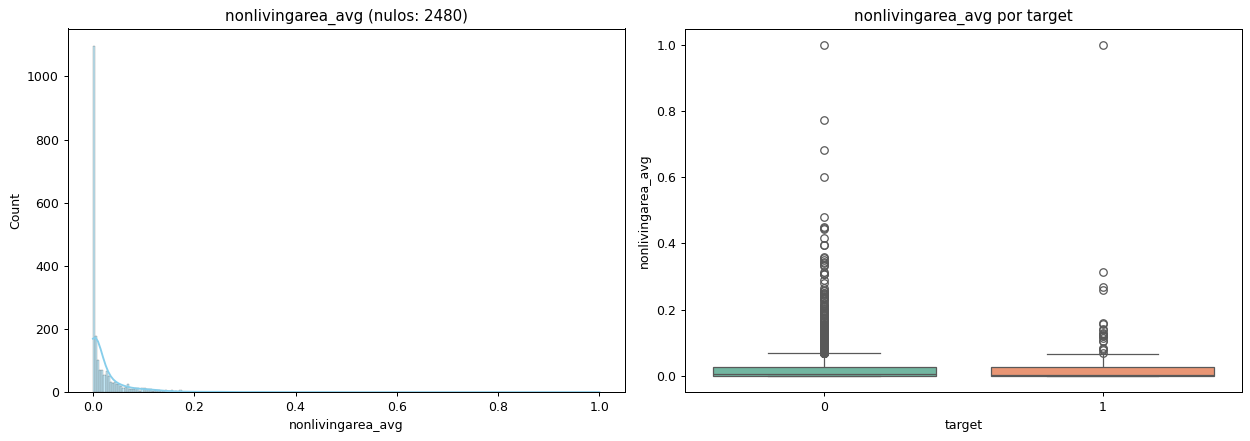

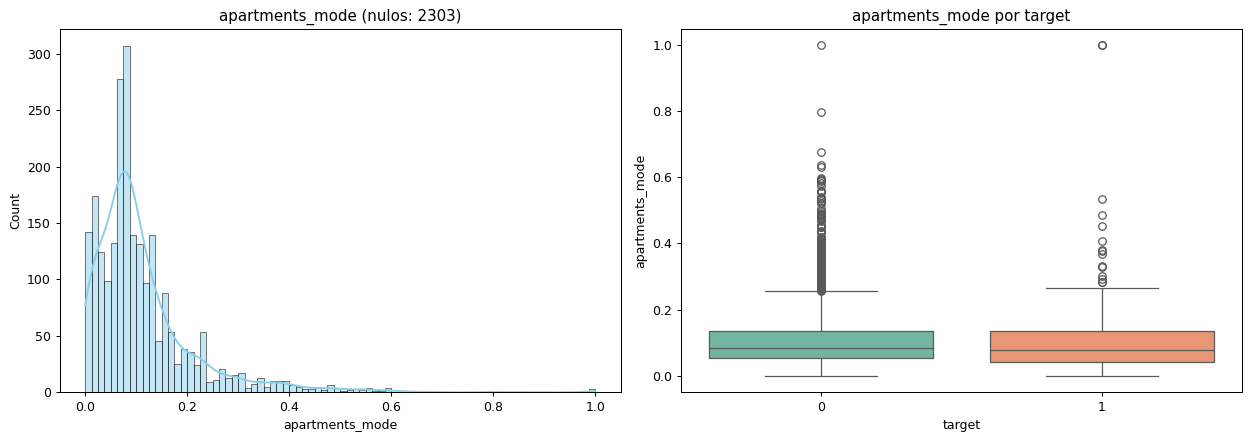

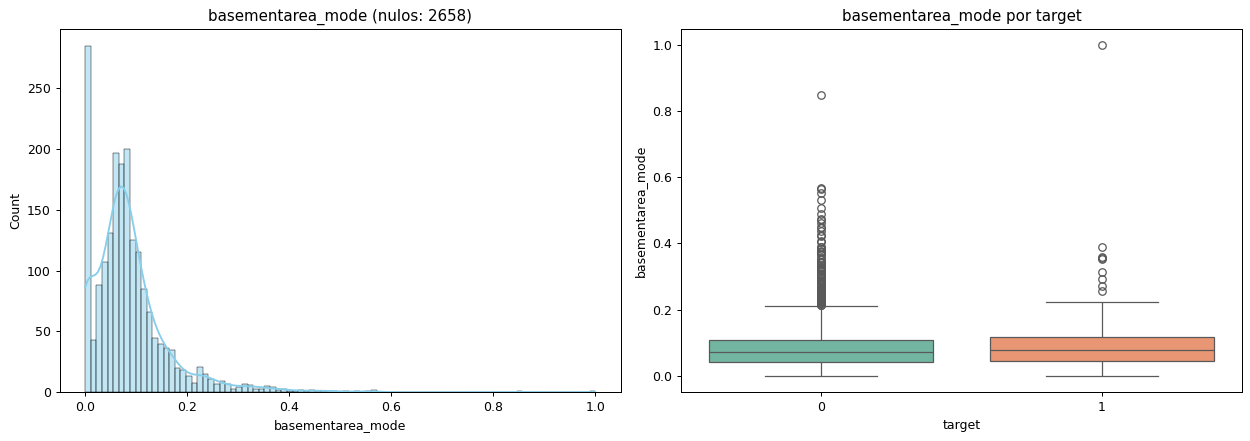

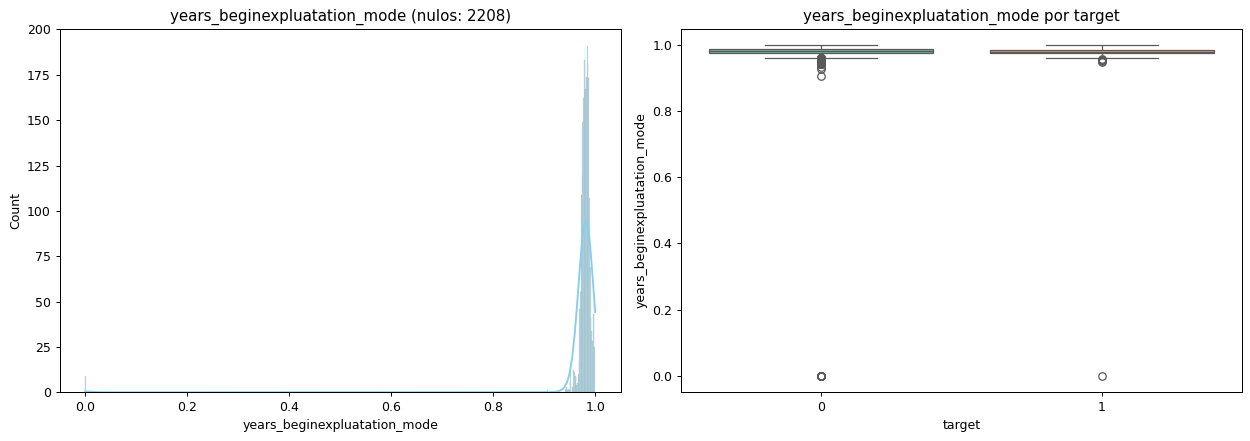

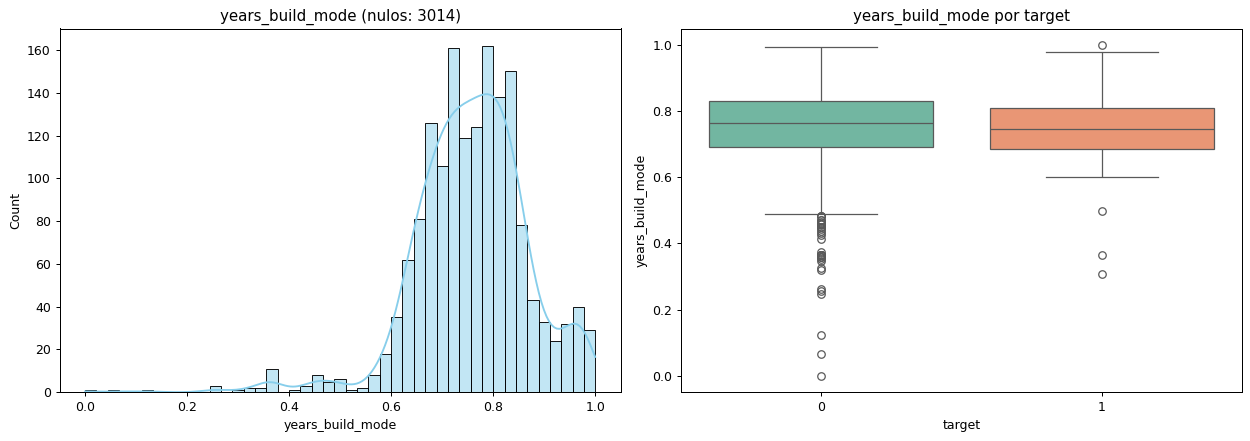

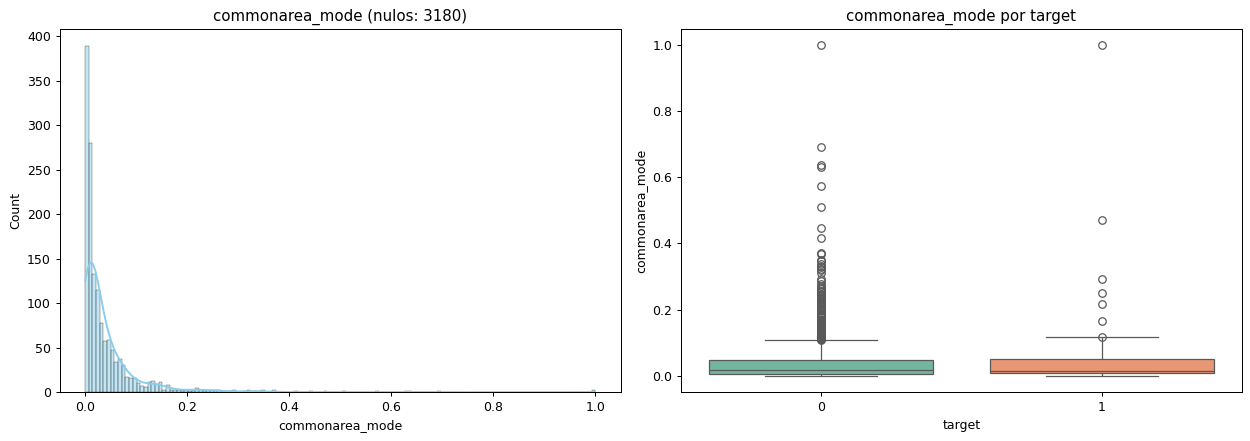

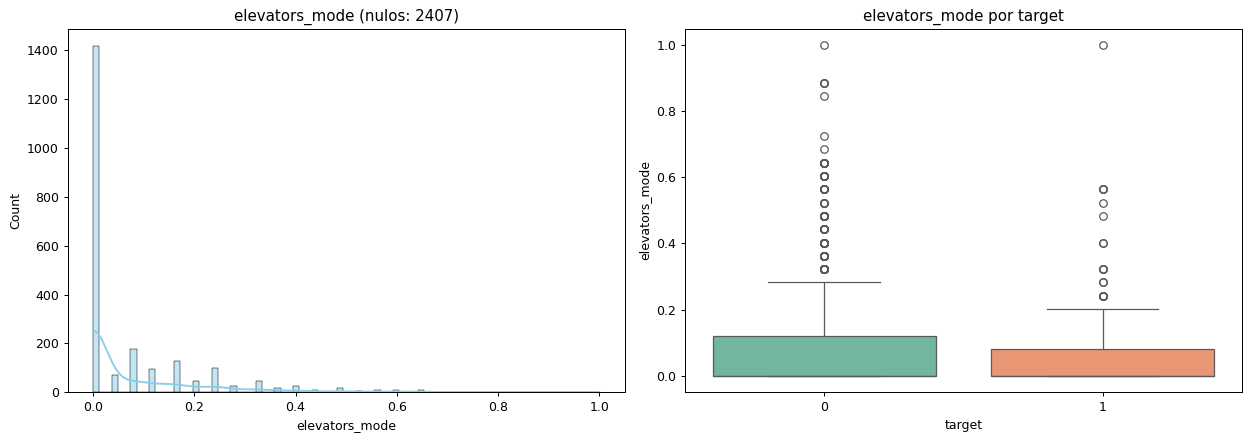

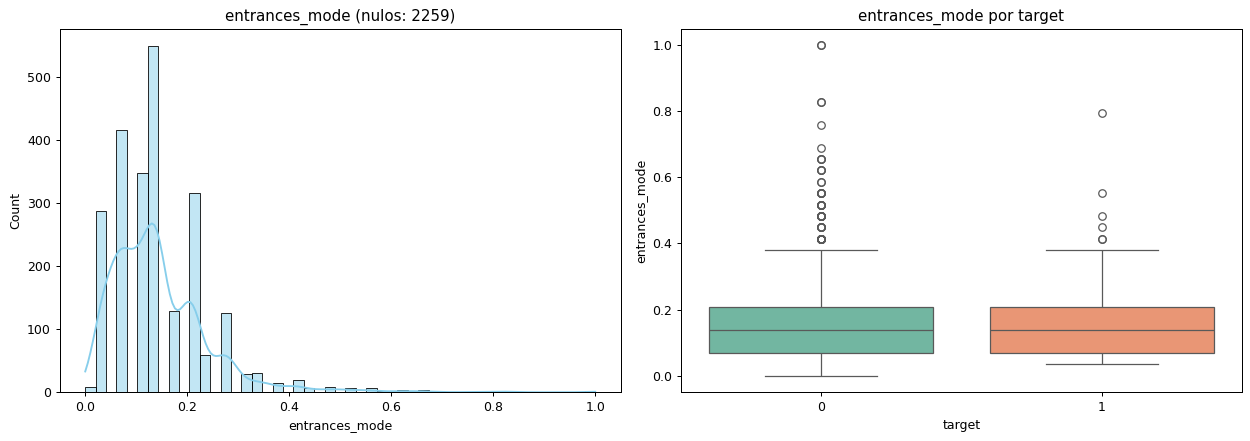

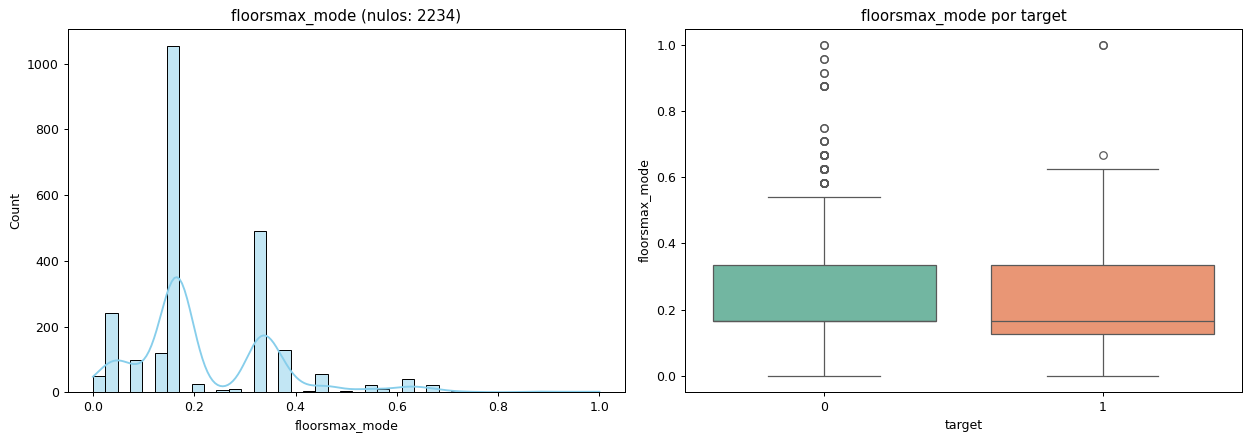

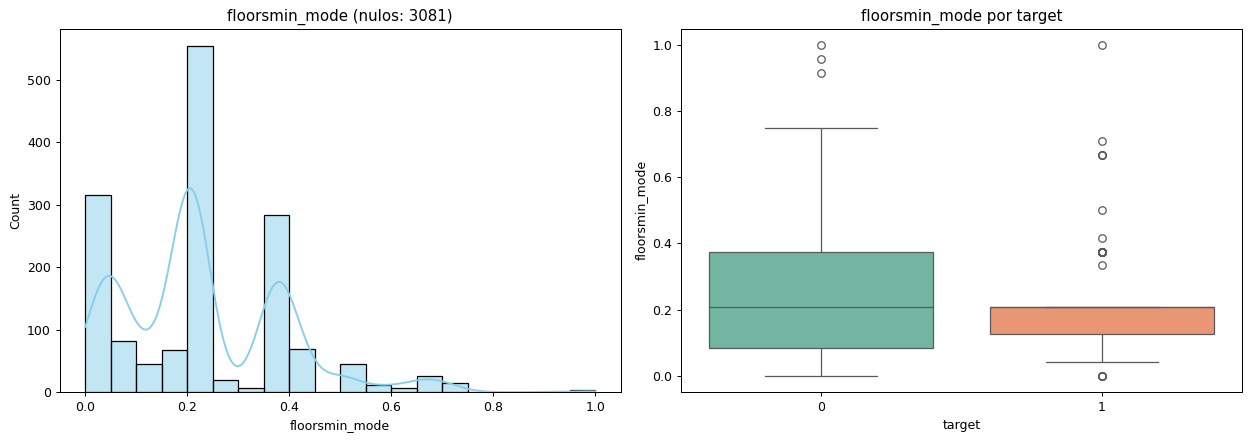

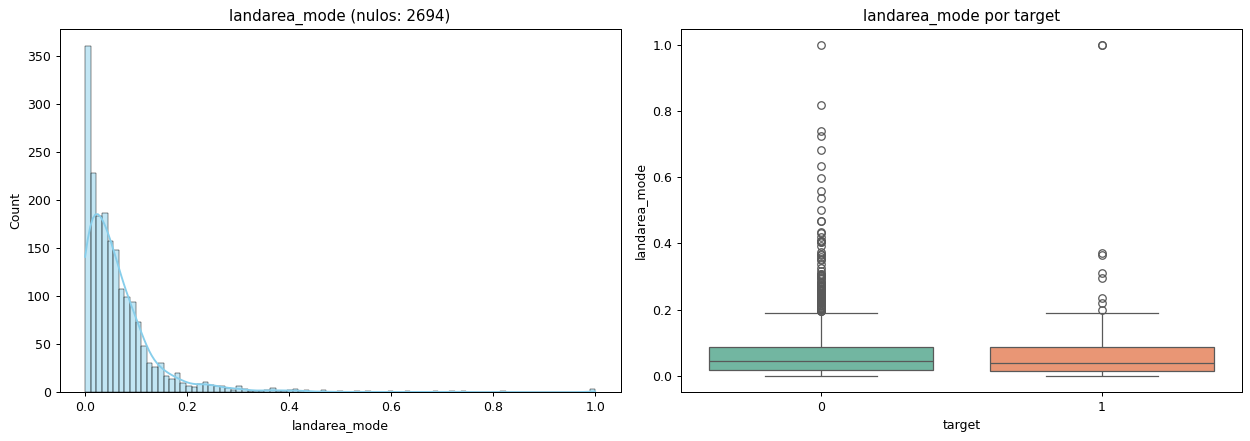

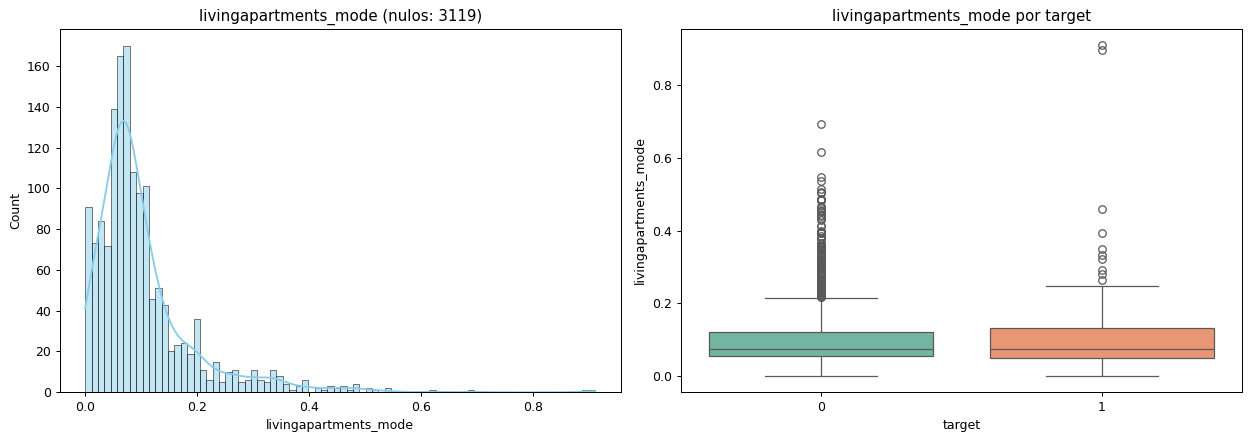

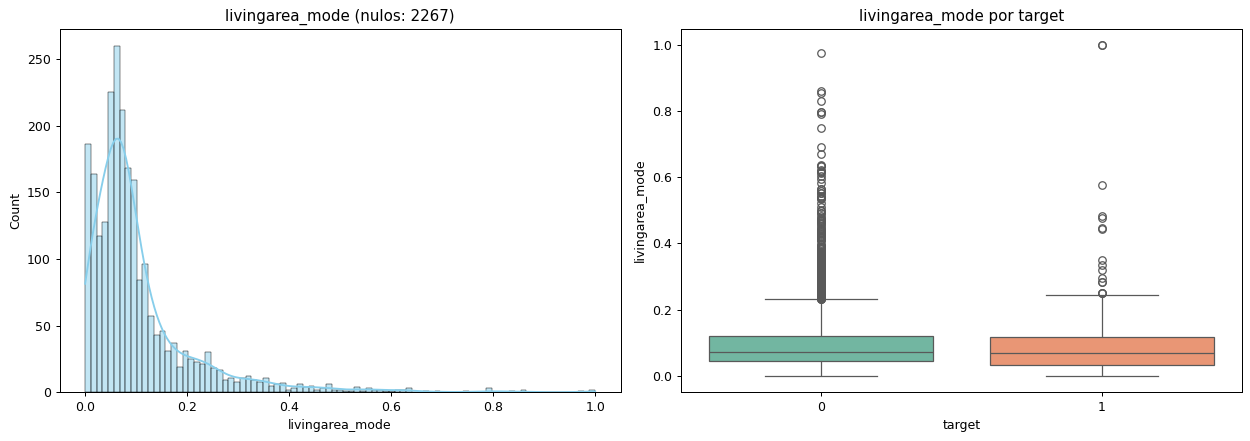

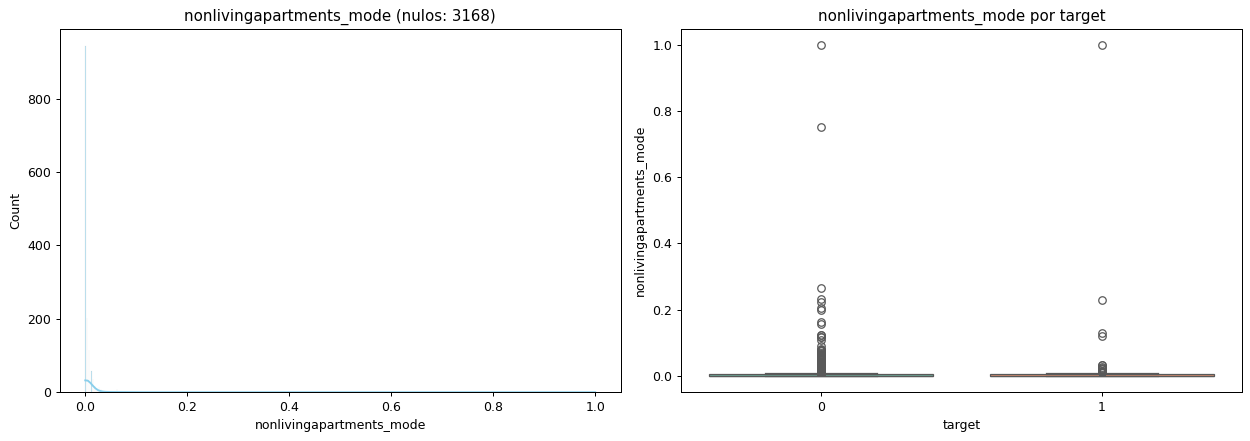

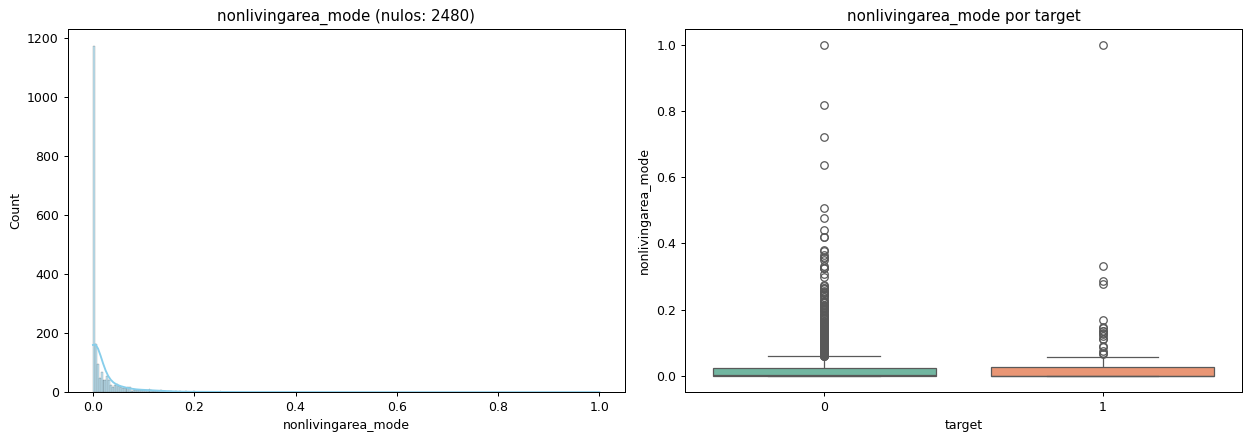

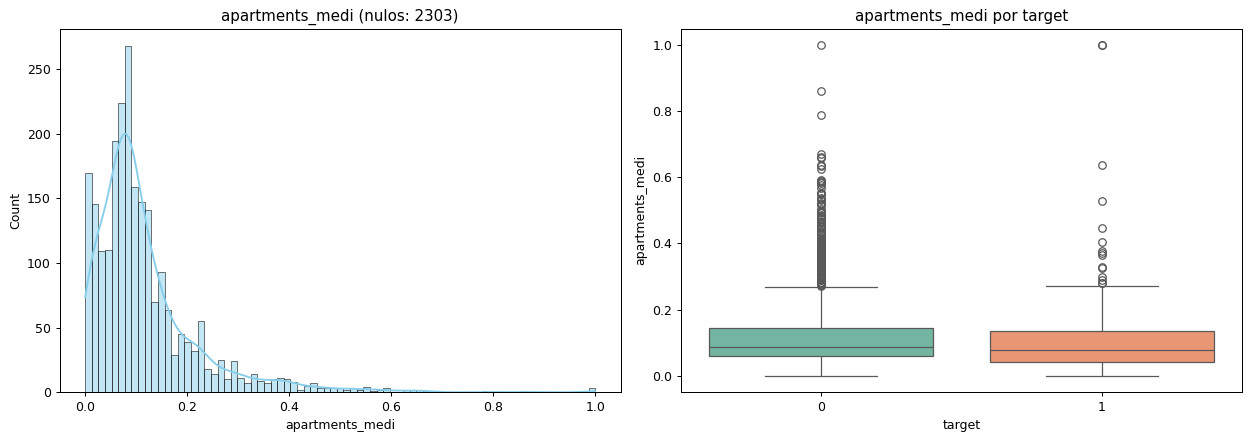

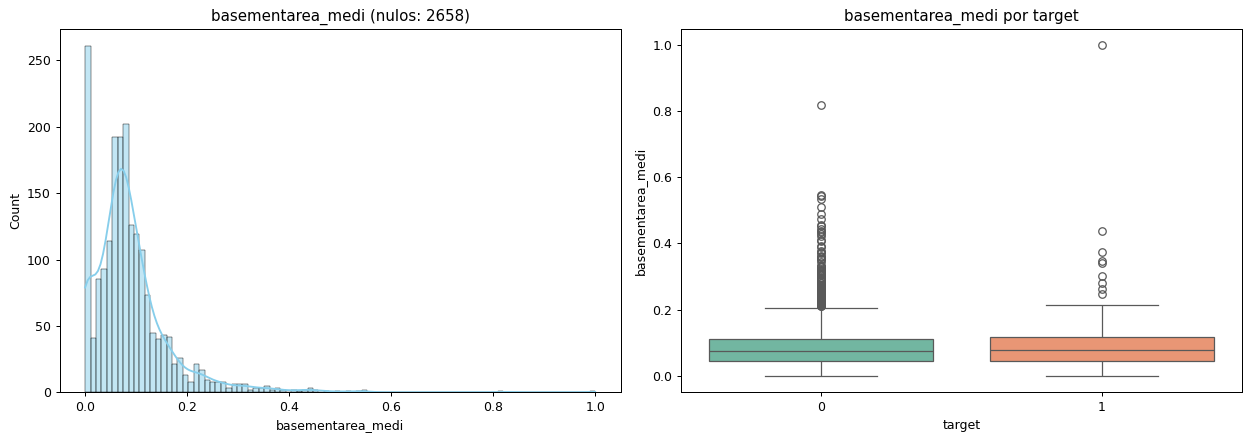

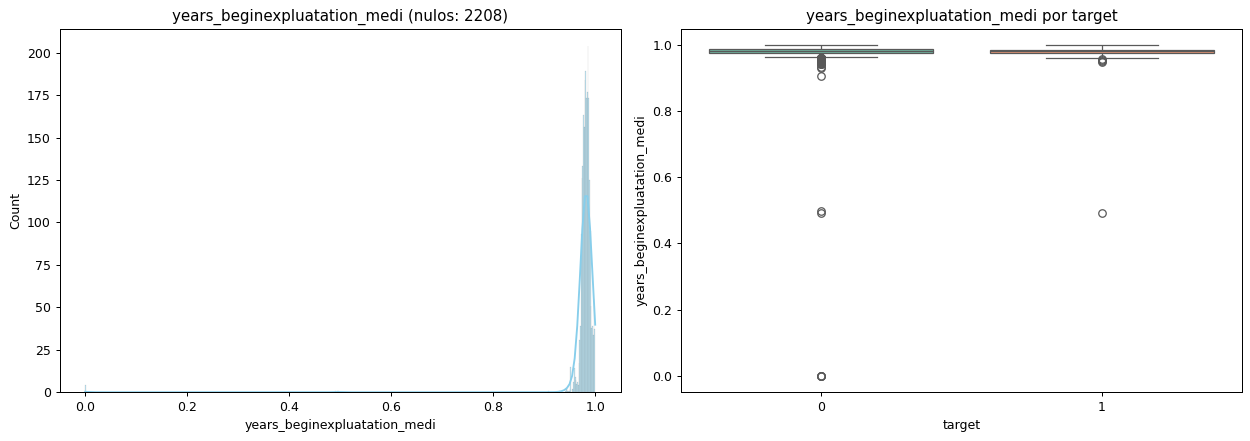

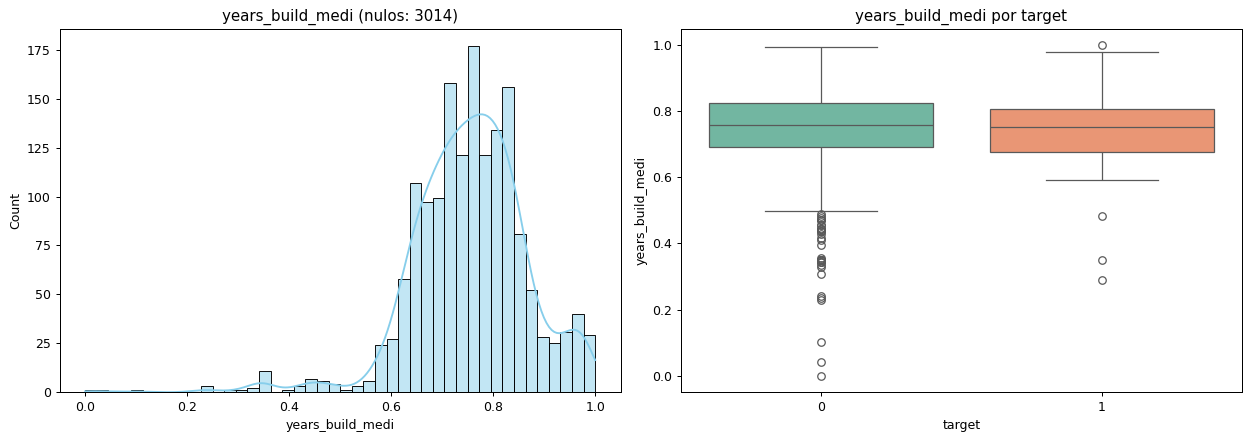

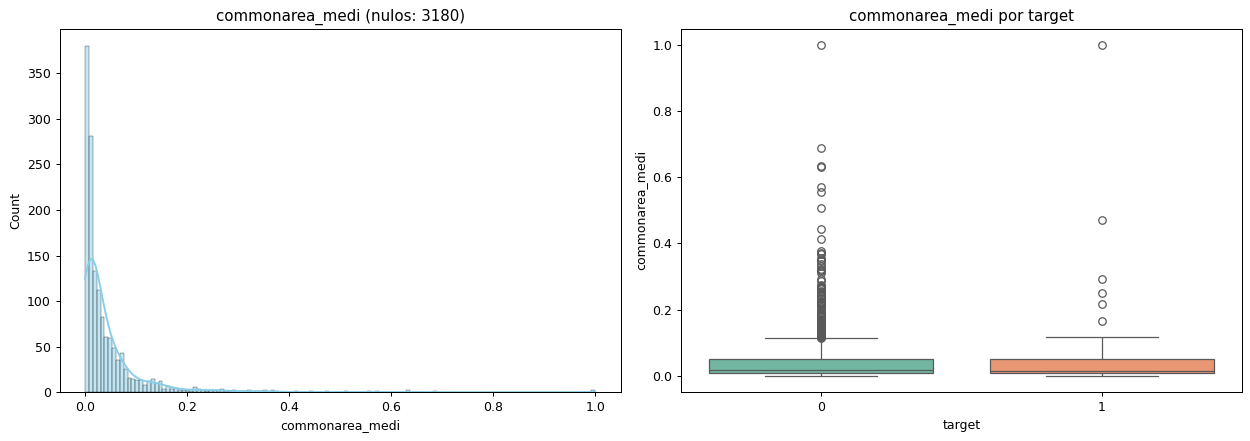

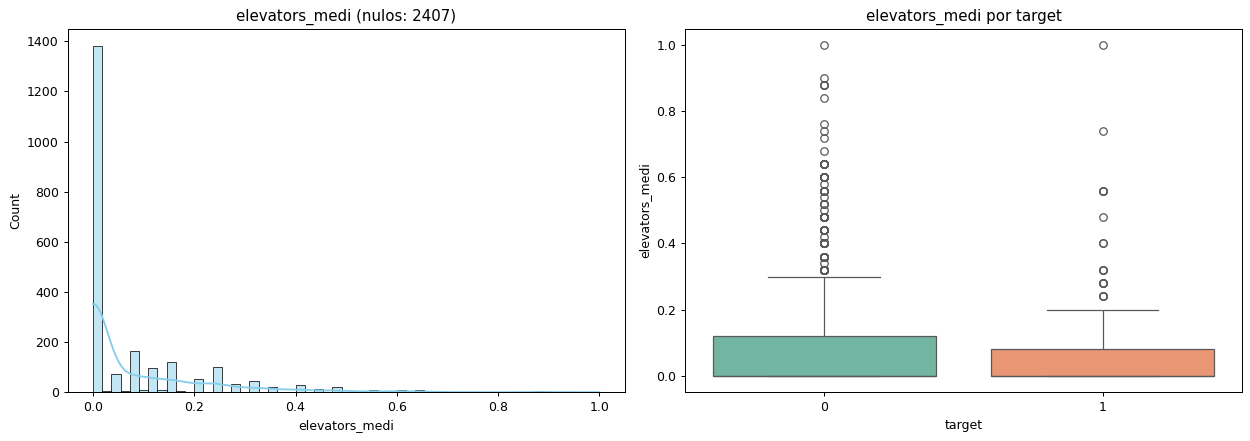

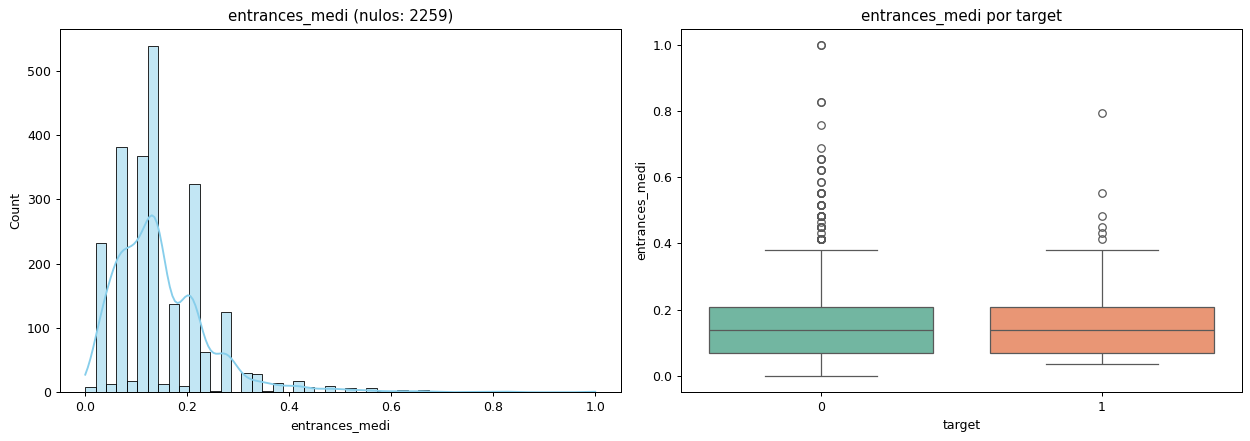

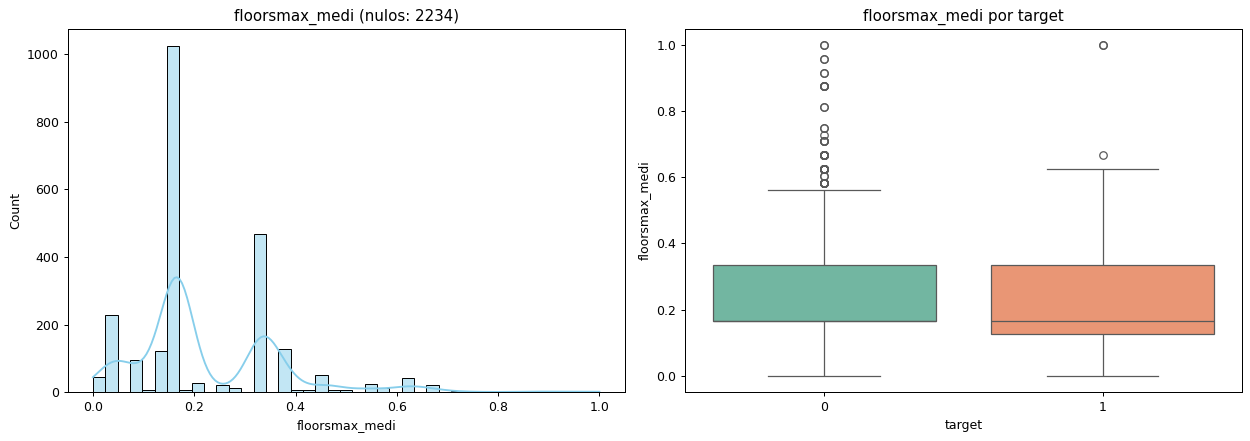

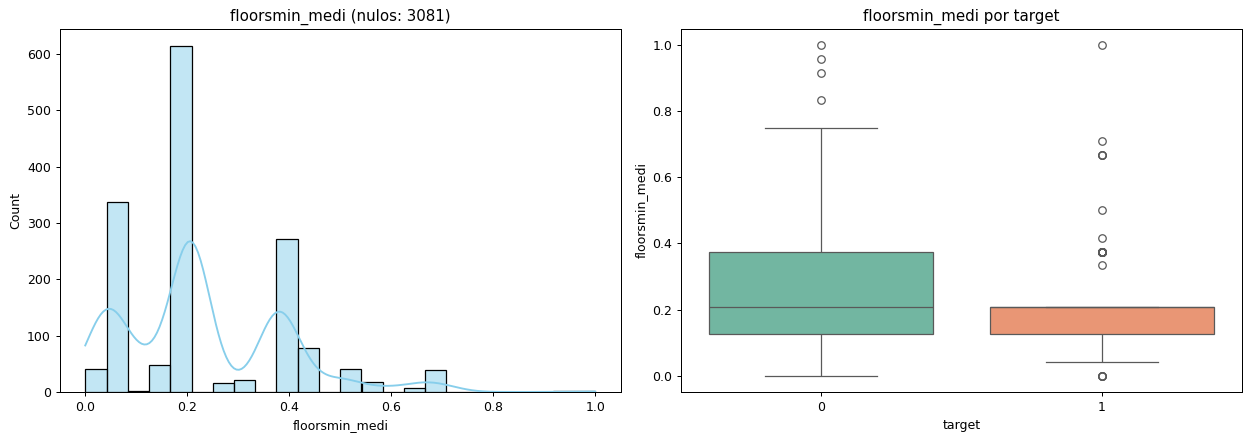

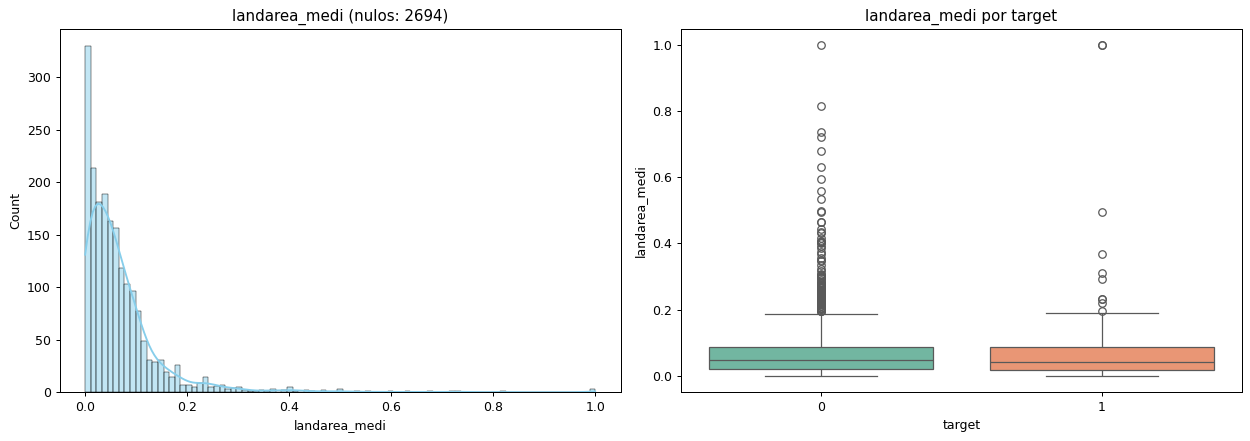

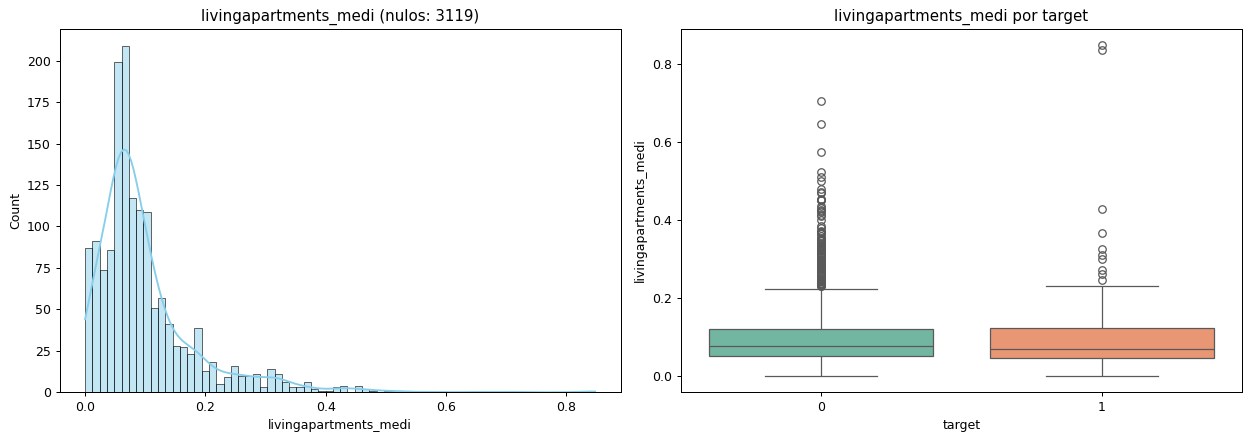

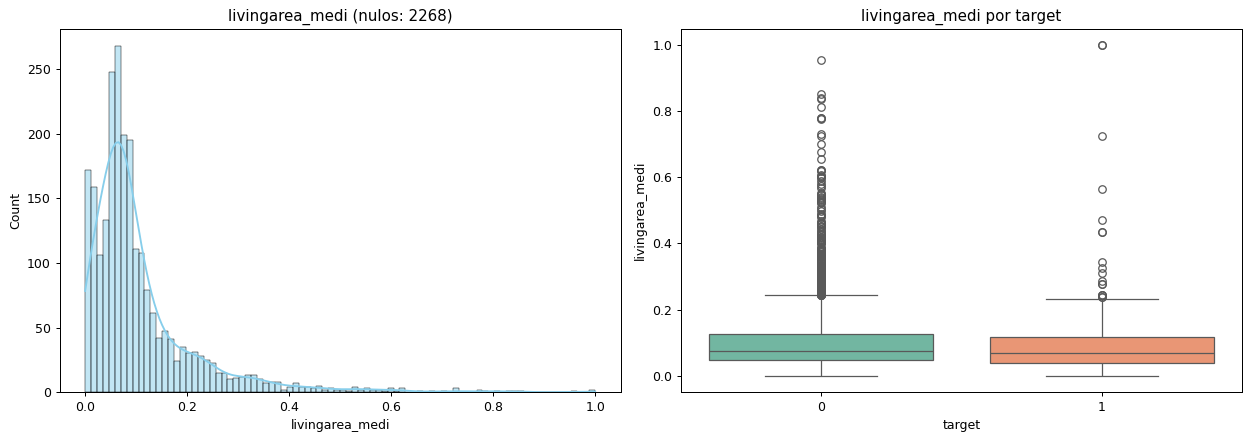

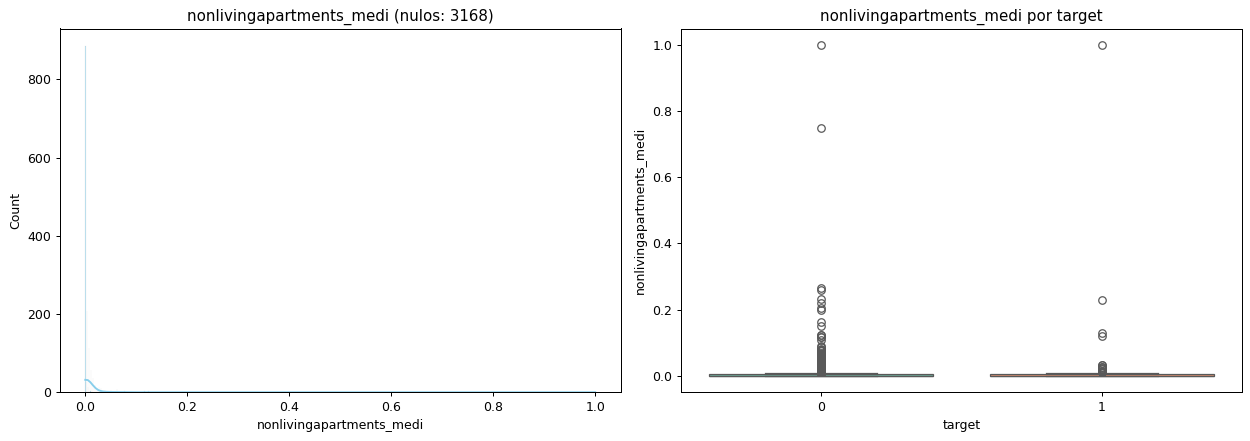

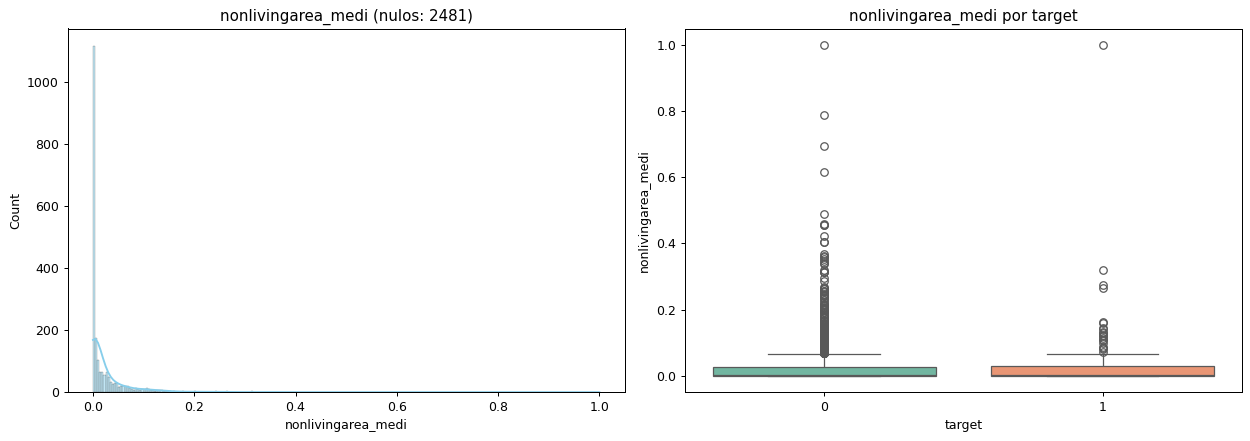

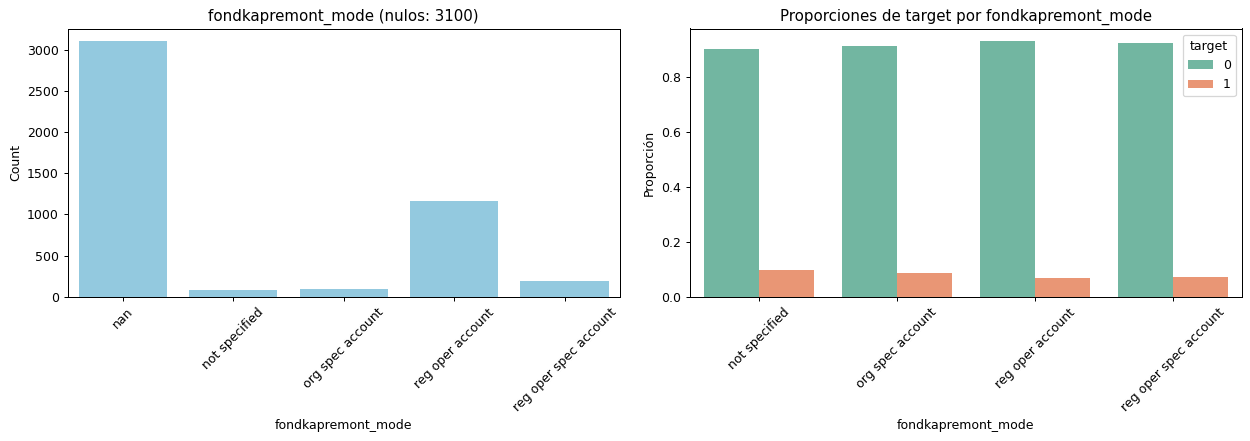

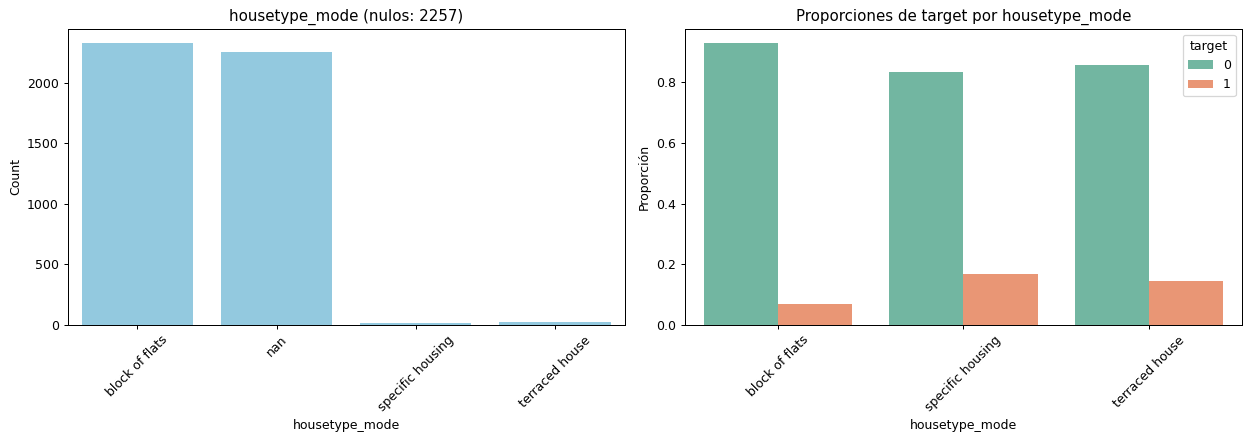

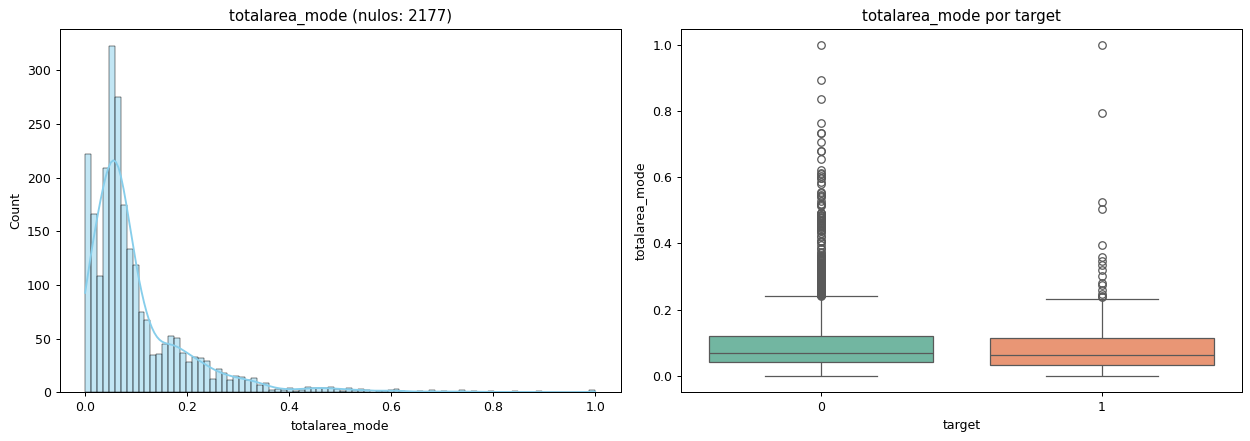

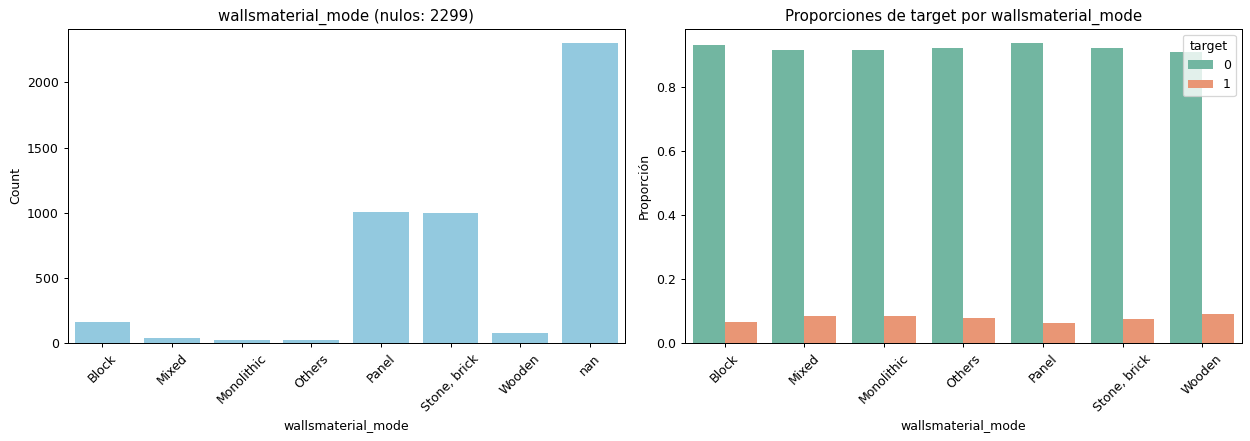

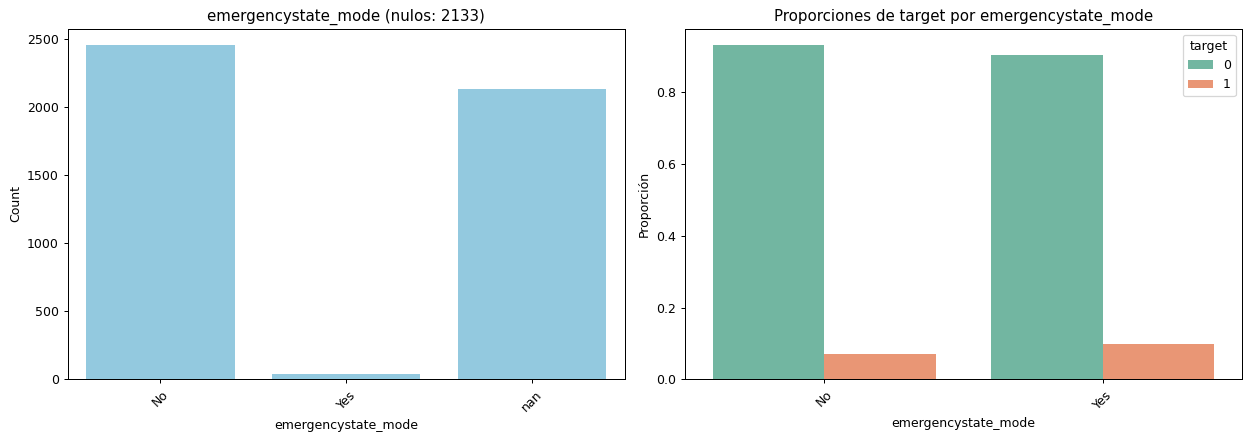

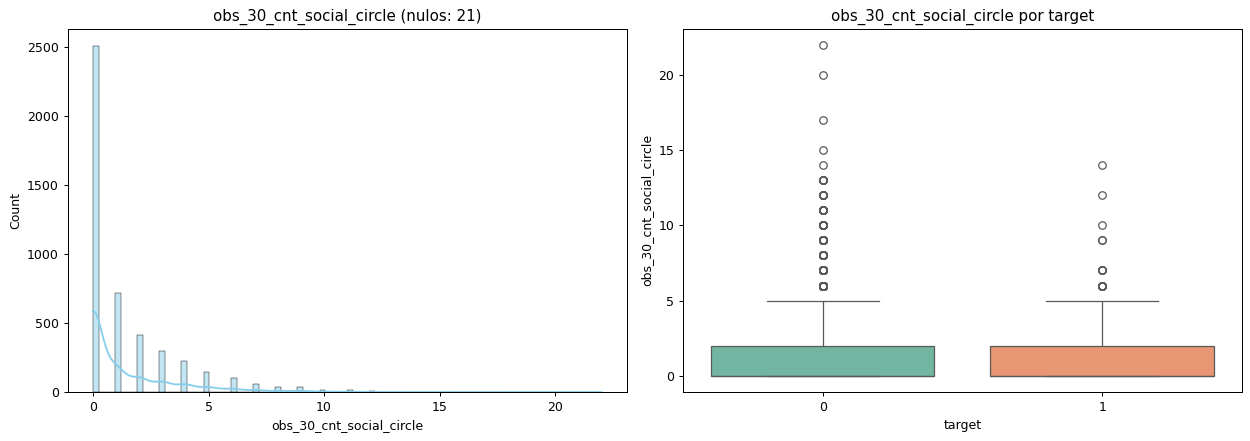

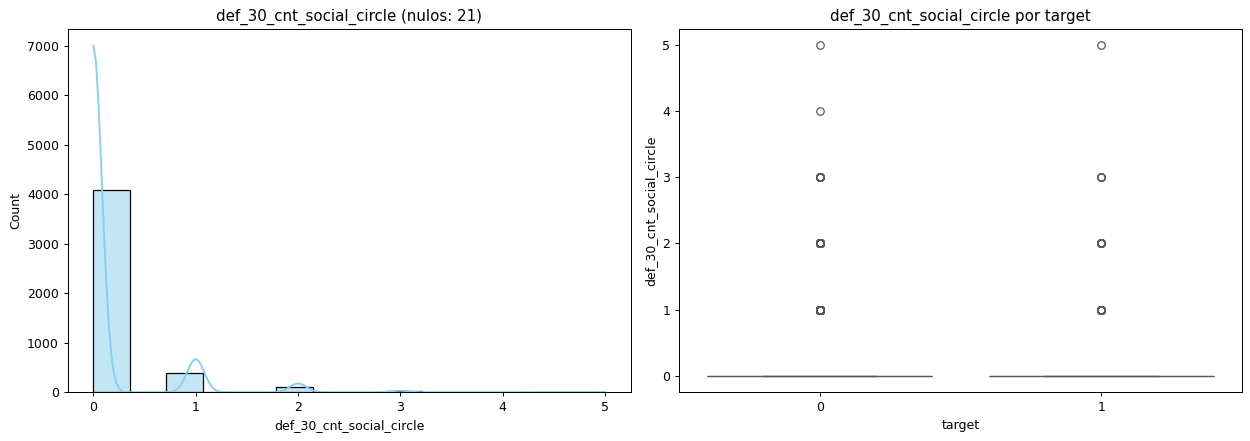

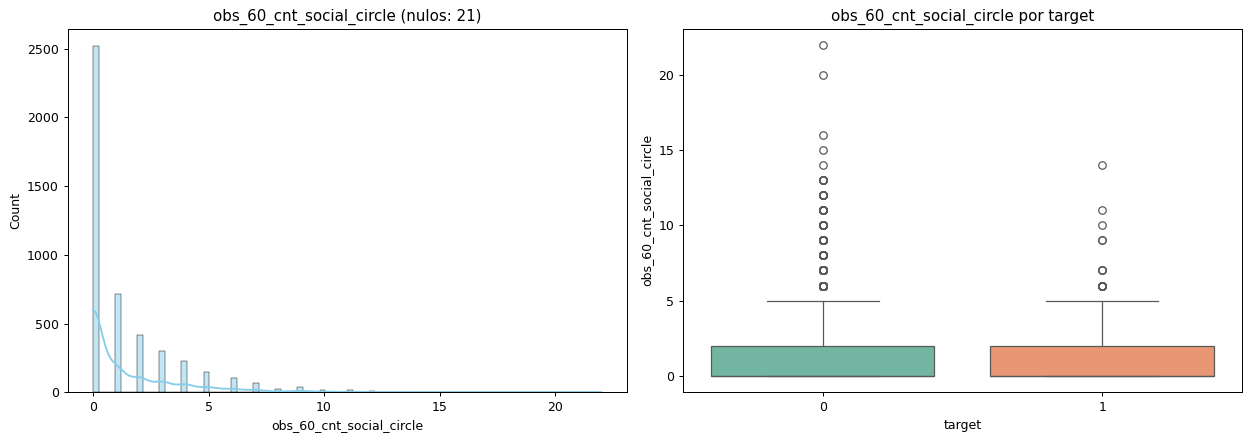

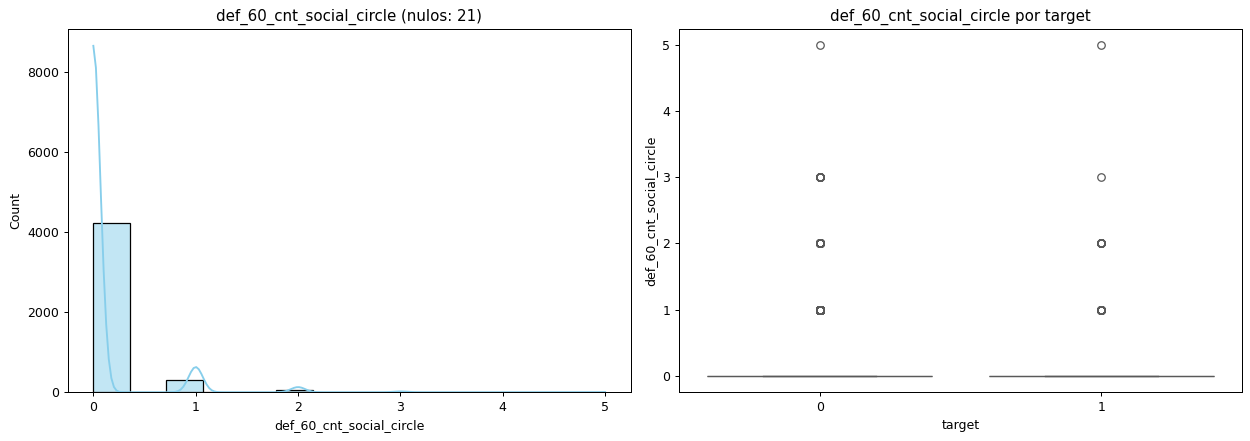

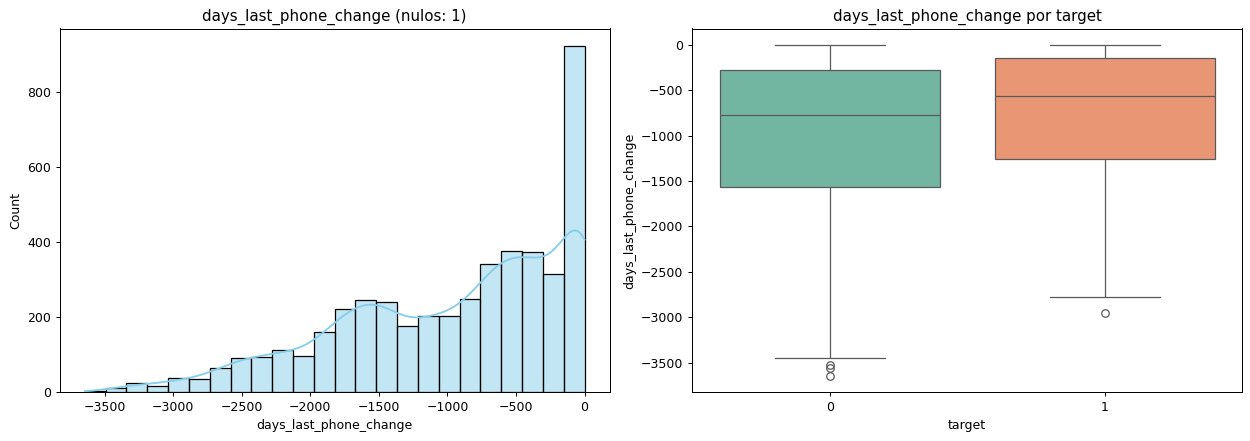

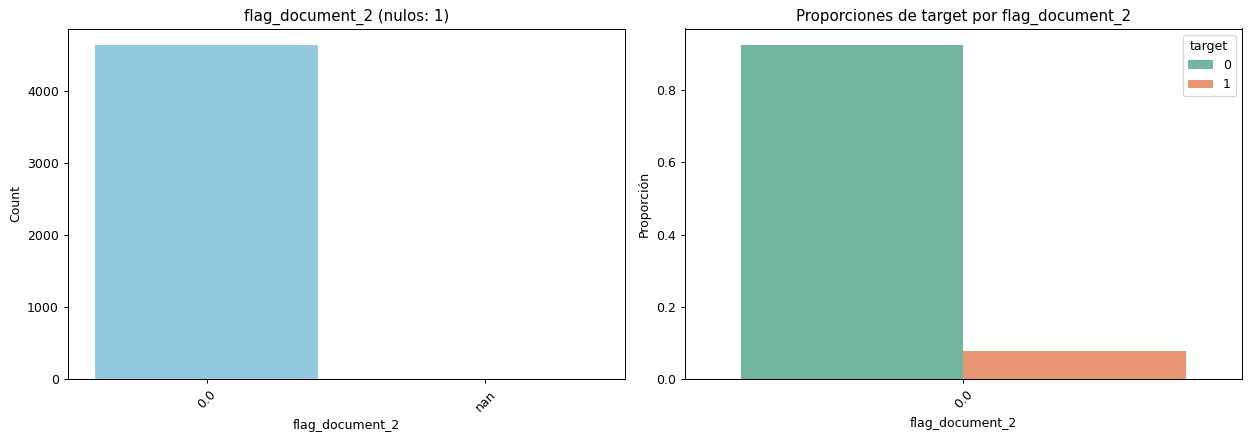

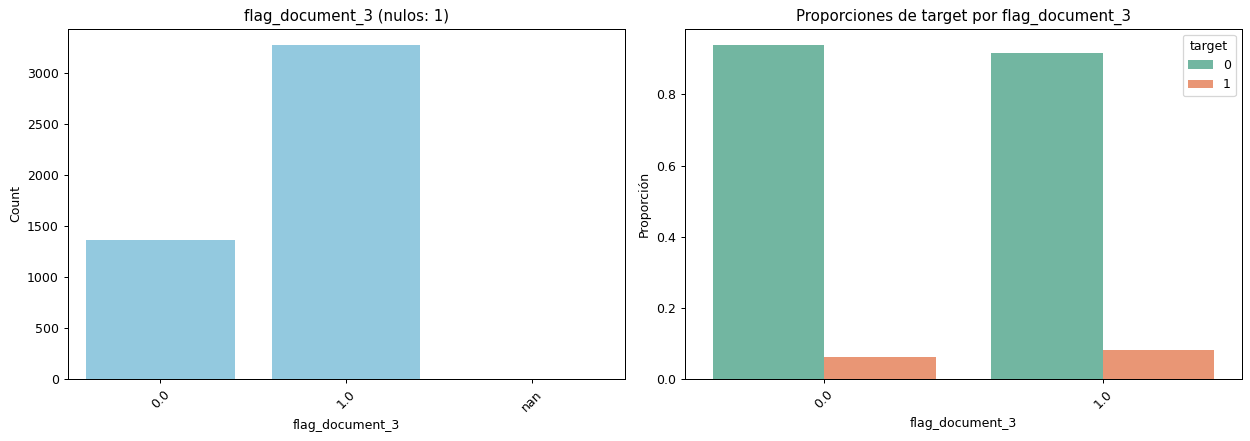

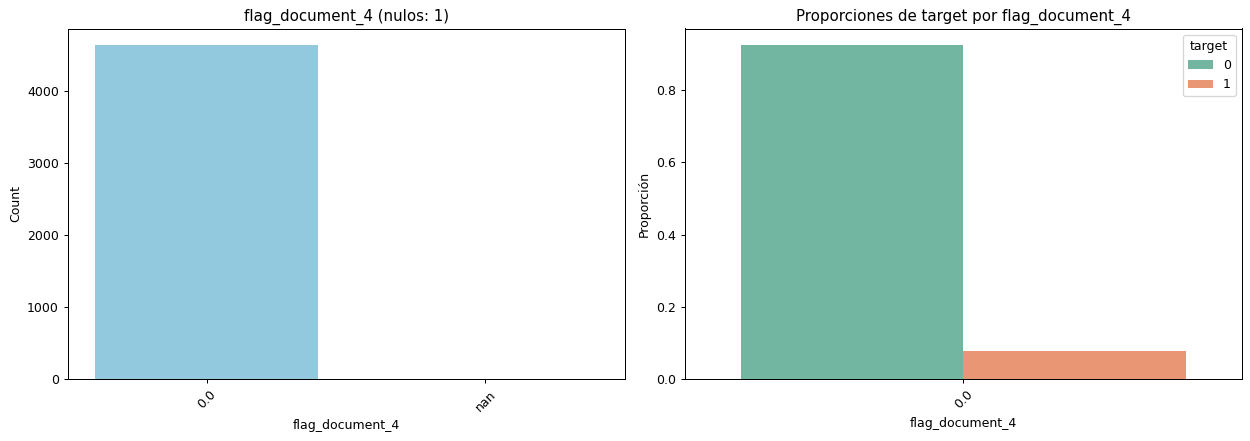

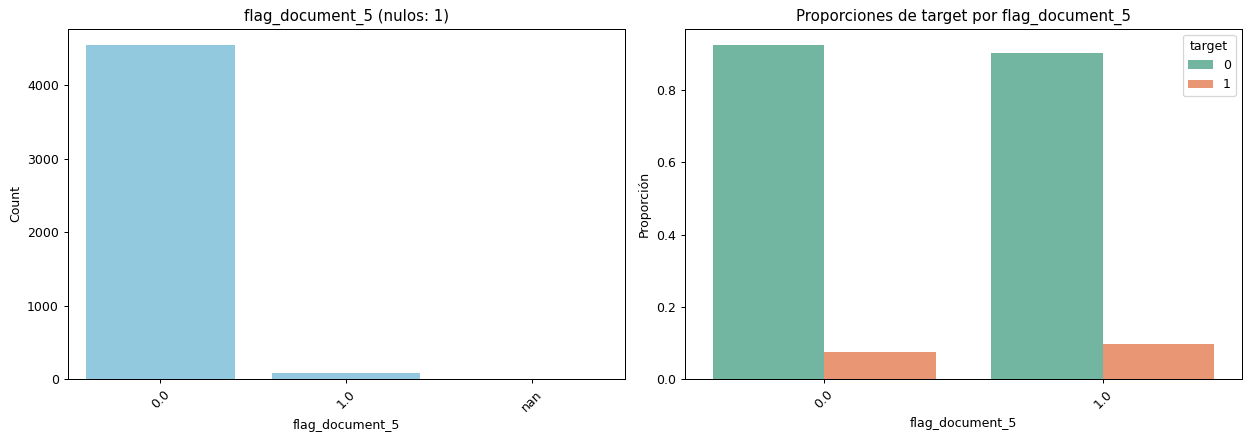

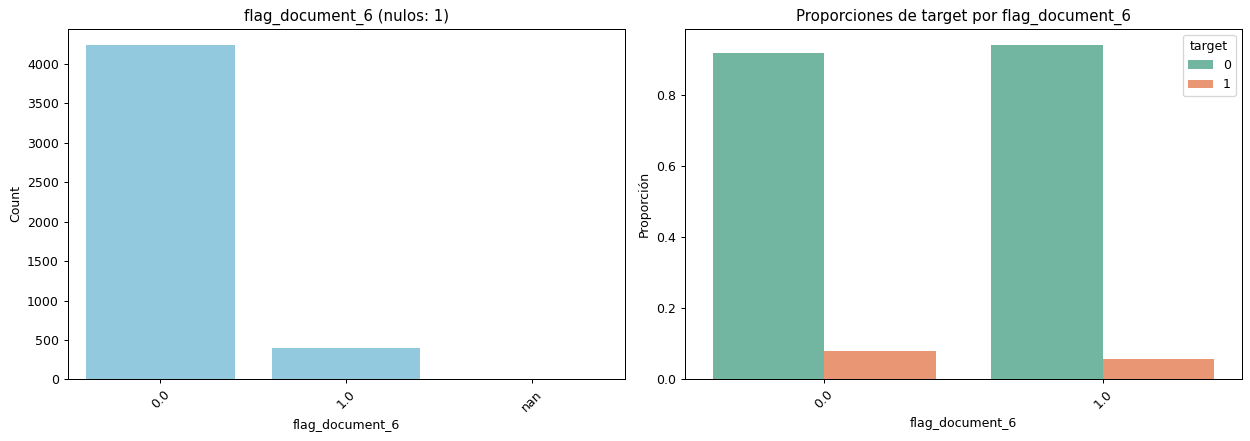

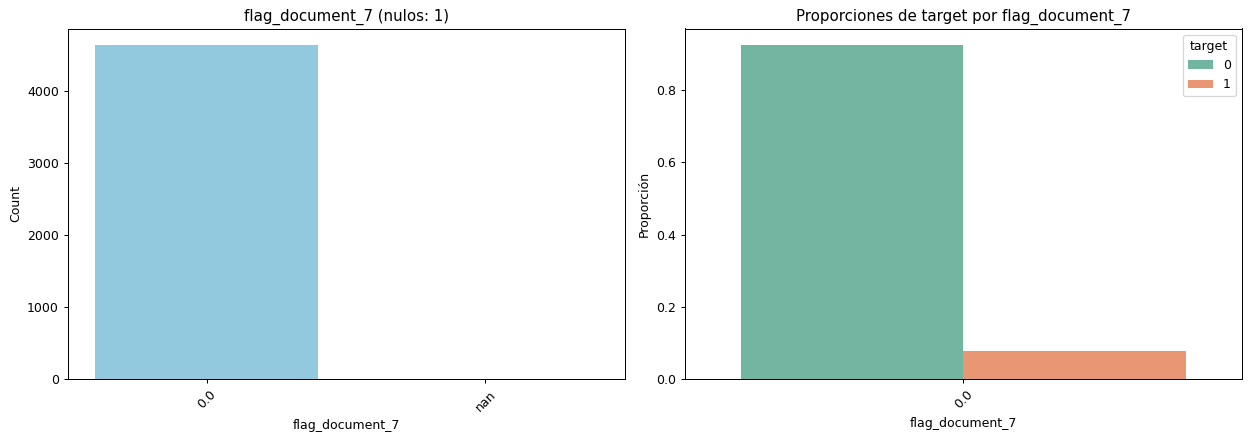

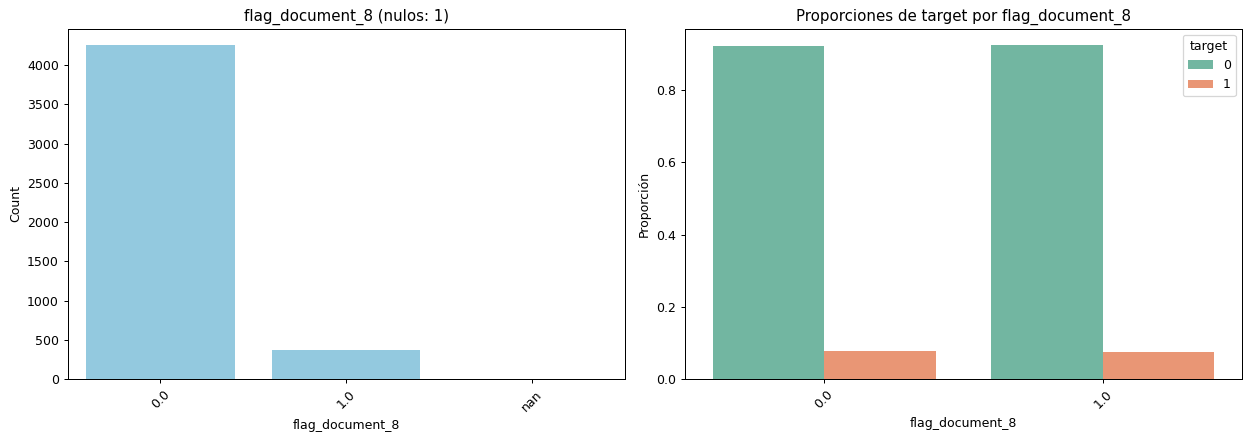

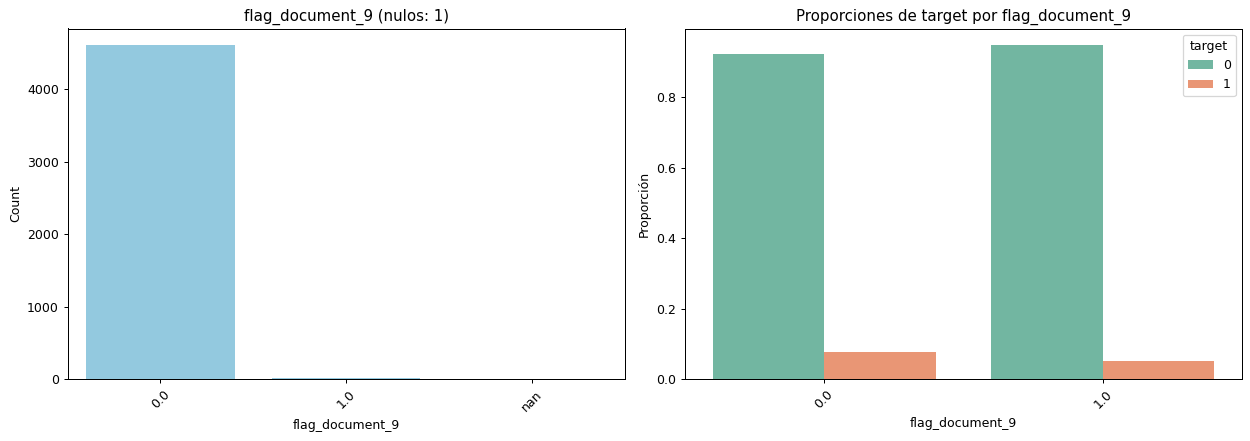

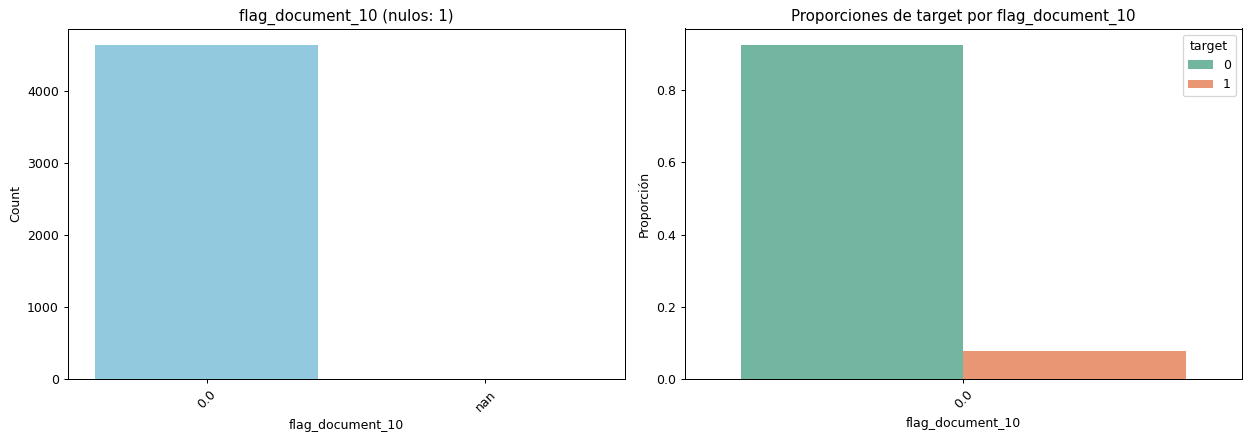

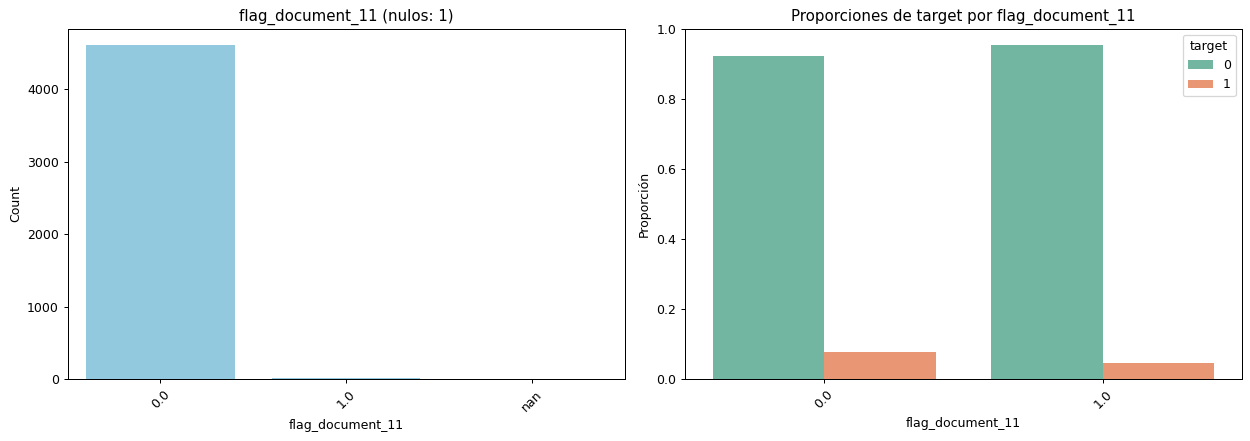

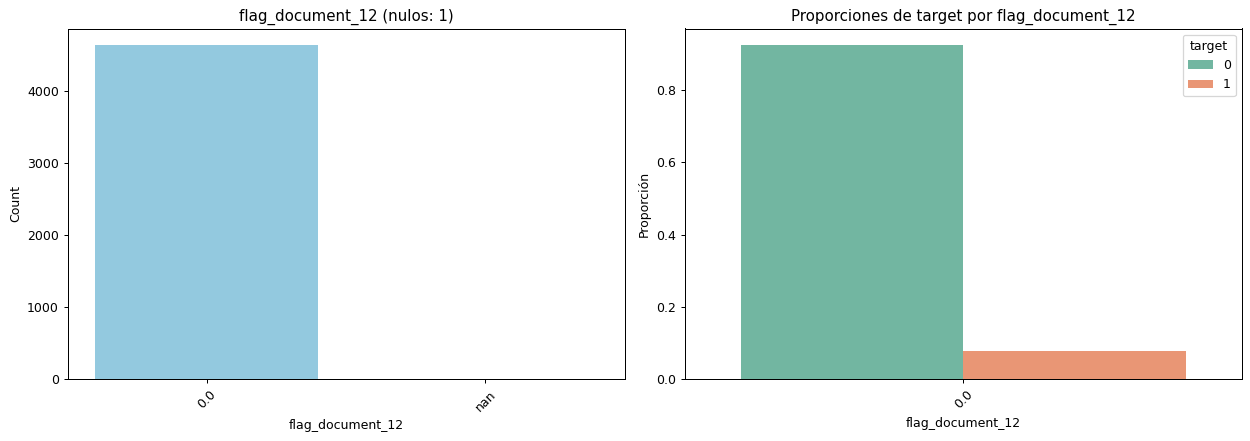

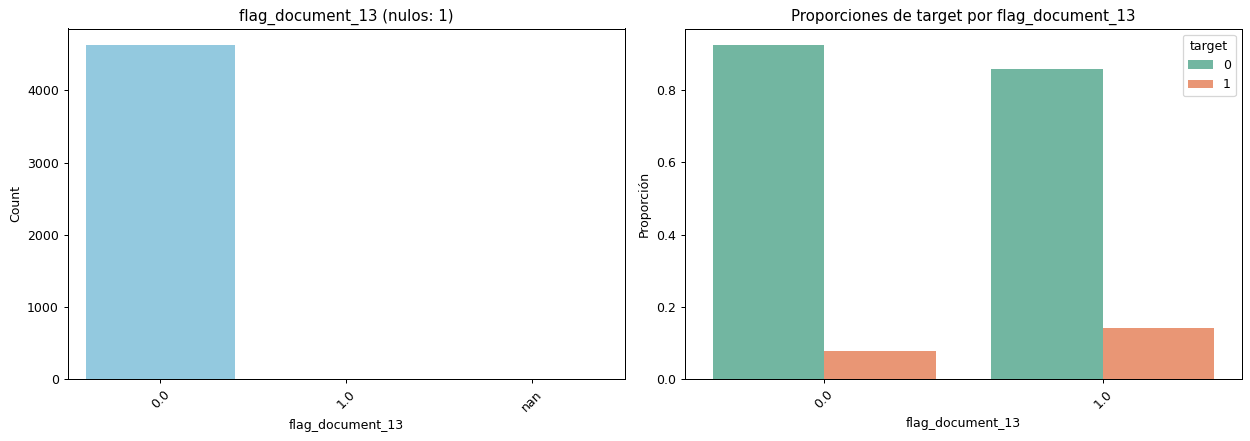

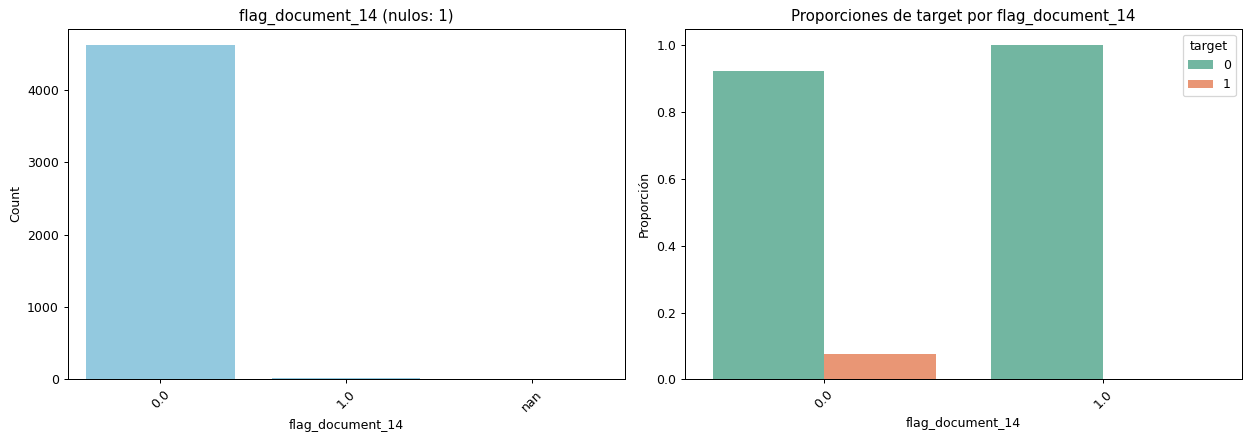

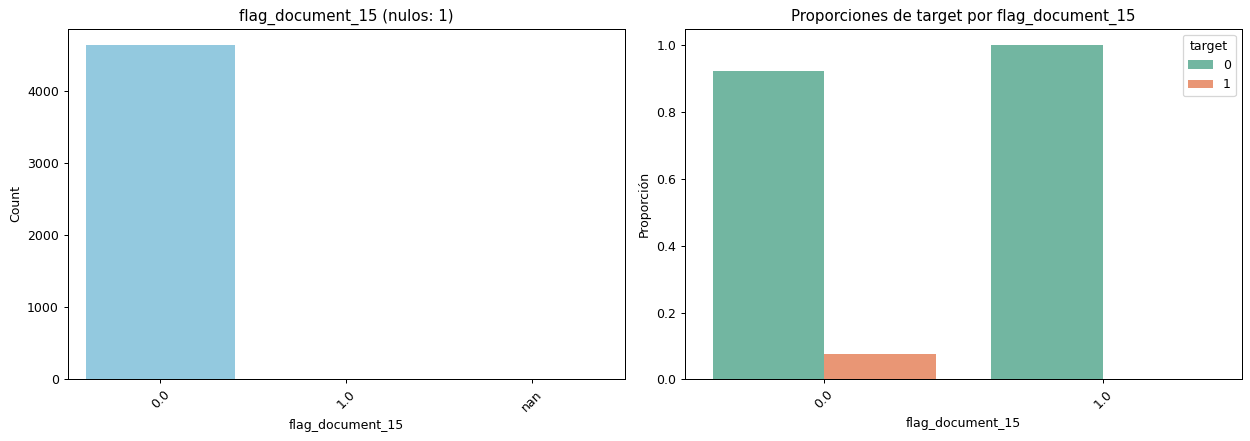

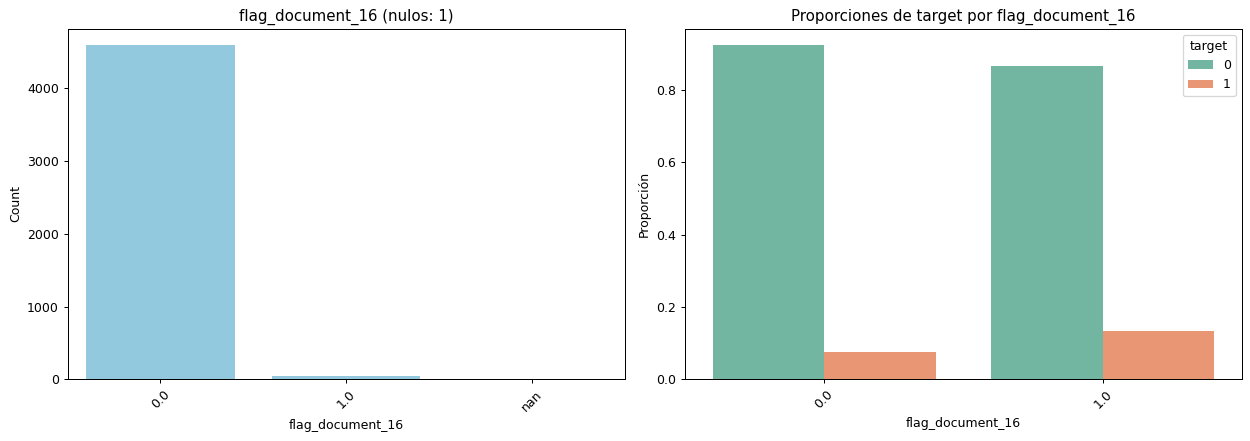

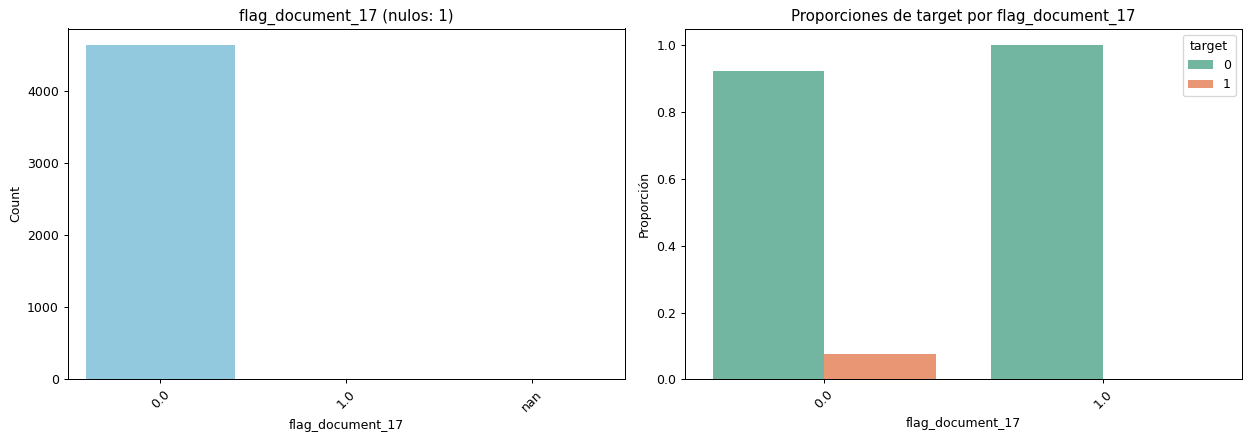

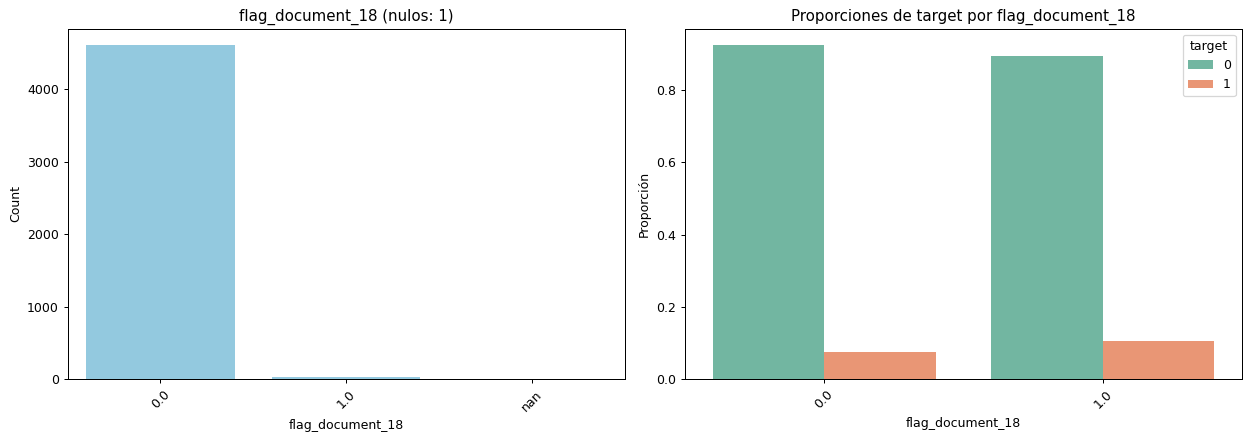

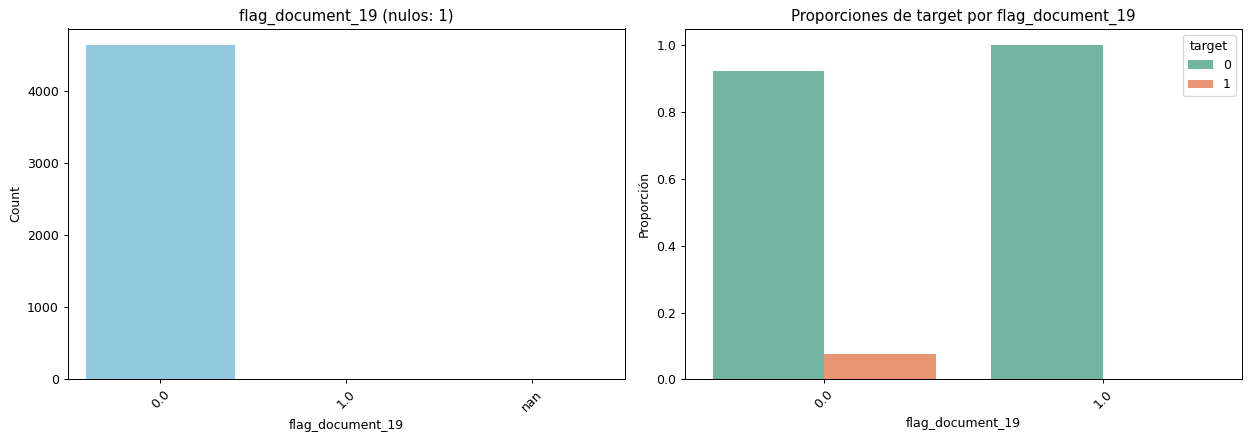

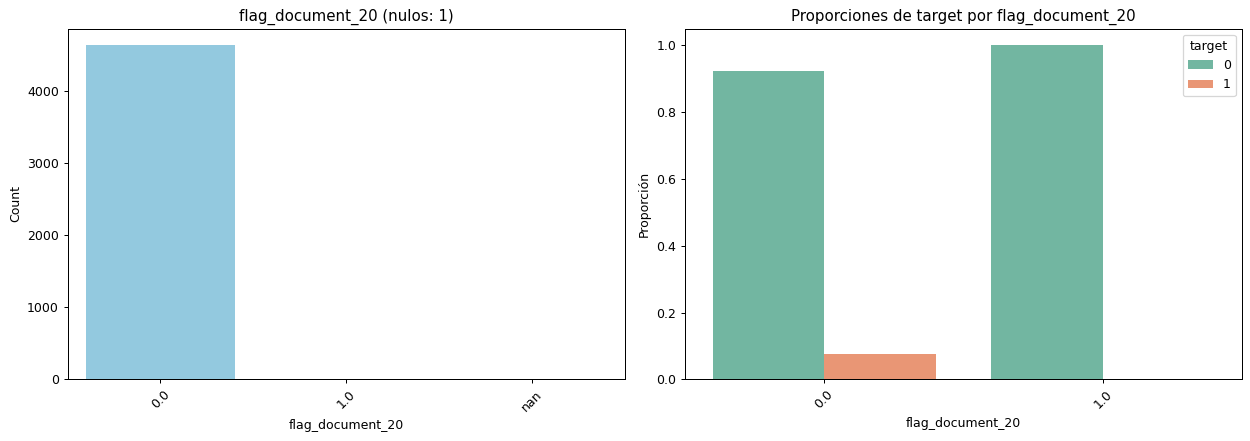

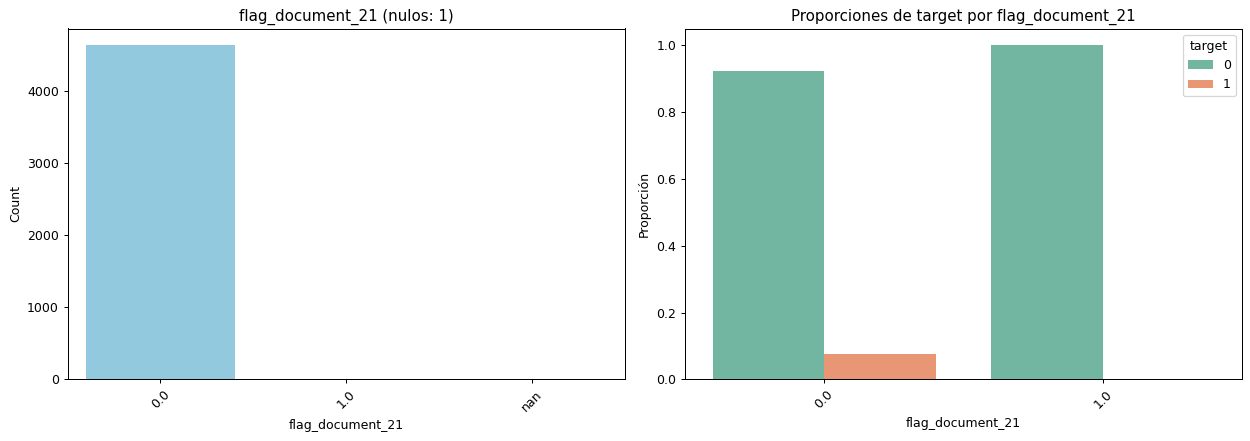

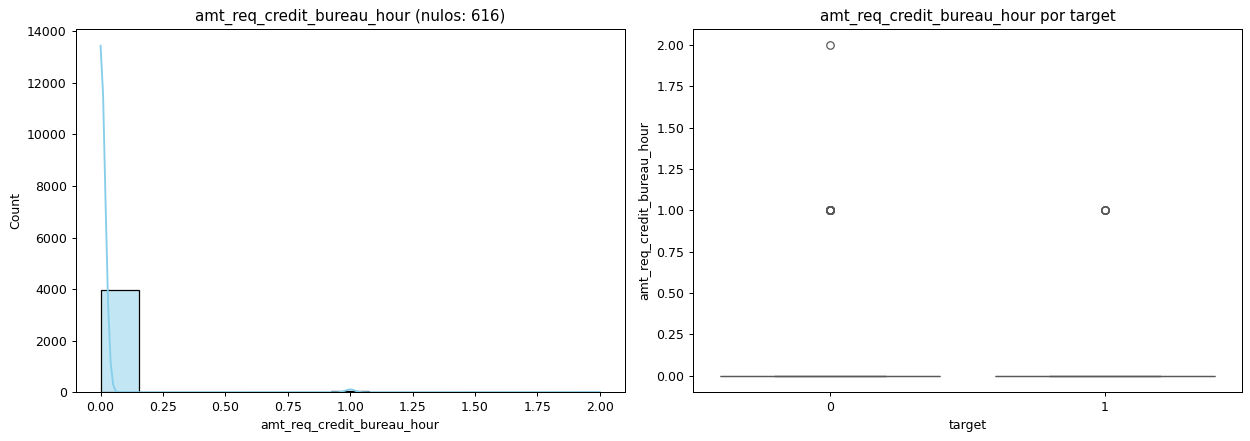

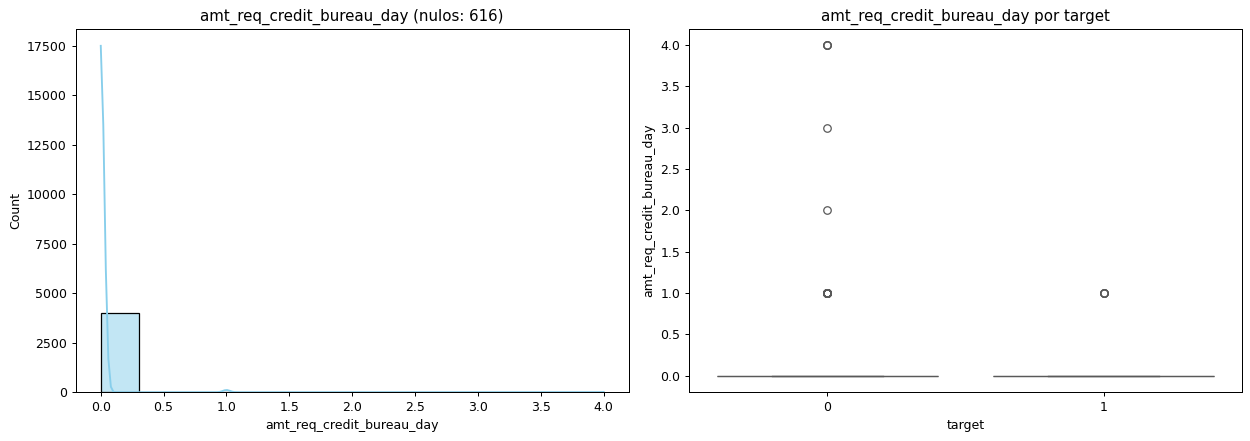

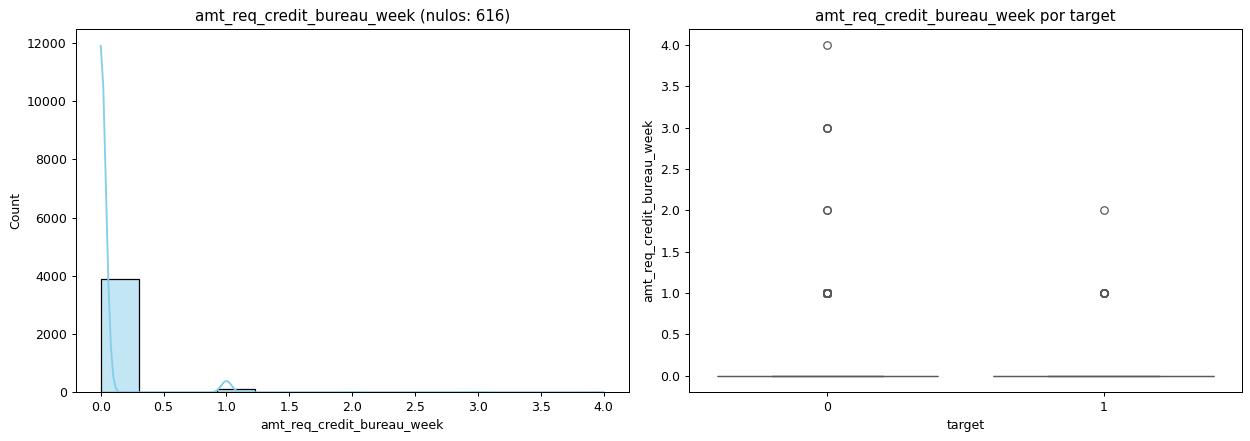

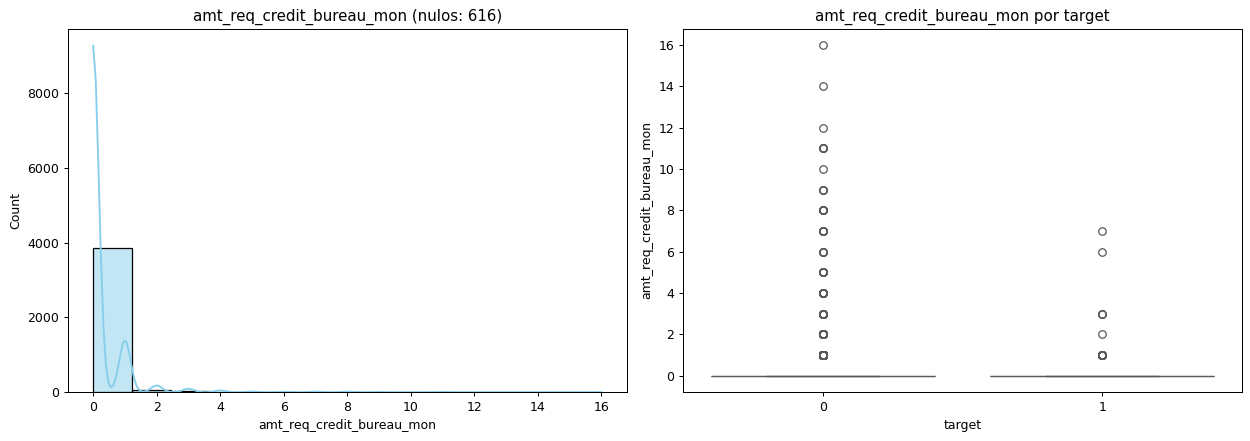

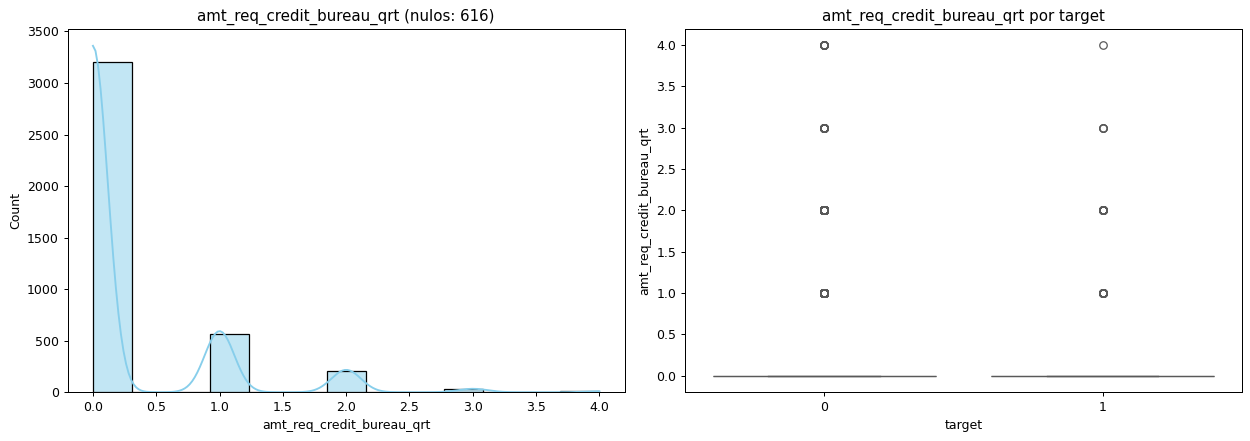

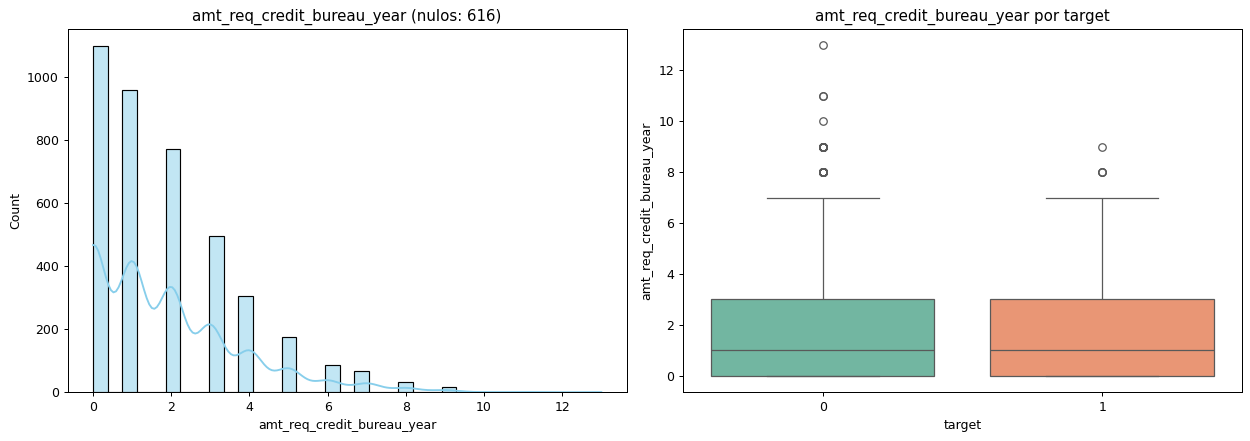

In [160]:
warnings.filterwarnings('ignore')

for i in list(credit_procesado_train.columns):
    if (credit_procesado_train[i].dtype == float) & (i != 'target'):
        plot_feature_variable(credit_procesado_train, col_name=i, isContinuous=True, target='target')
    elif i != 'target':
        plot_feature_variable(credit_procesado_train, col_name=i, isContinuous=False, target='target')


Este código está diseñado para visualizar variables dentro de un conjunto de datos, tanto continuas como categóricas, y nos permite explorar la relación de estas variables con una variable objetivo `target`.

El código se ejecuta iterando sobre todas las columnas del conjunto de datos. Si la columna es continua y no es la variable objetivo `target`, se llama a la función plot_feature con isContinuous=True. Si la columna es categórica (o si no es continua), se llama a la misma función con isContinuous=False.

Este código nos es útil para la exploración y visualización de los datos, permitiendonos hacer un análisis preliminar de las variables continuas y categóricas.

Los gráficos generados nos ayudan a comprender la distribución de los datos y la relación de cada variable con la variable objetivo, por ejemplo,
la primera Gráfica: `SK_ID_CURR` , nos muestra la distribución de la variable `SK_ID_CURR`, que parece ser un identificador único de cada cliente, junto con un gráfico de caja (boxplot) que compara la distribución de esta variable en relación con la variable objetivo `target`.

En conclusion, este codigo nos ha permitido visualizar la distribución de una variable de identificación, como `SK_ID_CURR`, para asegurarnos de que no haya errores evidentes en los datos (como valores faltantes o atípicos), y a parte, confirmar que la variable identificadora no está relacionada con el comportamiento de la variable objetivo `target`, lo que indica que no es relevante para el análisis predictivo.

## **Tratamiento de las variables continuas**

A continuación, se tratan los valores missing, las correlaciones de las vairbales continuas y los outlier

In [161]:
list_var_continuous

['sk_id_curr',
 'amt_income_total',
 'amt_credit',
 'amt_annuity',
 'amt_goods_price',
 'region_population_relative',
 'days_birth',
 'days_employed',
 'days_registration',
 'days_id_publish',
 'ext_source_1',
 'ext_source_2',
 'ext_source_3',
 'apartments_avg',
 'basementarea_avg',
 'years_beginexpluatation_avg',
 'years_build_avg',
 'commonarea_avg',
 'elevators_avg',
 'entrances_avg',
 'floorsmax_avg',
 'floorsmin_avg',
 'landarea_avg',
 'livingapartments_avg',
 'livingarea_avg',
 'nonlivingapartments_avg',
 'nonlivingarea_avg',
 'apartments_mode',
 'basementarea_mode',
 'years_beginexpluatation_mode',
 'years_build_mode',
 'commonarea_mode',
 'landarea_mode',
 'livingapartments_mode',
 'livingarea_mode',
 'nonlivingarea_mode',
 'apartments_medi',
 'basementarea_medi',
 'years_beginexpluatation_medi',
 'years_build_medi',
 'commonarea_medi',
 'landarea_medi',
 'livingapartments_medi',
 'livingarea_medi',
 'nonlivingapartments_medi',
 'nonlivingarea_medi',
 'totalarea_mode',
 'days_l

### **Tratamiento de outliers**

                        Variable  Outlier Count
0                     sk_id_curr              0
1               amt_income_total             39
2                     amt_credit              4
3                    amt_annuity             16
4                amt_goods_price             19
5     region_population_relative              0
6                     days_birth              0
7                  days_employed            890
8              days_registration              0
9                days_id_publish              0
10                  ext_source_1              0
11                  ext_source_2              0
12                  ext_source_3              0
13                apartments_avg             60
14              basementarea_avg             43
15   years_beginexpluatation_avg             19
16               years_build_avg              6
17                commonarea_avg             59
18                 elevators_avg             43
19                 entrances_avg        

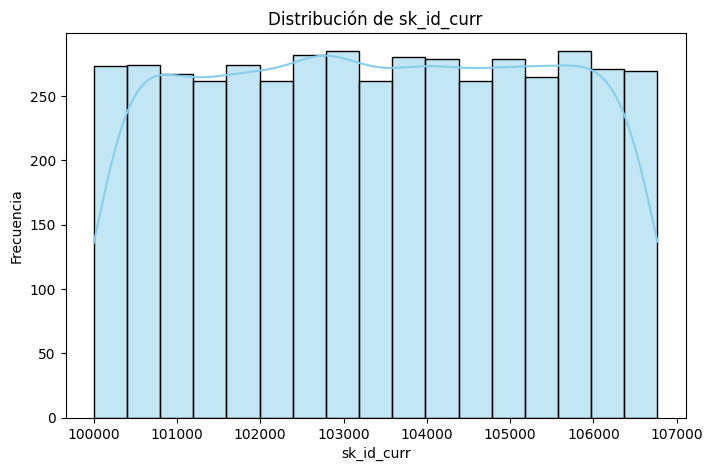

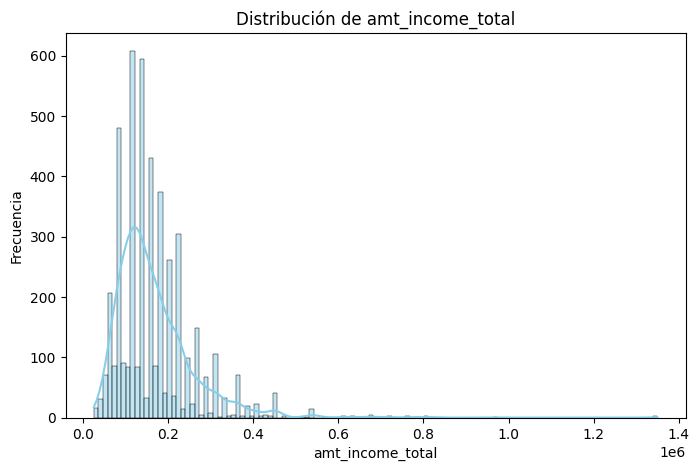

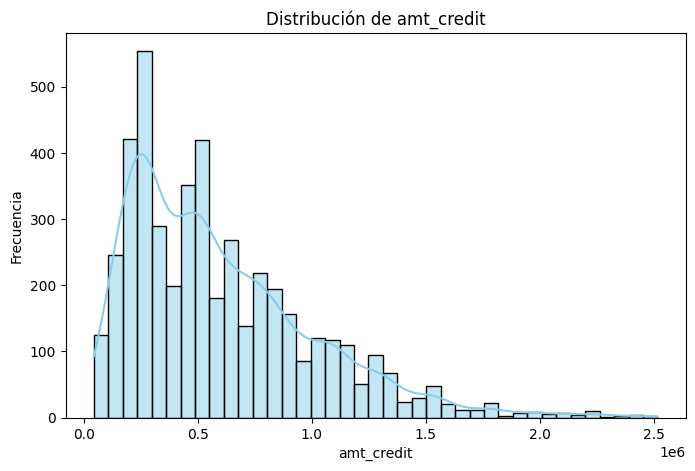

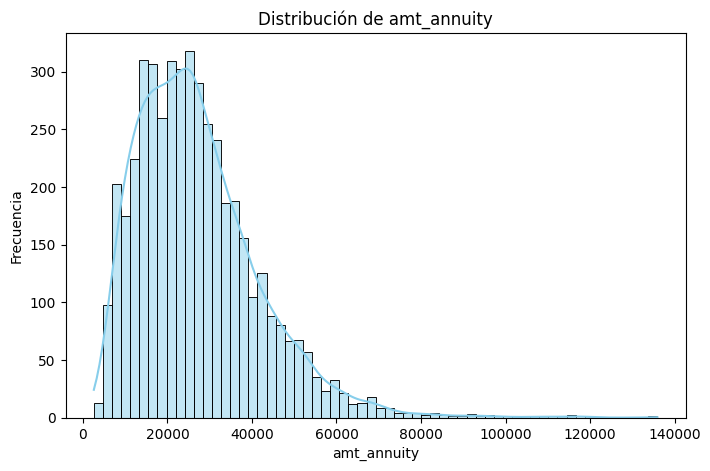

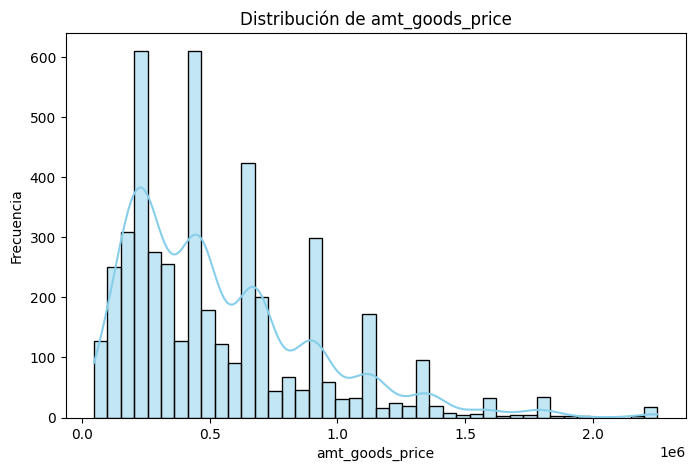

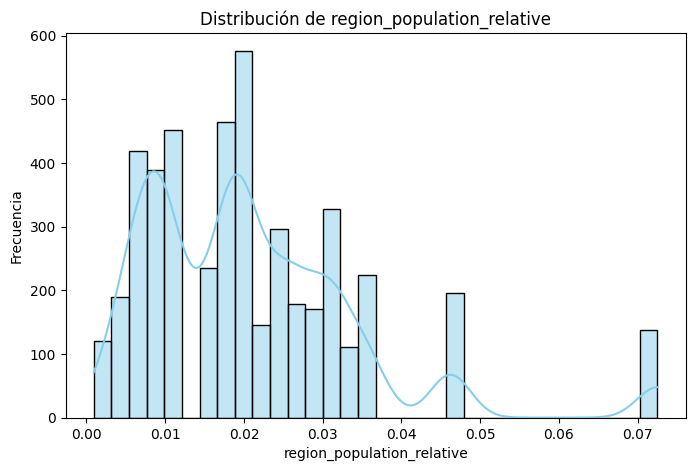

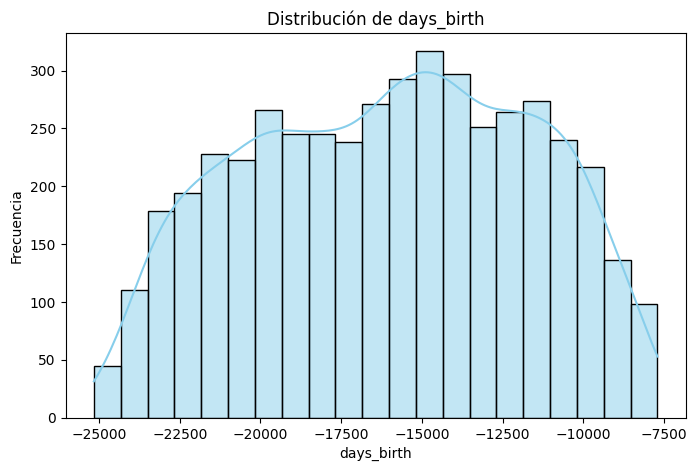

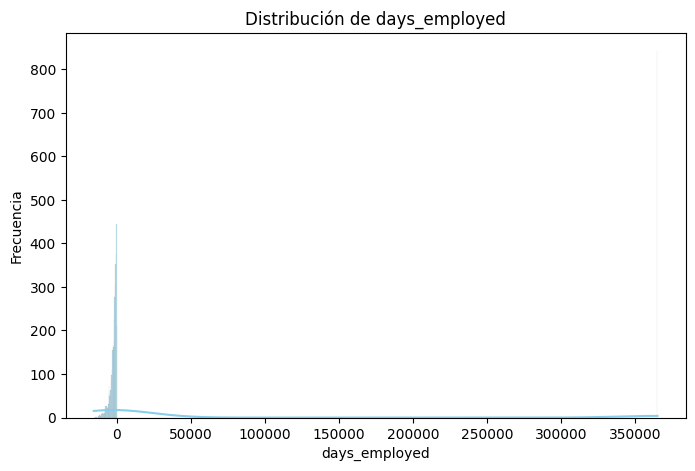

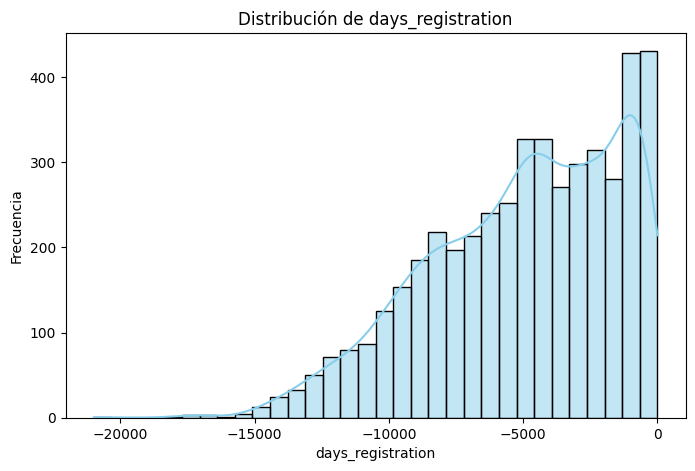

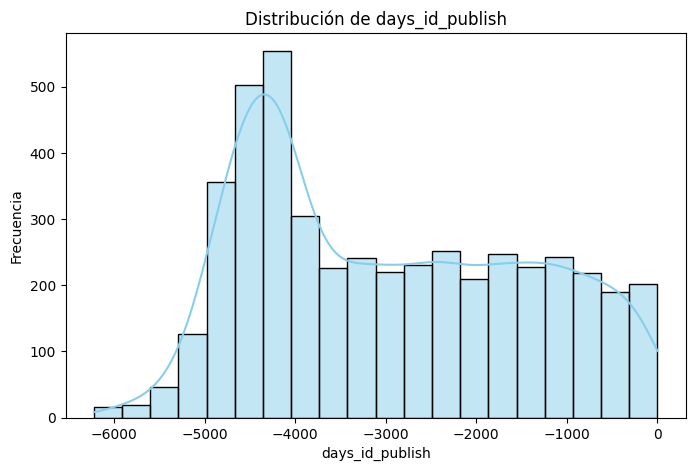

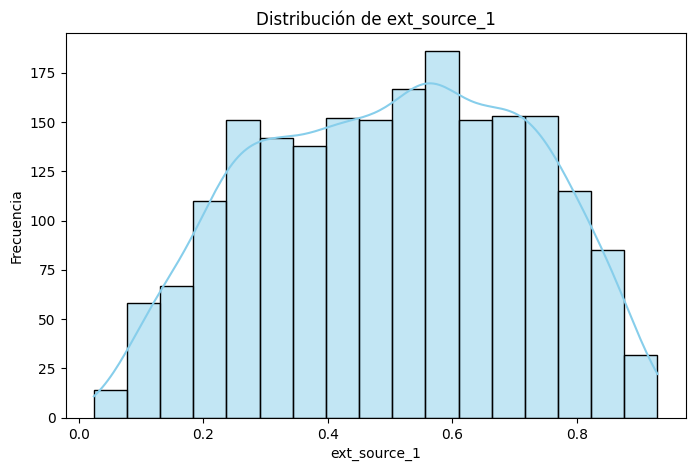

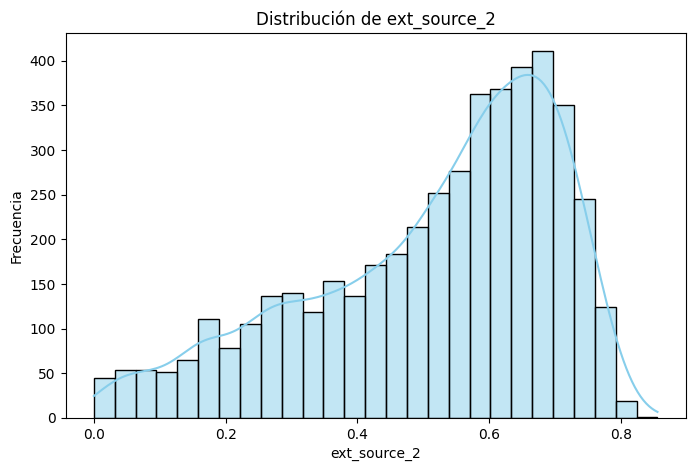

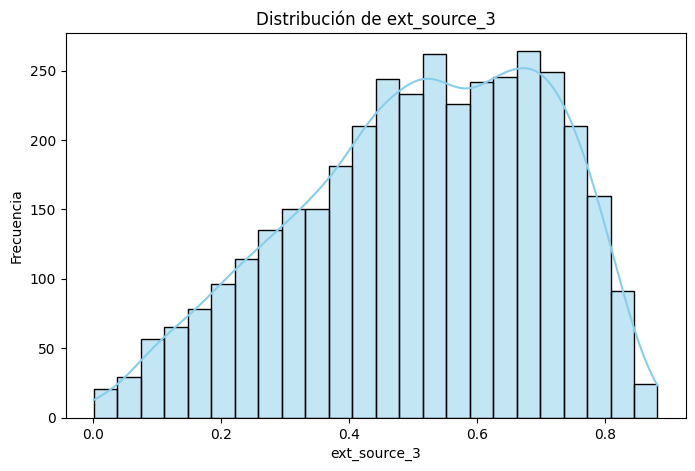

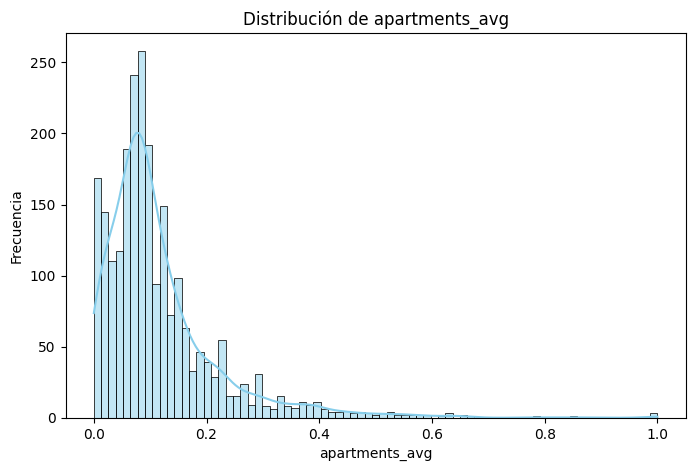

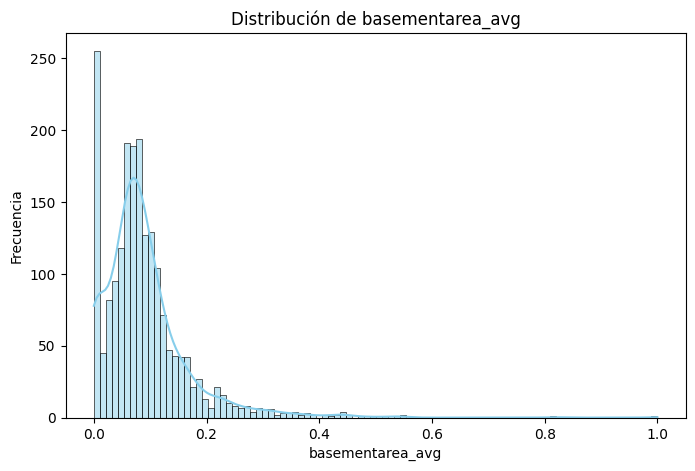

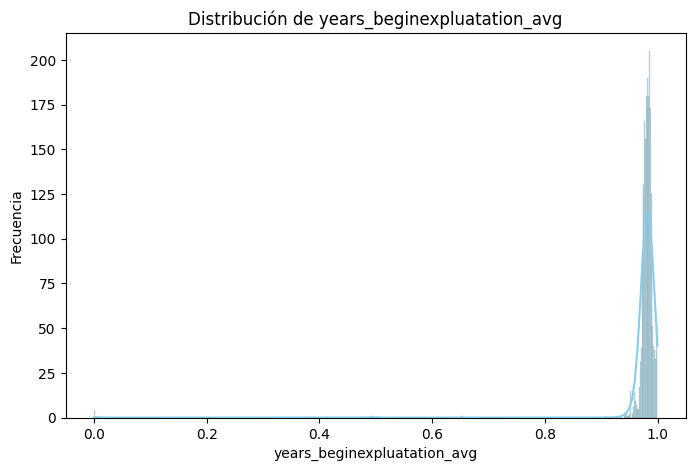

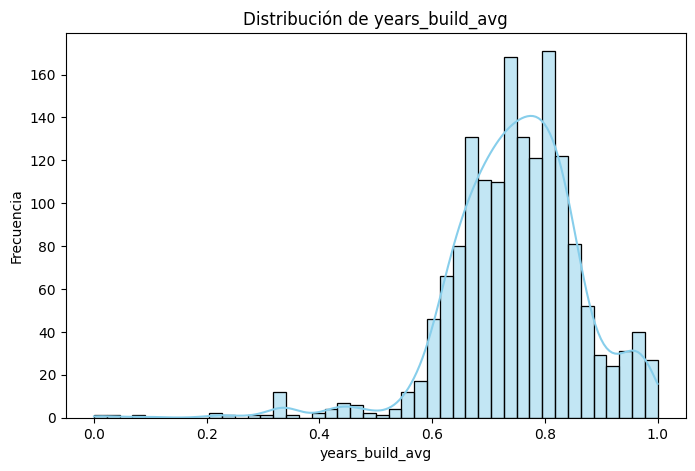

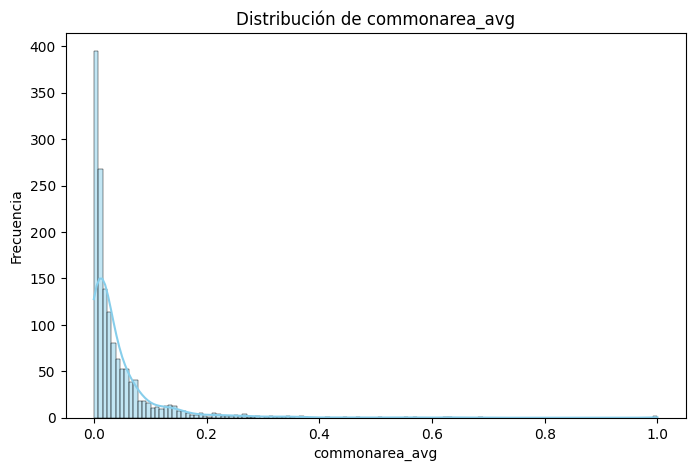

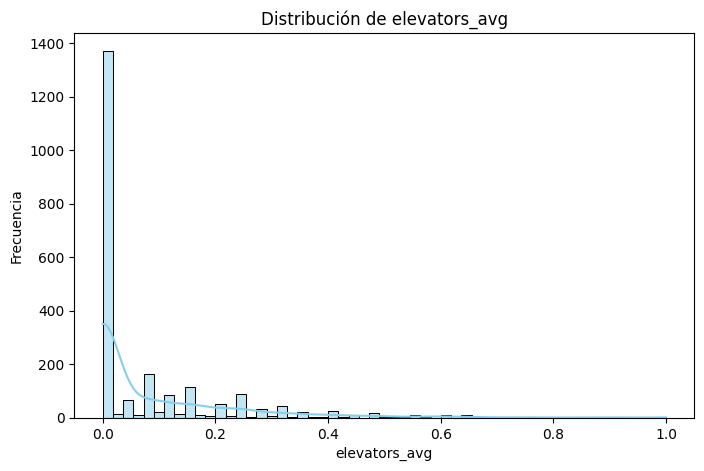

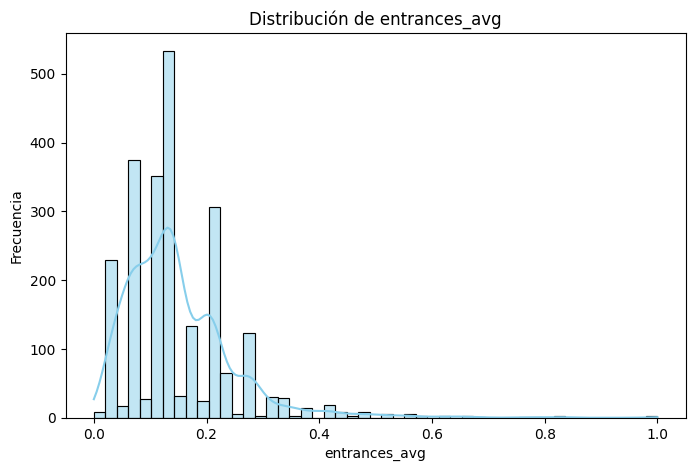

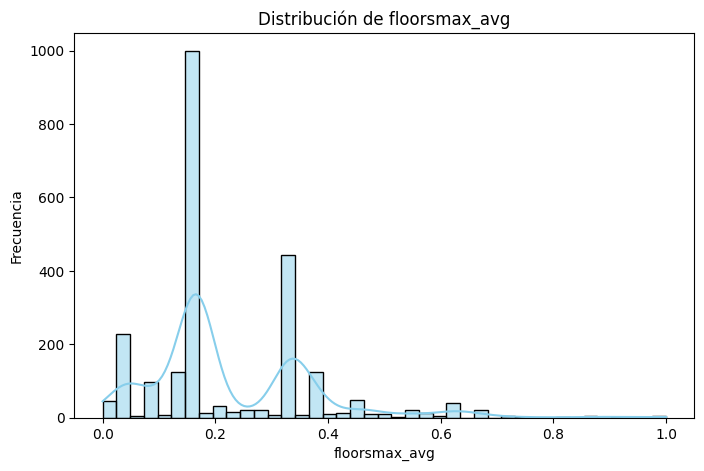

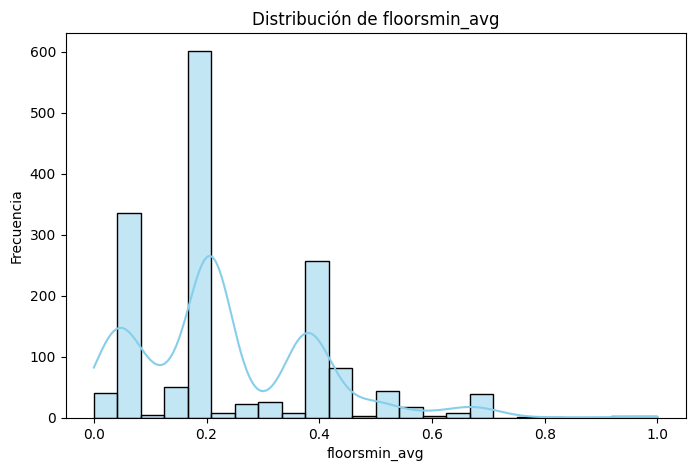

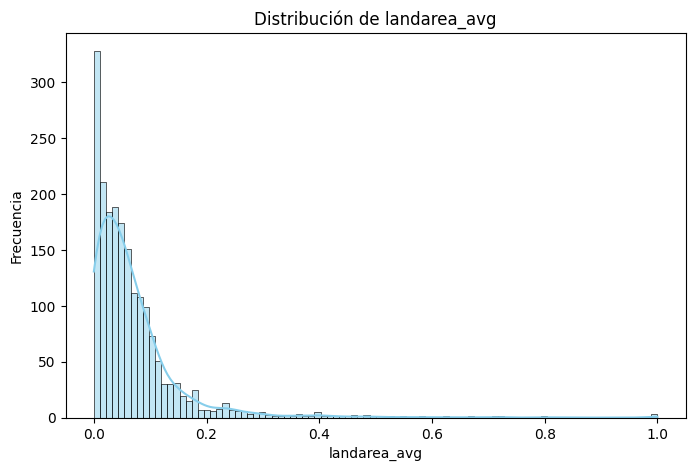

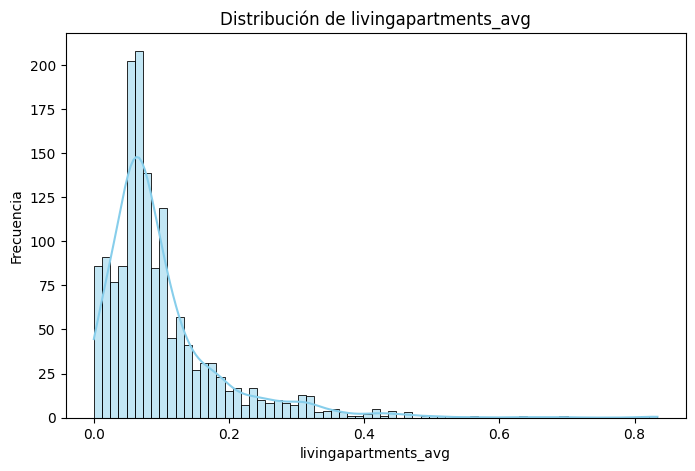

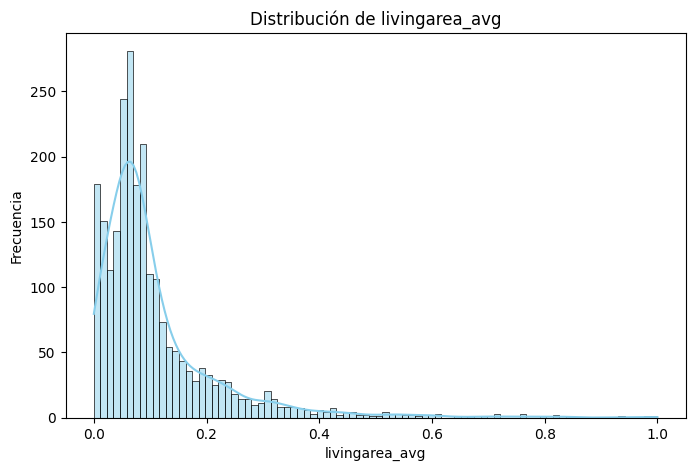

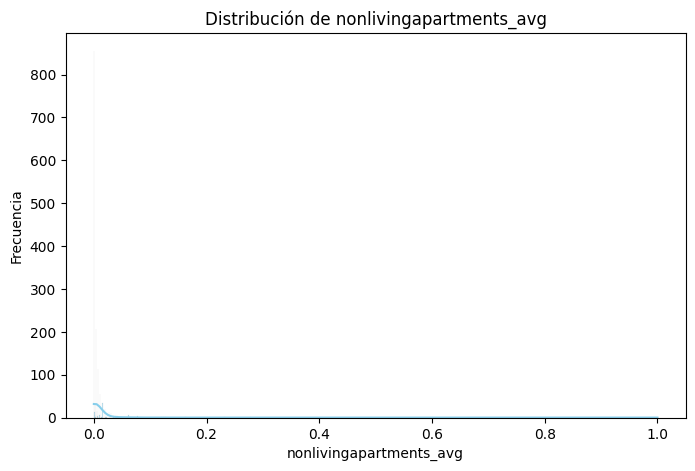

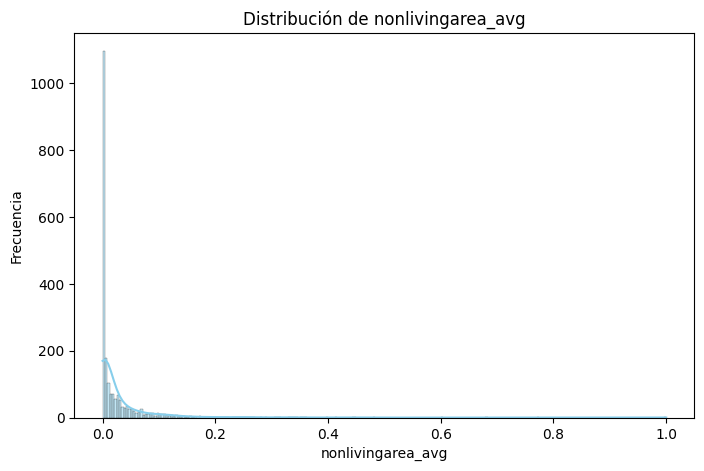

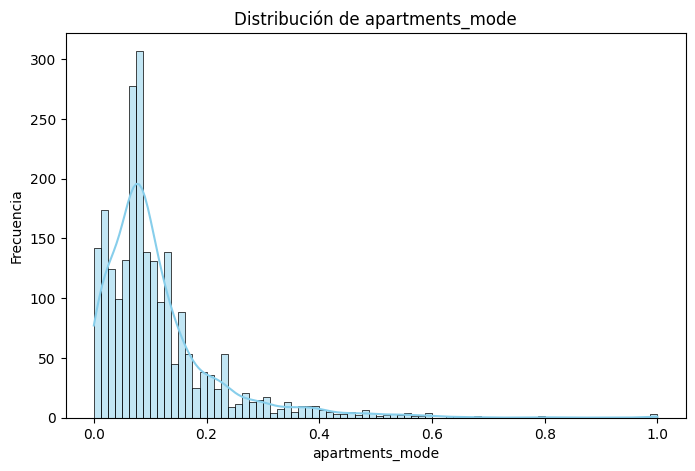

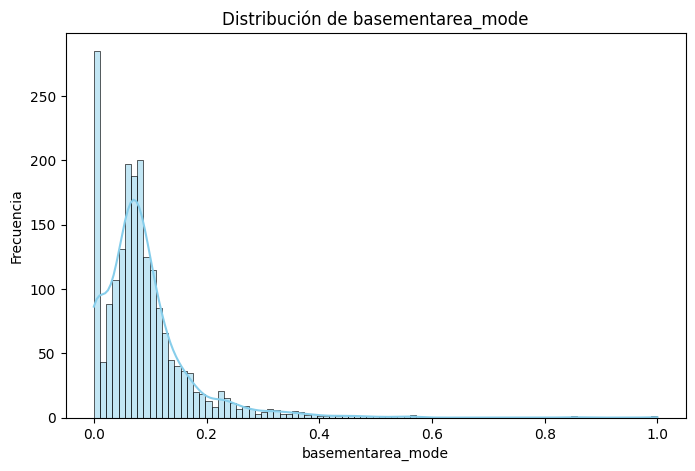

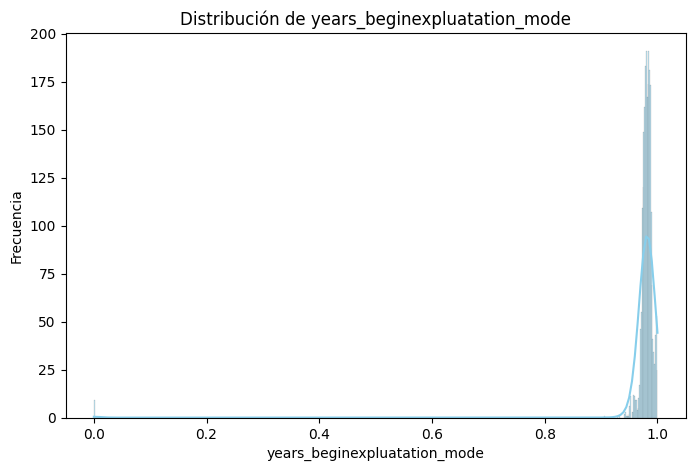

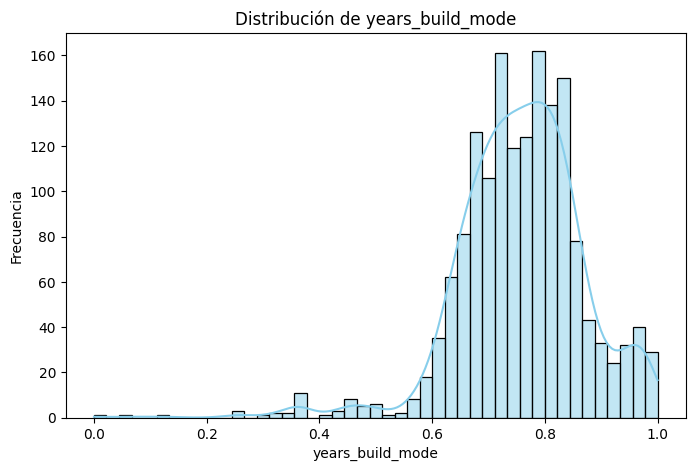

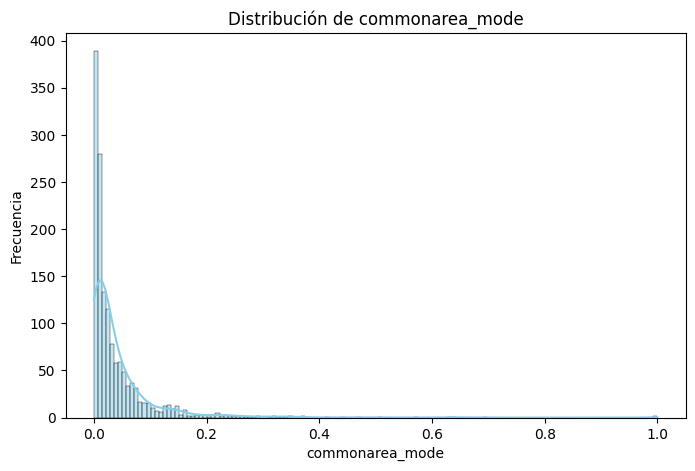

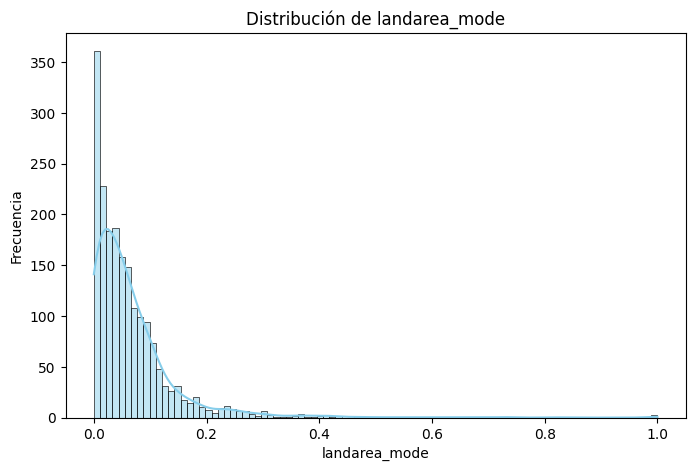

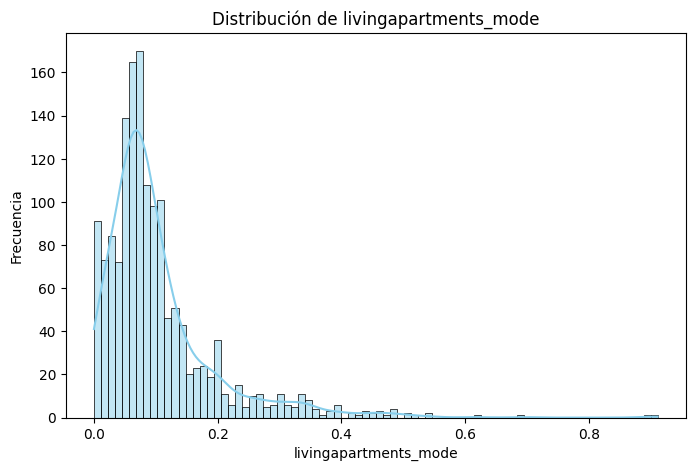

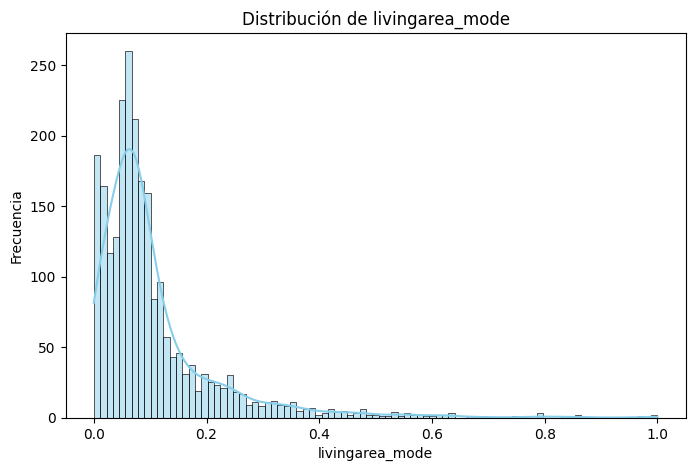

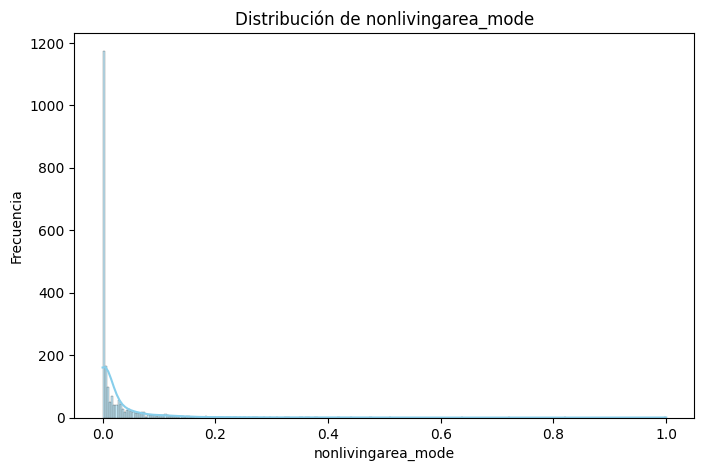

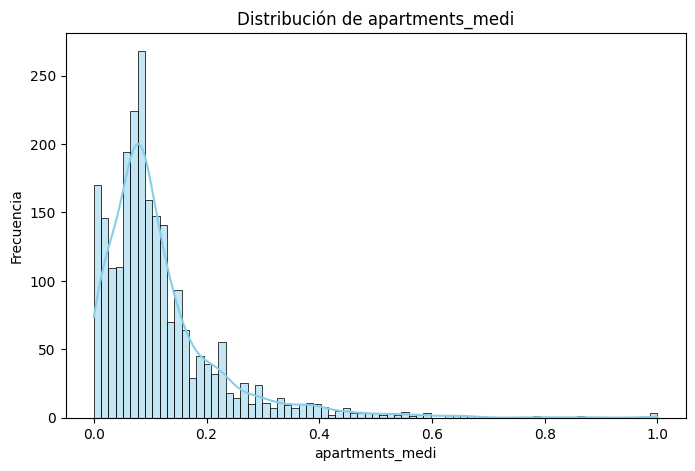

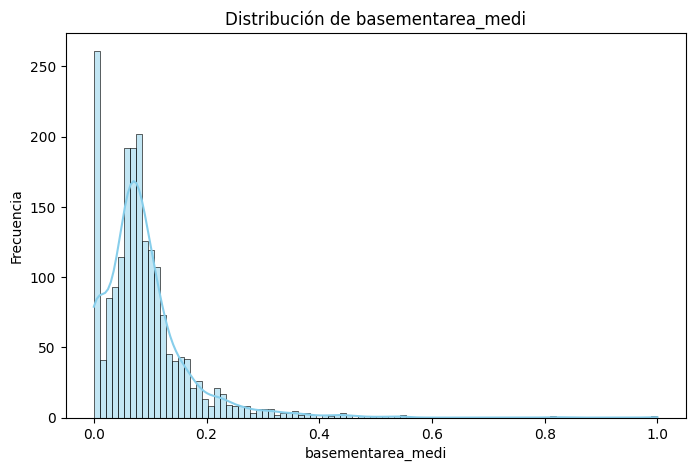

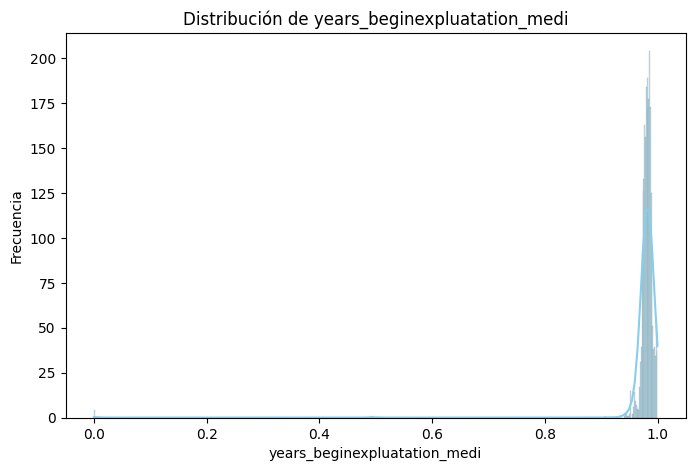

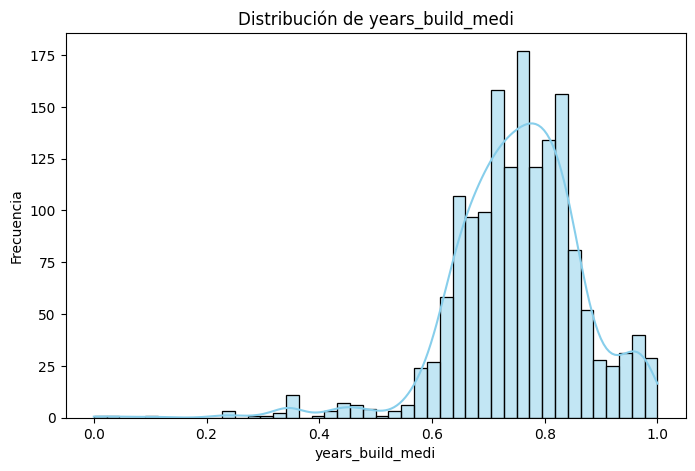

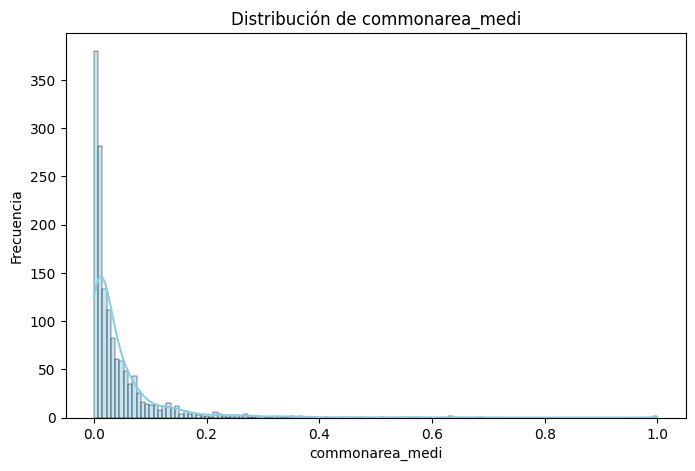

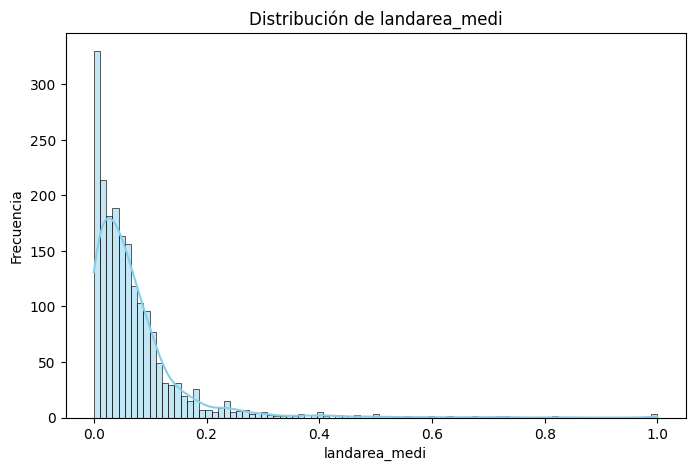

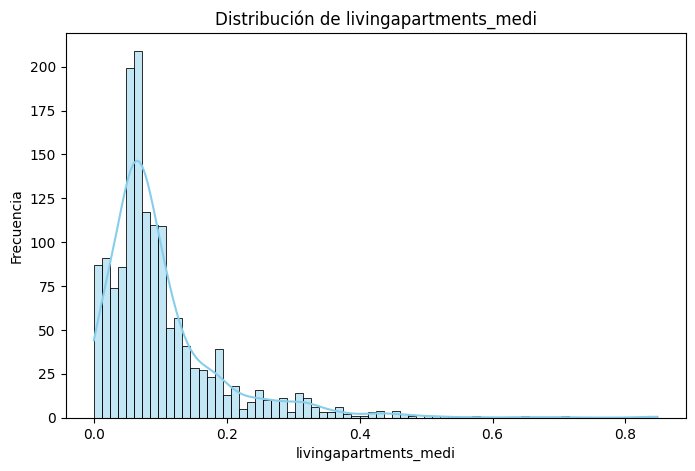

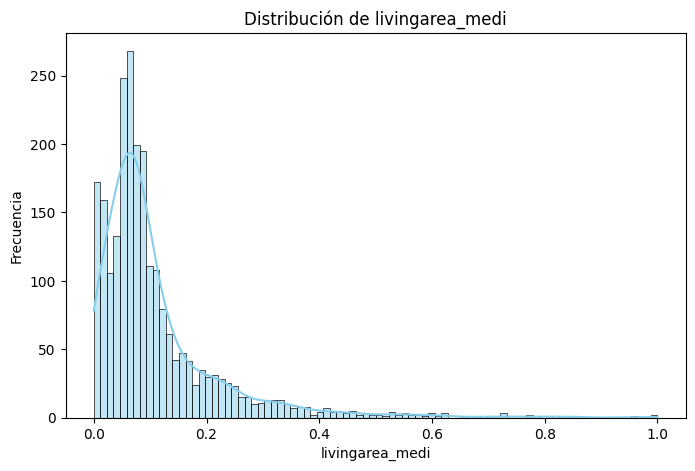

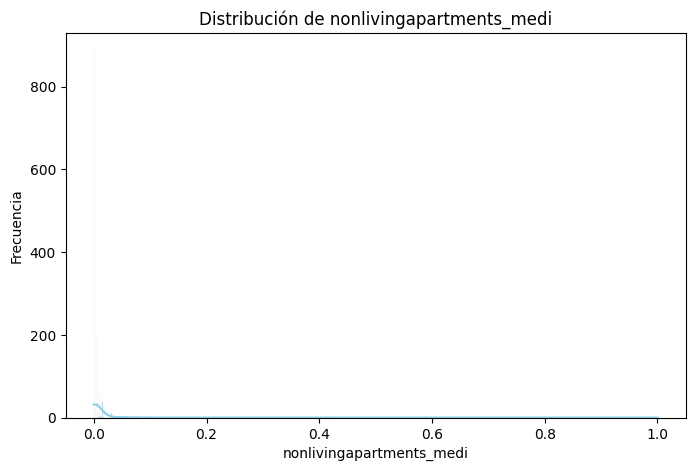

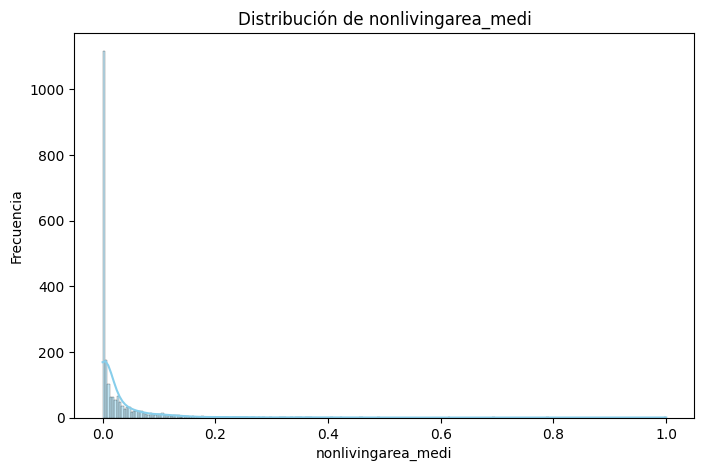

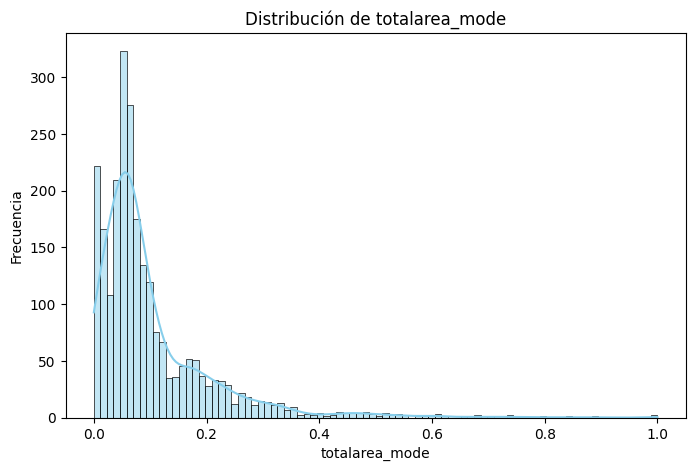

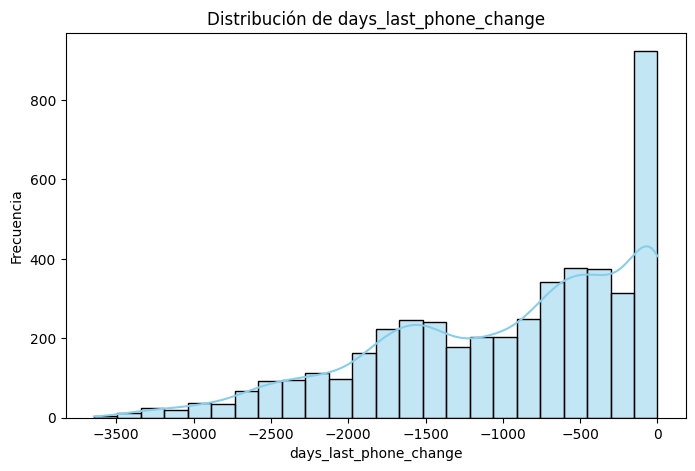

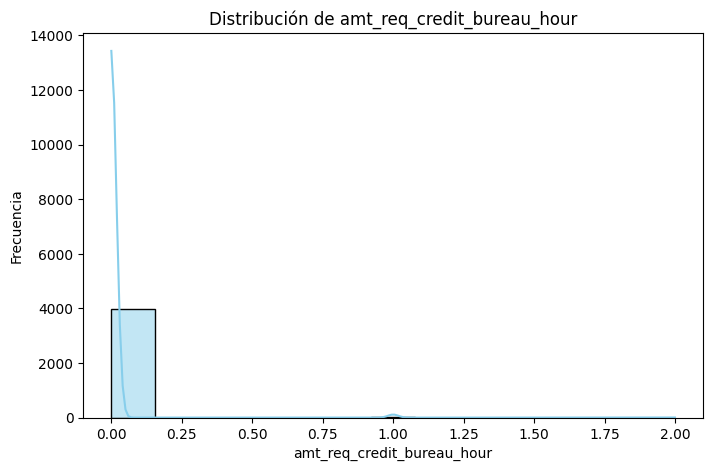

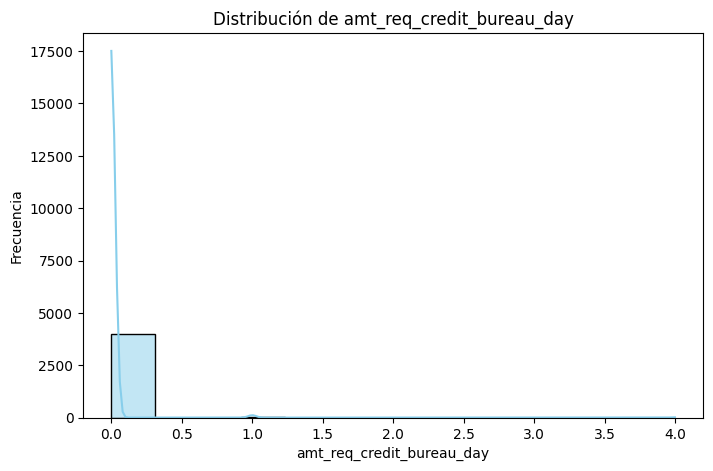

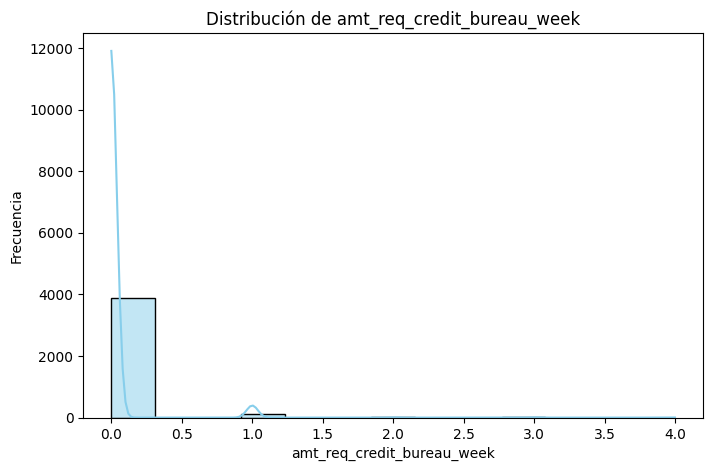

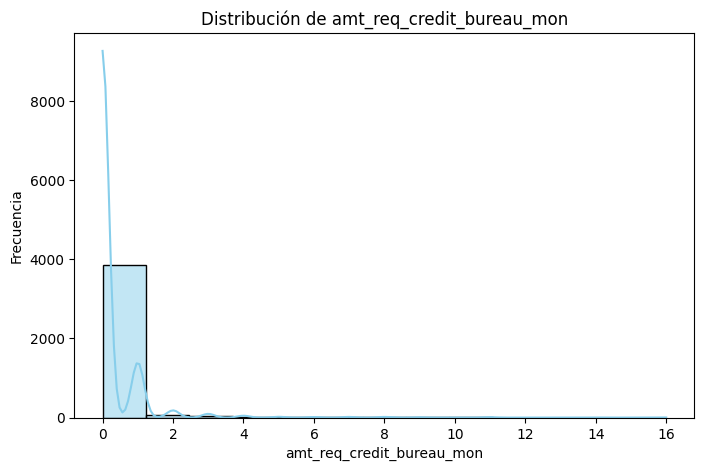

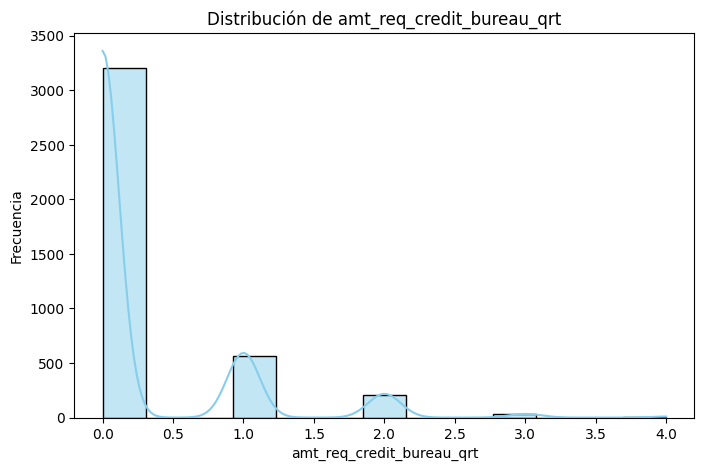

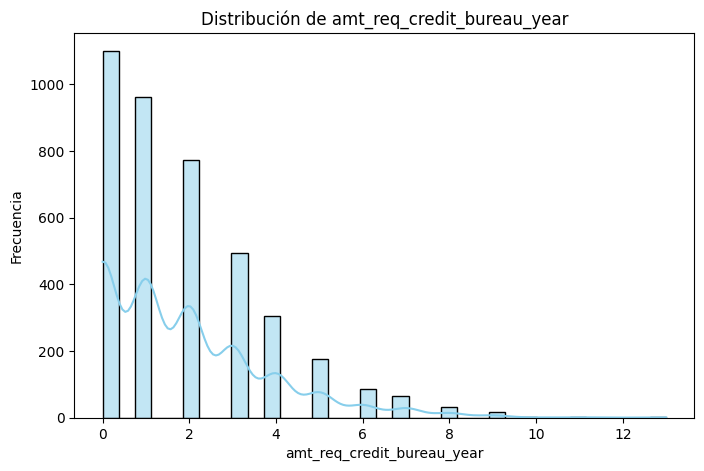

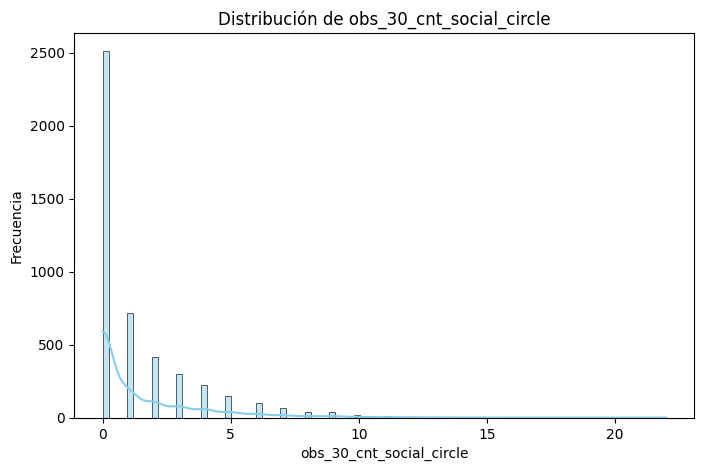

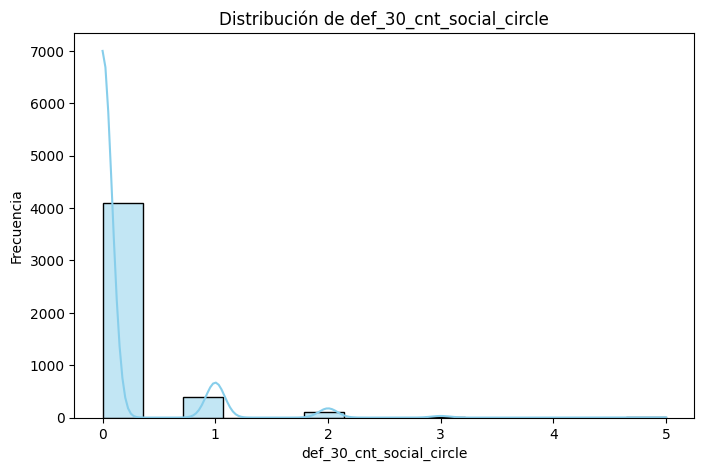

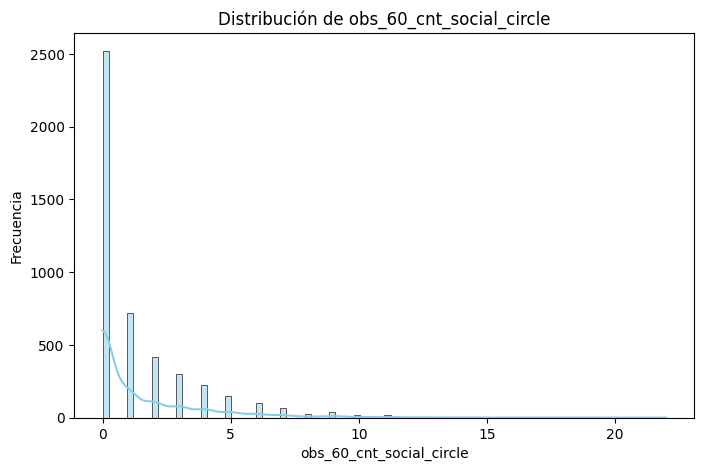

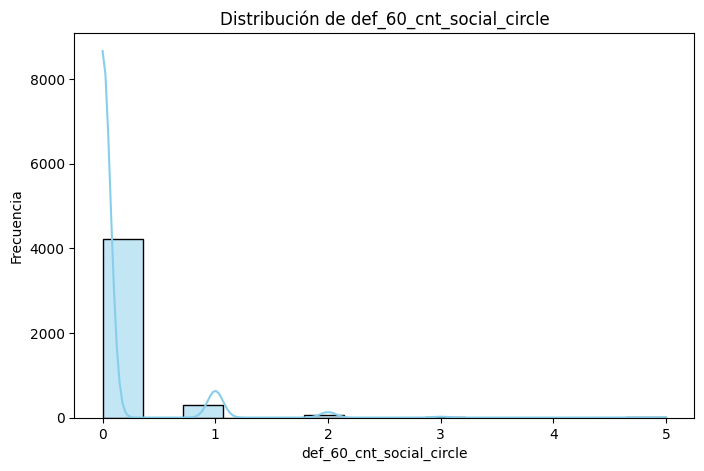

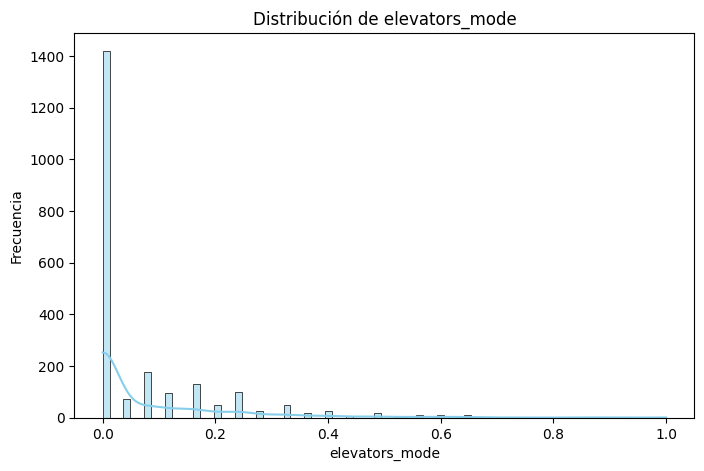

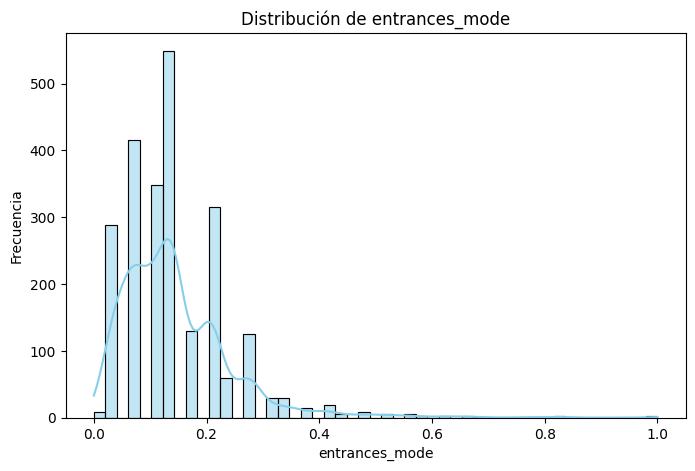

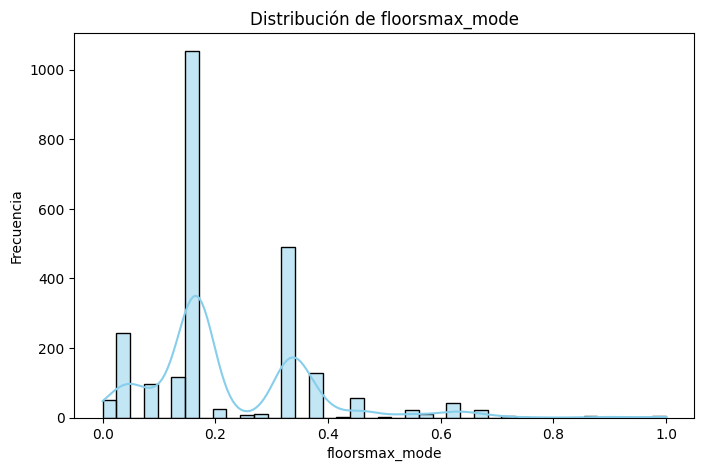

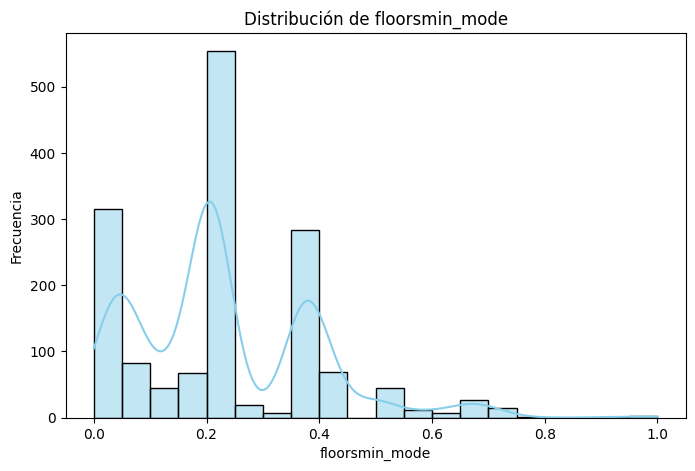

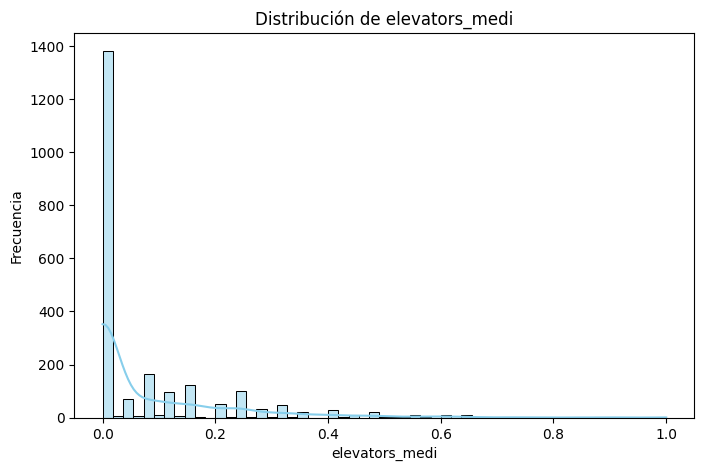

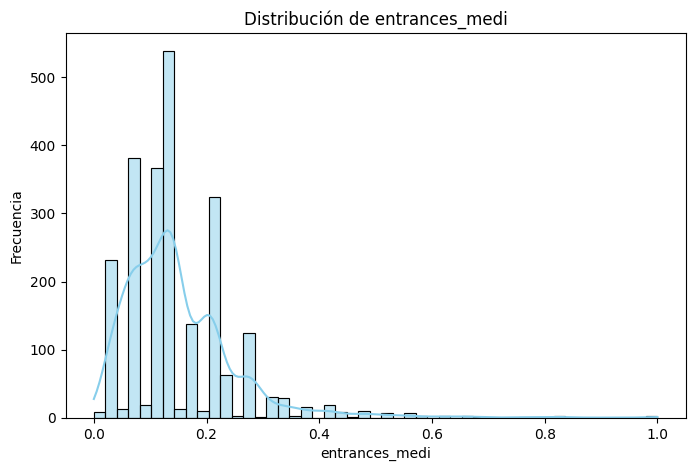

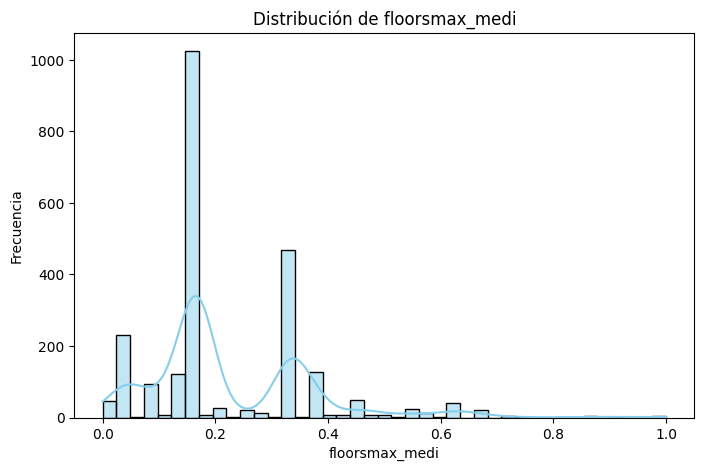

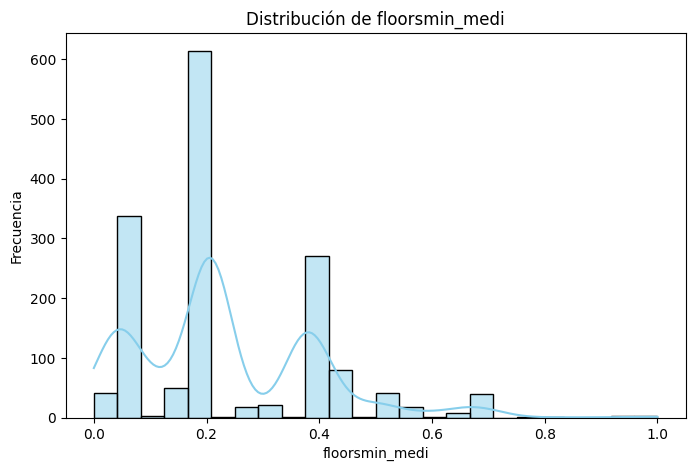

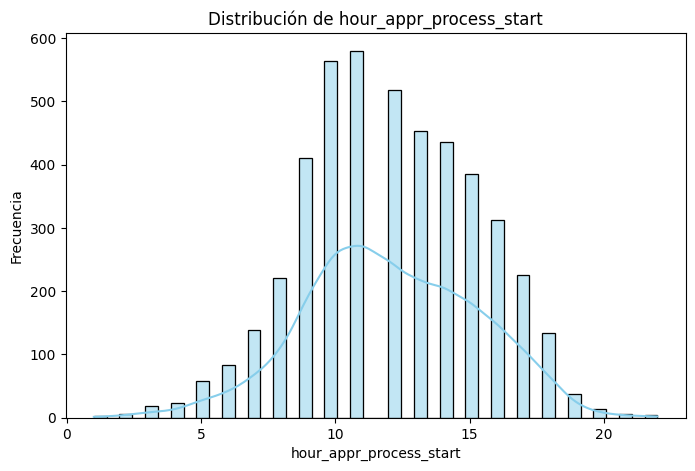

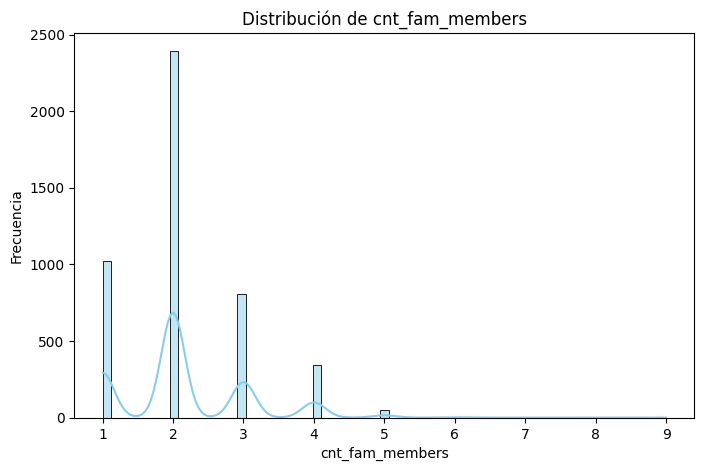

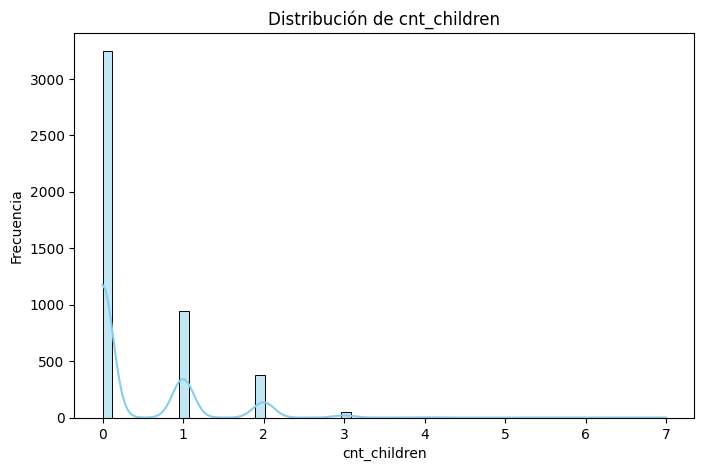

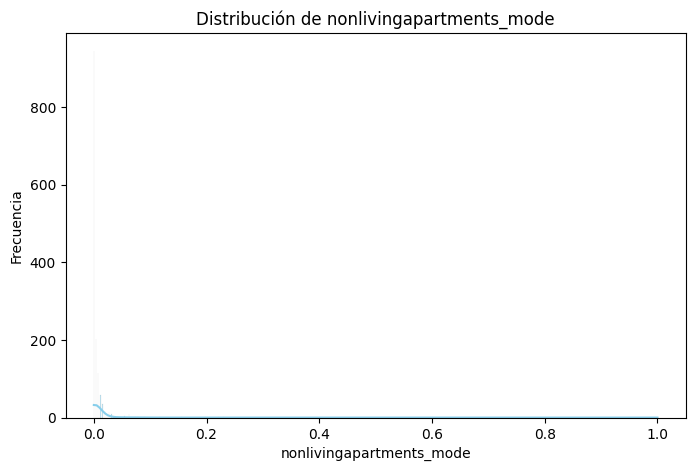

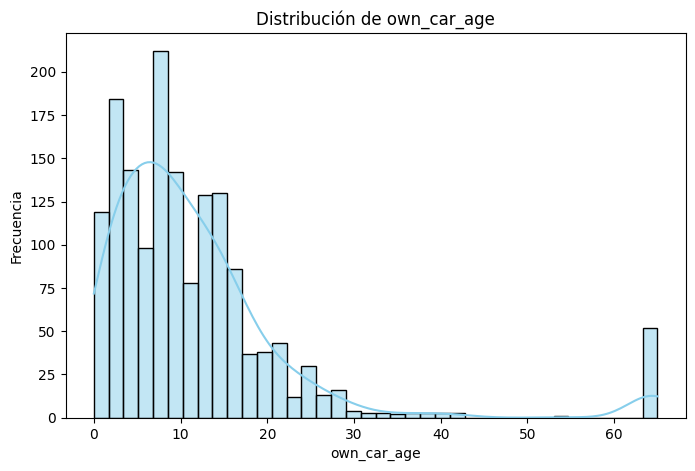

In [162]:
outlier_results = analyze_outliers(credit_procesado_train, list_var_continuous, target='target', multiplier=3)
print(outlier_results)

outlier_results.to_csv("outlier_analysis_results.csv", index=False)


for var in list_var_continuous:
    plt.figure(figsize=(8, 5))
    sns.histplot(credit_procesado_train[var], kde=True, color='skyblue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

# Ahora podemos analizar visualmente las distribuciones de las variables continuas
# y los outliers identificados para decidir si los eliminamos o los tratamos de alguna otra manera.


In [163]:
df_treated_median = treat_outliers(credit_procesado_train.copy(), list_var_continuous, method="median")
df_treated_mean = treat_outliers(credit_procesado_train.copy(), list_var_continuous, method="mean")

print("Datos tratados con la mediana:")
print(df_treated_median.head())

print("Datos tratados con la media:")
print(df_treated_mean.head())

Datos tratados con la mediana:
      sk_id_curr name_contract_type code_gender flag_own_car flag_own_realty  \
2479    102892.0         Cash loans           F            N               Y   
1807    102115.0         Cash loans           M            Y               Y   
3438    104013.0         Cash loans           F            N               Y   
4332    105066.0         Cash loans           M            Y               Y   
3811    104453.0    Revolving loans           F            N               Y   

      cnt_children  amt_income_total  amt_credit  amt_annuity  \
2479           0.0          157500.0    834048.0      25285.5   
1807           0.0          247500.0    450000.0      42642.0   
3438           0.0          117000.0    320382.0      14242.5   
4332           0.0          112500.0    341280.0      27094.5   
3811           1.0          157500.0    360000.0      18000.0   

      amt_goods_price name_type_suite name_income_type  \
2479         720000.0   Unaccompanied  


 Nuestro analisis comienza con la **identificación de los outliers** a través de un análisis estadístico utilizando el rango intercuartílico (IQR). Luego, para visualizar estos outliers y obtener una mejor comprensión de su distribución, se utilizan **gráficos de distribución**. Finalmente, una vez identificados y visualizados, se lleva a cabo un **tratamiento de outliers**, donde los valores atípicos se reemplazan por la **mediana** o la **media** según el método elegido, lo que permite una mejor calidad de los datos antes de alimentar el modelo predictivo. Este enfoque secuencial y detallado asegura que los outliers sean manejados adecuadamente para optimizar el rendimiento del modelo sin perder información valiosa.

 Tras este análisis hemos observado lo siguiente:
 1. Las Variables sin outliers (Outlier Count = 0):
SK_ID_CURR, REGION_POPULATION_RELATIVE, DAYS_BIRTH, HOUR_APPR_PROCESS_START, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, entre otras.

  Estas variables parecen tener distribuciones más controladas, probablemente con límites bien definidos o sin valores extremos significativos. Esto podría deberse a que estas características se mantienen dentro de un rango razonable debido a la naturaleza de los datos (por ejemplo, escalas limitadas como porcentajes o rangos temporales).


2. Variables con outliers moderados (Outlier Count entre 100 y 4000):
CNT_CHILDREN, AMT_CREDIT, AMT_ANNUITY, CNT_FAM_MEMBERS, OWN_CAR_AGE, entre otras.

  Estas variables muestran cierta dispersión en los datos, probablemente reflejando casos inusuales pero plausibles.

  Por ejemplo:En CNT_CHILDREN, los valores extremos podrían representar familias con un número significativamente alto de hijos.

  OWN_CAR_AGE podría tener outliers relacionados con registros de autos muy viejos o errores en los datos


 3. Posteriormente, disponemos de las Variables con muchos outliers (Outlier Count > 10,000): DAYS_EMPLOYED, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, etc.

  Estas variables presentan una cantidad considerable de valores extremos. Algunos posibles motivos incluyen:

  DAYS_EMPLOYED: Puede contener registros inválidos (como valores extremadamente altos para personas que nunca trabajaron).

  AMT_REQ_CREDIT_BUREAU_*: Podría estar influida por errores en el registro de consultas o casos atípicos de personas con alta actividad crediticia.

### **Correlaciones**

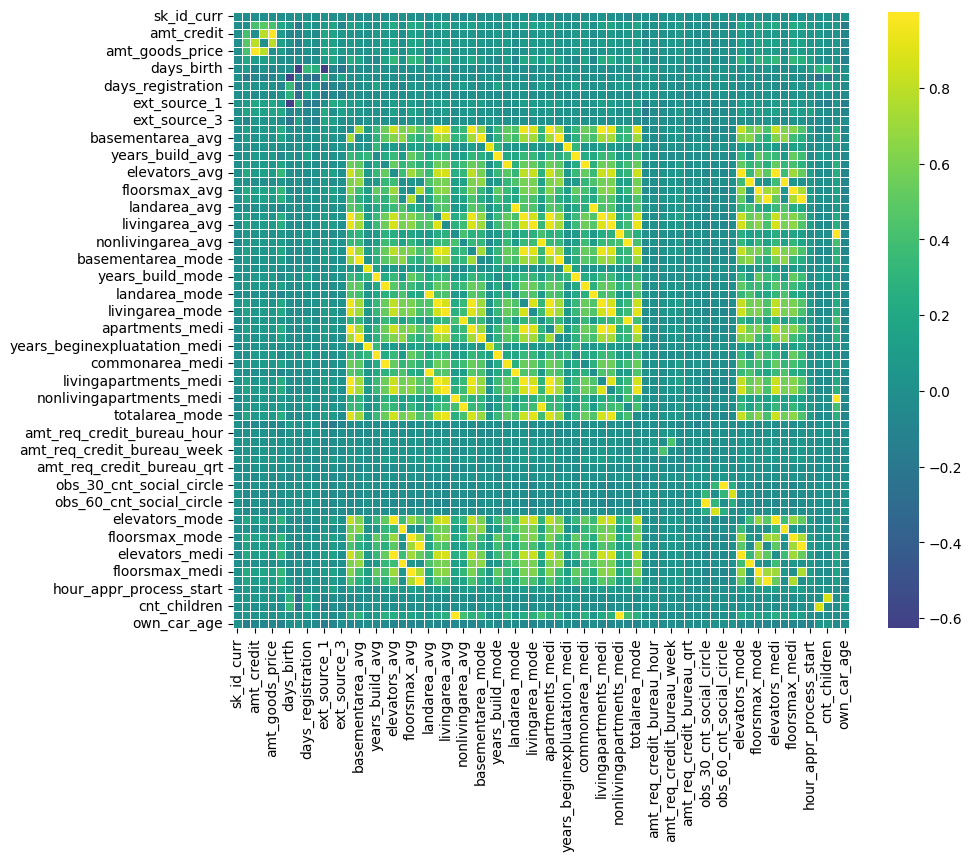

In [164]:
# Matriz de correlación para variables numéricas
num_corr_matrix = get_corr_matrix(dataset=credit_procesado_train[list_var_continuous], metodo='pearson', size_figure=[10, 8])

### **Tratamiento de valores nulos**

¿Son todos los nulos de una clase de la variable objetivo? o tienen el mismo porcentaje de la variable objetivo?

En este paso, vamos a calcular el porcentaje de valores numéricos presentes en cada variable numérica. Además, vamos a analizar la distribución de los valores nulos en cada uno de los valores únicos de la variable objetivo (TARGET). Este análisis es crucial, ya que nos permitirá identificar si existe una diferencia significativa en la proporción de valores nulos entre las dos clases de la variable objetivo (0 y 1).

Si encontramos que una columna muestra una diferencia significativa en la proporción de nulos entre las dos clases de TARGET, esto podría sugerir que la columna es relevante para el análisis. Es posible que los valores nulos en esa columna estén asociados a una clase específica de TARGET. Por ejemplo, si los nulos se concentran más en los casos donde TARGET = 1, esto podría indicar un patrón que sea útil para la predicción del objetivo.

Por otro lado, si no encontramos una diferencia significativa, podemos concluir que los valores nulos en esa columna no tienen un impacto considerable en la predicción de TARGET. En este caso, podríamos decidir no darle mucha importancia a estos nulos o, si la proporción de nulos es demasiado alta, incluso optar por eliminar la columna del análisis.

Además de los valores nulos, calcularemos la relación entre las variables numéricas y la variable TARGET. Esto nos ayudará a identificar qué variables tienen una correlación o una relación significativa con el objetivo, lo que es clave para decidir cómo tratarlas. Si una variable muestra una relación fuerte con TARGET, podría ser relevante para el modelo, y deberíamos tener precaución al manejar los valores nulos o cualquier otro tipo de datos faltantes en ella.


Esta evaluación nos permitirá tomar decisiones informadas sobre cómo manejar las columnas con valores nulos: si debemos eliminarlas, imputarlas con valores adecuados o tratarlas de otro modo según su impacto en el análisis.

In [165]:
calcular_nulos_por_objetivo(credit_procesado_train, 'target', 'continuas')

Target_0  Target_1  Total_Porcentaje (%)  \
commonarea_avg                   68.50     70.67                 69.59   
commonarea_medi                  68.50     70.67                 69.59   
commonarea_mode                  68.50     70.67                 69.59   
nonlivingapartments_mode         68.29     69.83                 69.06   
nonlivingapartments_medi         68.29     69.83                 69.06   
nonlivingapartments_avg          68.29     69.83                 69.06   
livingapartments_mode            67.19     69.27                 68.23   
livingapartments_avg             67.19     69.27                 68.23   
livingapartments_medi            67.19     69.27                 68.23   
floorsmin_avg                    66.35     68.72                 67.54   
floorsmin_medi                   66.35     68.72                 67.54   
floorsmin_mode                   66.35     68.72                 67.54   
years_build_mode                 64.80     68.44                 66.62   
years_build_avg                  64.80     68.44                 66.62   
years_build_medi                 64.80     68.44                 66.62   
own_car_age                      65.62     67.04                 66.33   
basementarea_mode                57.06     61.45                 59.26   
basementarea_medi                57.06     61.45                 59.26   
basementarea_avg                 57.06     61.45                 59.26   
landarea_mode                    57.99     60.34                 59.17   
landarea_medi                    57.99     60.34                 59.17   
landarea_avg                     57.99     60.34                 59.17   
ext_source_1                     55.84     61.45                 58.64   
nonlivingarea_medi               53.26     57.26                 55.26   
nonlivingarea_avg                53.24     57.26                 55.25   
nonlivingarea_mode               53.24     57.26                 55.25   
elevators_avg                    51.58     56.70                 54.14   
elevators_mode                   51.58     56.70                 54.14   
elevators_medi                   51.58     56.70                 54.14   
apartments_mode                  49.38     53.91                 51.64   
apartments_avg                   49.38     53.91                 51.64   
apartments_medi                  49.38     53.91                 51.64   
entrances_avg                    48.35     53.91                 51.13   
entrances_mode                   48.35     53.91                 51.13   
entrances_medi                   48.35     53.91                 51.13   
livingarea_medi                  48.63     53.07                 50.85   
livingarea_avg                   48.61     53.07                 50.84   
livingarea_mode                  48.61     53.07                 50.84   
floorsmax_mode                   47.84     53.07                 50.46   
floorsmax_avg                    47.84     53.07                 50.46   
floorsmax_medi                   47.84     53.07                 50.46   
years_beginexpluatation_medi     47.32     51.96                 49.64   
years_beginexpluatation_avg      47.32     51.96                 49.64   
years_beginexpluatation_mode     47.32     51.96                 49.64   
totalarea_mode                   46.59     51.96                 49.28   
ext_source_3                     18.96     23.74                 21.35   
amt_req_credit_bureau_week       12.89     18.16                 15.52   
amt_req_credit_bureau_year       12.89     18.16                 15.52   
amt_req_credit_bureau_qrt        12.89     18.16                 15.52   
amt_req_credit_bureau_mon        12.89     18.16                 15.52   
amt_req_credit_bureau_hour       12.89     18.16                 15.52   
amt_req_credit_bureau_day        12.89     18.16                 15.52   
ext_source_2                      0.30      0.28                  0.29   
obs_30_cnt_social_circle          

In [166]:
corr_with_target = credit_procesado_train[list_var_continuous].corrwith(credit_procesado_train['target'], method='pearson')
print(corr_with_target)

sk_id_curr                      0.006920
amt_income_total               -0.017299
amt_credit                     -0.055169
amt_annuity                    -0.024734
amt_goods_price                -0.061726
region_population_relative     -0.034858
days_birth                      0.078382
days_employed                  -0.036521
days_registration               0.056961
days_id_publish                 0.063900
ext_source_1                   -0.143520
ext_source_2                   -0.170827
ext_source_3                   -0.209723
apartments_avg                  0.004942
basementarea_avg                0.030366
years_beginexpluatation_avg    -0.007400
years_build_avg                -0.018988
commonarea_avg                  0.018901
elevators_avg                  -0.013990
entrances_avg                   0.011314
floorsmax_avg                  -0.034543
floorsmin_avg                  -0.024244
landarea_avg                    0.022642
livingapartments_avg            0.022826
livingarea_avg  

In [167]:
#Metrica para tratar los nulos

umbral_baja_correlacion = 0.1
umbral_alta_correlacion = 0.5
umbral_nulos = 0.7


porcentaje_nulos = credit_procesado_train.isnull().mean()


for col in list_var_continuous:
    # Condición 1: Si la columna tiene una baja correlación y muchos nulos
    if (corr_with_target[col] < umbral_baja_correlacion and porcentaje_nulos[col] > umbral_nulos):
        credit_procesado_train[col] = credit_procesado_train[col].fillna(credit_procesado_train[col].median())

    # Condición 2: Si la columna tiene una alta correlación con el objetivo
    elif (corr_with_target[col] > umbral_alta_correlacion):
        credit_procesado_train[col] = credit_procesado_train[col].fillna(credit_procesado_train[col].median())

    # Condición 3: Si la columna tiene nulos distribuidos de manera desigual entre las clases del objetivo
    elif porcentaje_nulos[col] > 0:
        for target_class in credit_procesado_train['target'].unique():
            mediana_clase = credit_procesado_train[credit_procesado_train['target'] == target_class][col].median()
            credit_procesado_train.loc[(credit_procesado_train['target'] == target_class) & (credit_procesado_train[col].isnull()), col] = mediana_clase

# Eliminar columnas con más del 70% de nulos y baja correlación
columnas_a_eliminar = [col for col in list_var_continuous if porcentaje_nulos[col] > umbral_nulos and corr_with_target[col] < umbral_baja_correlacion]
credit_procesado_train = credit_procesado_train.drop(columns=columnas_a_eliminar)


Las métricas que hemos utilizado para tratar estos nulos:



1.   Manejo de nulos con la mediana

*  Baja correlación y altos nulos: Imputamos la mediana solo a las columnas con baja correlación con la variable objetivo y un alto porcentaje de nulos.
*   Alta correlación: Si la correlación con la variable objetivo es alta, también imputamos la mediana.

* Distribución desigual de nulos: Si los nulos están distribuidos de manera desigual según las clases de la variable objetivo `target`, imputamos la mediana por clase.


2. Eliminación de columnas:

* Si una columna tiene más del 70% de nulos y baja correlación con la variable objetivo, se elimina del DataFrame.


In [168]:
# Imputación de nulos por la mediana de las columnas del conjunto de entrenamiento

medianas_train = credit_procesado_train[list_var_continuous].median()
credit_procesado_test[list_var_continuous] = credit_procesado_test[list_var_continuous].fillna(medianas_train)

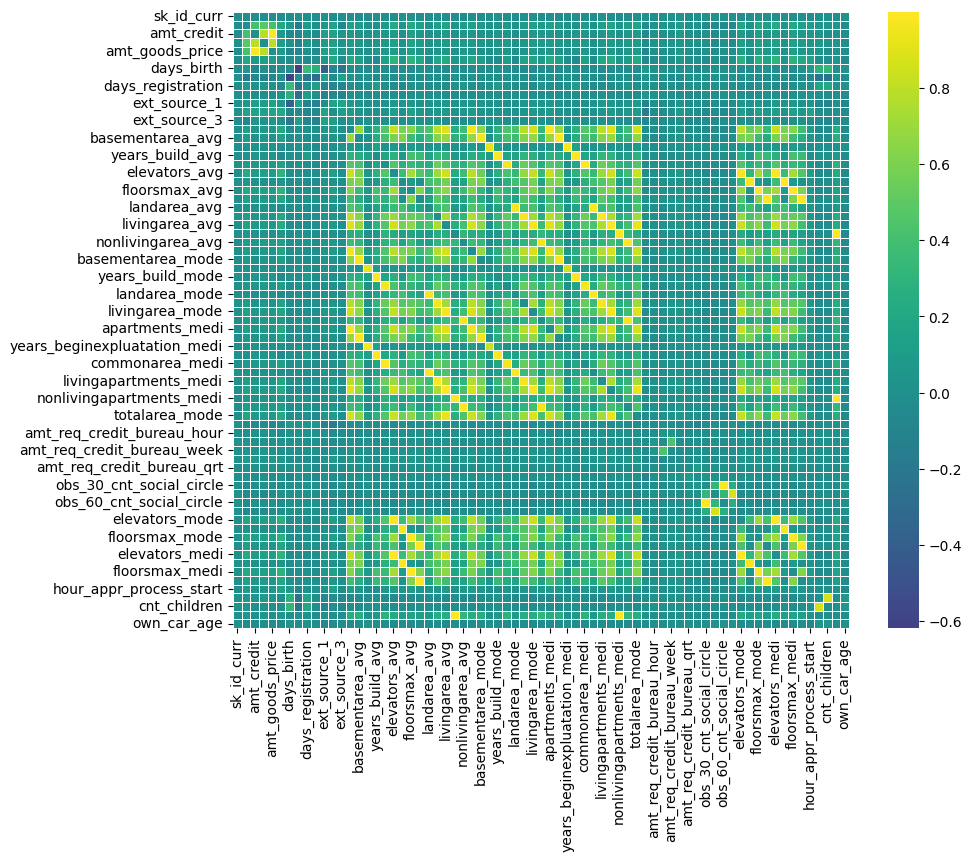

In [169]:
num_corr_matrix_sin_nulos = get_corr_matrix(dataset=credit_procesado_train[list_var_continuous], metodo='pearson', size_figure=[10, 8])

## **Tratamiento de las variables categoricas**

### **Correlaciones**

In [170]:
warnings.filterwarnings('ignore')

correlation_matrix = pd.DataFrame(index=list_var_cat, columns=list_var_cat)

for var1 in list_var_cat:
    for var2 in list_var_cat:
        if var1 != var2:
            confusion_matrix = pd.crosstab(credit_procesado_train[var1], credit_procesado_train[var2])
            if confusion_matrix.shape[0] > 1 and confusion_matrix.shape[1] > 1:
                cramers_v_value = cramers_v(confusion_matrix.values)
                correlation_matrix.loc[var1, var2] = cramers_v_value
            else:
                correlation_matrix.loc[var1, var2] = np.nan
        else:
            correlation_matrix.loc[var1, var2] = 1.0

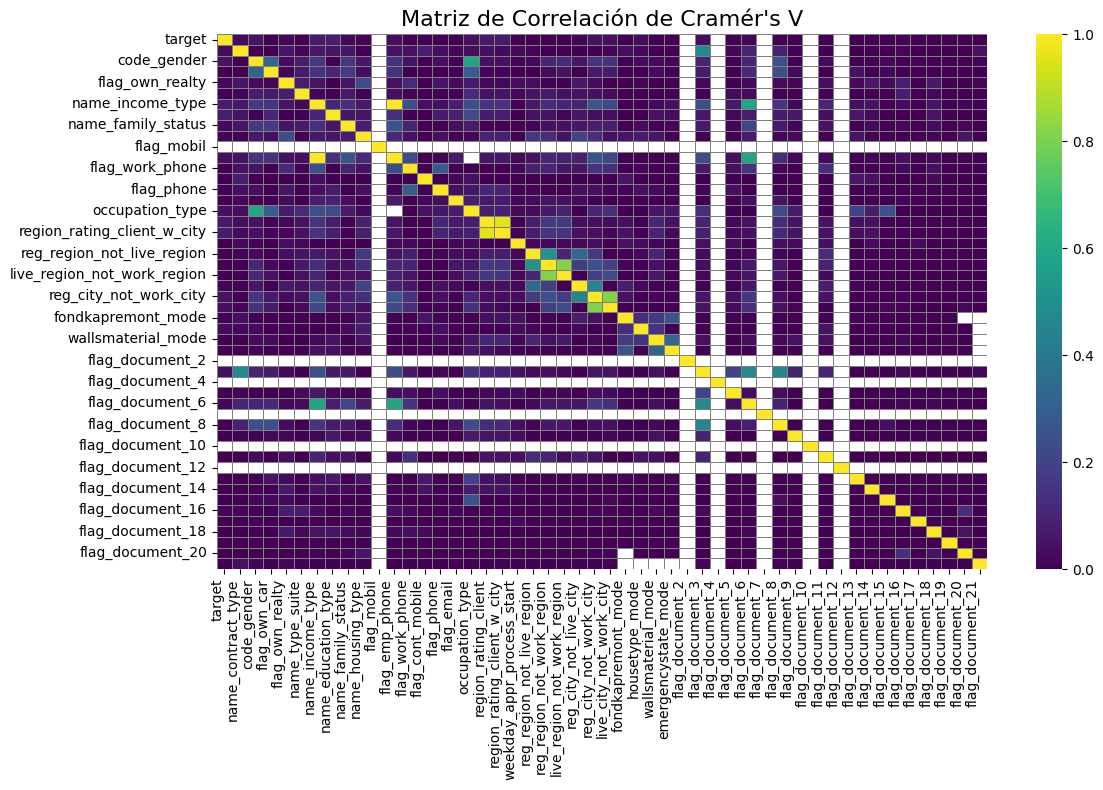

In [171]:
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=False, cmap="viridis", vmin=0, vmax=1, cbar=True, linewidths=0.5, linecolor='gray')

plt.title('Matriz de Correlación de Cramér\'s V', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

### **Tratamiento de valores nulos**

In [172]:
calcular_nulos_por_objetivo(credit_procesado_train, 'target', 'categoricas')

Target_0  Target_1  Total_Porcentaje (%)  \
fondkapremont_mode              66.77     68.99                 67.88   
wallsmaterial_mode              49.31     53.63                 51.47   
housetype_mode                  48.35     53.35                 50.85   
emergencystate_mode             45.68     50.56                 48.12   
occupation_type                 31.59     24.02                 27.80   
name_type_suite                  0.47      0.00                  0.24   
flag_document_9                  0.02      0.00                  0.01   
flag_document_2                  0.02      0.00                  0.01   
flag_document_3                  0.02      0.00                  0.01   
flag_document_4                  0.02      0.00                  0.01   
flag_document_5                  0.02      0.00                  0.01   
flag_document_6                  0.02      0.00                  0.01   
flag_document_7                  0.02      0.00                  0.01   
flag_document_8                  0.02      0.00                  0.01   
flag_document_21                 0.02      0.00                  0.01   
flag_document_11                 0.02      0.00                  0.01   
flag_document_12                 0.02      0.00                  0.01   
flag_document_13                 0.02      0.00                  0.01   
flag_document_14                 0.02      0.00                  0.01   
flag_document_15                 0.02      0.00                  0.01   
flag_document_16                 0.02      0.00                  0.01   
flag_document_17                 0.02      0.00                  0.01   
flag_document_18                 0.02      0.00                  0.01   
flag_document_19                 0.02      0.00                  0.01   
flag_document_20                 0.02      0.00                  0.01   
flag_document_10                 0.02      0.00                  0.01   
target                           0.00      0.00                  0.00   
name_contract_type               0.00      0.00                  0.00   
flag_work_phone                  0.00      0.00                  0.00   
code_gender                      0.00      0.00                  0.00   
flag_own_car                     0.00      0.00                  0.00   
flag_own_realty                  0.00      0.00                  0.00   
name_income_type                 0.00      0.00                  0.00   
name_education_type              0.00      0.00                  0.00   
name_family_status               0.00      0.00                  0.00   
name_housing_type                0.00      0.00                  0.00   
flag_mobil                       0.00      0.00                  0.00   
flag_emp_phone                   0.00      0.00                  0.00   
flag_cont_mobile                 0.00      0.00                  0.00   
reg_city_not_work_city           0.00      0.00                  0.00   
flag_phone                       0.00      0.00                  0.00   
flag_email                       0.00      0.00                  0.00   
region_rating_client             0.00      0.00                  0.00   
region_rating_client_w_city      0.00      0.00                  0.00   
weekday_appr_process_start       0.00      0.00                  0.00   
reg_region_not_live_region       0.00      0.00                  0.00   
reg_region_not_work_region       0.00      0.00                  0.00   
live_region_not_work_region      0.00      0.00                  0.00   
reg_city_not_live_city           0.00      0.00                  0.00   
live_city_not_work_city          0.00      0.00                  0.00   

                             Diferencia_0_1 (%)  
fondkapremont_mode                         2.22  
wallsmaterial_mode                         4.32  
housetype_mode                             5.00  
emergencystate_mode                        4.88  
occupation_type                           -7.57  
name_

In [173]:
correlation_with_target = correlation_matrix['target'].sort_values(ascending=False)
correlation_with_target

target                         1.000000
name_education_type            0.077673
name_income_type               0.073049
region_rating_client_w_city    0.070347
region_rating_client           0.064282
code_gender                    0.047038
reg_city_not_work_city         0.046145
occupation_type                0.038331
live_city_not_work_city        0.037128
flag_emp_phone                 0.033824
flag_document_3                0.031799
housetype_mode                 0.031205
name_contract_type             0.028705
name_family_status             0.021399
flag_own_realty                0.016211
flag_document_6                0.013835
reg_city_not_live_city         0.011624
name_housing_type              0.010446
flag_document_16               0.007831
flag_phone                     0.007011
flag_email                     0.000000
flag_document_8                0.000000
flag_document_20               0.000000
flag_document_19               0.000000
flag_document_18               0.000000
flag_document_17               0.000000
flag_document_15               0.000000
flag_document_14               0.000000
flag_document_13               0.000000
flag_document_11               0.000000
flag_document_9                0.000000
flag_document_5                0.000000
flag_own_car                   0.000000
weekday_appr_process_start     0.000000
name_type_suite                0.000000
emergencystate_mode            0.000000
wallsmaterial_mode             0.000000
fondkapremont_mode             0.000000
flag_work_phone                0.000000
flag_cont_mobile               0.000000
live_region_not_work_region    0.000000
reg_region_not_work_region     0.000000
reg_region_not_live_region     0.000000
flag_document_21               0.000000
flag_mobil                          NaN
flag_document_2                     NaN
flag_document_4                     NaN
flag_document_7                     NaN
flag_document_10                    NaN
flag_document_12                    NaN
Name: target, dtype: float64

In [174]:
boolean_columns = [
    col for col in list_var_cat
    if set(credit_procesado_train[col].dropna().unique()).issubset({0, 1})
]

non_boolean_columns = [col for col in list_var_cat if col not in boolean_columns]

for col in non_boolean_columns:
    if credit_procesado_train[col].dtype.name == 'category':
        credit_procesado_train[col] = credit_procesado_train[col].cat.add_categories('No especificado')

credit_procesado_train[non_boolean_columns] = credit_procesado_train[non_boolean_columns].fillna("No especificado")



En este caso, hemos decidido sustituir todos los valores nulos por "No Especificado" debido a que la proporción de nulos en las variables es baja y no afectará significativamente la distribución general de los datos. Además, muchas de estas variables son relevantes para la predicción del objetivo `target`, por lo que mantener los registros con esta categoría garantiza que no se pierda información valiosa.

In [175]:
#Imputación de valores nulos (NaN) en las columnas categóricas del conjunto de datos de prueba (data_test).

boolean_columns = [
    col for col in list_var_cat
    if set(credit_procesado_test[col].dropna().unique()).issubset({0, 1})
]

non_boolean_columns = [col for col in list_var_cat if col not in boolean_columns]

for col in non_boolean_columns:
    if credit_procesado_test[col].dtype.name == 'category':
        credit_procesado_test[col] = credit_procesado_test[col].cat.add_categories('No especificado')

credit_procesado_test[non_boolean_columns] = credit_procesado_test[non_boolean_columns].fillna("No especificado")

In [176]:
credit_procesado_train.to_csv('credit_tratado_train.csv', index=False)

In [177]:
credit_procesado_test.to_csv('credit_tratado_test.csv', index=False)